In [2]:
# import libraries

import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import string
from string import punctuation
import os
from os import listdir
from collections import Counter
from tensorflow.keras.preprocessing.text import Tokenizer
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
from textblob import TextBlob
from plotnine import *
from pandas.api.types import CategoricalDtype
from sklearn import decomposition
from sklearn import preprocessing
from sklearn import metrics  
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score,confusion_matrix,ConfusionMatrixDisplay,f1_score
import warnings
warnings.filterwarnings("ignore")

2024-05-08 18:40:57.309537: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
def file_to_string(filename):
 '''Opens the input text file and
 returns a string of all its text.'''
 file = open(filename, 'r')
 text = file.read()
 file.close()
 text = text.replace('\n', ' ')
 text = text.replace('  ', ' ')
 return text

In [4]:
cd ..

/Users/kamilapalys/Desktop/school/data450/capstone


In [5]:
pwd

'/Users/kamilapalys/Desktop/school/data450/capstone'

In [6]:
stemmed_dict = {}

In [7]:
def clean_text(text, stem):
    '''Takes in a string of text and cleans it by converting
    to lowercase, removing punctuation, and removing stopwords. 
    Also takes in a binary value to indicate if stemming should
    be performed. Returns the new string.'''
    if stem not in [0, 1]:
        raise ValueError("Stem must be a binary value (0 or 1)")
    ps = PorterStemmer()
    stemmed_dict = {}
    # create list of stopwords 
    stopwords_list = stopwords.words('english')
    # make the text lowercase
    text = text.lower()
    text = text.replace('—', ' ')
    text = text.replace('u.s.', 'us')
    text = text.replace('u.k.', 'uk')
    text = text.replace('u.n.', 'un')
    # convert to ascii characters
    text = text.encode("ascii", "ignore").decode()
    for chr in text:
        # only keep characters in the string that are not punctuation symbols
        if (chr in string.punctuation or chr in string.digits):
            text = text.replace(chr, ' ')
    text = text.replace('  ', ' ')
    # stem the tokens within the text
    tokens = text.split()
    new_tokens = []
    for token in tokens[:-2]: # last two tokens identify source and topic, we do not want to stem them
        # only include new token in the cleaned list if not a stopword
        if token not in stopwords_list:
            if stem == 1:
                stemmed_word = ps.stem(token)
                new_tokens.append(stemmed_word)
                # to be able to map each token to the resulting stemmed word
                if token not in stemmed_dict:
                    stemmed_dict[token] = stemmed_word
            else:
                new_tokens.append(token)
    # add back in last two tokens
    new_tokens.append(tokens[-2])
    new_tokens.append(tokens[-1])
    cleaned_text = " ".join(new_tokens)
    cleaned_text = cleaned_text.replace('  ', ' ')
    return cleaned_text

In [8]:
# looping through all text files to apply preprocessing functions
article_docs = []
dir = os.listdir('data/text/')
dir.sort()
for filename in dir:
    filepath = os.path.join('data/text/', filename)
    if filename.split(".")[-1] == "txt":
        article_string = file_to_string(filepath)
        new_string = clean_text(article_string, 1)
        article_docs.append(new_string)

# convert the list of article strings into a binary-value dataframe
t = Tokenizer()
t.fit_on_texts(article_docs)
encoded_docs = t.texts_to_matrix(article_docs, mode='binary')
words = [x for x in t.word_index.keys()]
binary_df = pd.DataFrame(data = encoded_docs[:, 1:], columns=words)
# List of conditions
source_conditions = [
      binary_df['abcarticle'] == 1
    , binary_df['bbcarticle'] == 1
    , binary_df['cnnarticle'] == 1
    , binary_df['foxarticle'] == 1
    , binary_df['nbcarticle'] == 1
    , binary_df['nyparticle'] == 1
    , binary_df['nytarticle'] == 1
    , binary_df['wparticle'] == 1
    , binary_df['wsjarticle'] == 1
]

# List of values to return
source_choices  = [
      "ABC News"
    , "BBC"
    , "CNN"
    , "Fox News"
    , "NBC News"
    , "New York Post"
    , "The New York Times"
    , "The Washington Post"
    , "The Wall Street Journal"
]

# List of conditions
topic_conditions = [
      binary_df['affirmativearticle'] == 1
    , binary_df['balloonarticle'] == 1
    , binary_df['bidenarticle'] == 1
    , binary_df['hamasarticle'] == 1
    , binary_df['pentagonarticle'] == 1
    , binary_df['santosarticle'] == 1
    , binary_df['tanksarticle'] == 1
    , binary_df['trumparticle'] == 1
]
# List of values to return
topic_choices  = [
      "Supreme Court Ruling on Affirmative Action"
    , "Chinese Surveillance Balloon"
    , "Biden's Low Approval Rates in Polls"
    , "The Deadliest Attack by Hamas"
    , "Pentagon Documents Leak"
    , "George Santos' Expulsion from Congress"
    , "U.S. and Germany Send Tanks to Ukraine"
    , "Trump's Indictment"
]
# create a new source column 
binary_df["article_source"] = np.select(source_conditions, source_choices, "ERROR")

# create a new topic column
binary_df["article_topic"] = np.select(topic_conditions, topic_choices, "ERROR")

# drop the token columns that identify the topic/source, not part of actual article text
binary_df.drop(columns=['abcarticle', 'bbcarticle', 'cnnarticle', 'foxarticle', 'nbcarticle',
                        'nyparticle', 'nytarticle', 'wparticle', 'wsjarticle', 'affirmativearticle',
                        'balloonarticle', 'bidenarticle', 'hamasarticle', 'pentagonarticle',
                        'santosarticle', 'tanksarticle', 'trumparticle'], inplace=True)

binary_df.head()

,said,us,trump,biden,offici,mr,israel,presid,tank,hous,...,messr,overlap,vs,convert,marku,schreiber,riski,extort,article_source,article_topic
0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ABC News,Supreme Court Ruling on Affirmative Action
1,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ABC News,Chinese Surveillance Balloon
2,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ABC News,Biden's Low Approval Rates in Polls
3,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ABC News,The Deadliest Attack by Hamas
4,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ABC News,Pentagon Documents Leak


In [9]:
# check what word a given stemmed word represents 
# value = [i for i in stemmed_dict if stemmed_dict[i]=="affirm"]
# print("key by value:",value)

In [10]:
article_docs

['suprem court thursday set new limit affirm action program case involv whether public privat colleg univers continu use race one factor among mani student admiss court held opinion conserv major written chief justic john robert harvard unc admiss program violat equal protect claus fourteenth amend vote unc case harvard case due recus justic ketanji brown jackson jackson serv board overs harvard earn undergradu law degre jackson justic sonia sotomayor justic elena kagan dissent two case court said blockbust case put affirm action use decad colleg univers address inequ diversifi campus spotlight suprem court repeatedli rule sinc school may consid race applic pursu educ benefit divers student bodi long one factor among mani consid school use quota system student fair admiss conserv group su harvard univers univers north carolina race consciou admiss program alleg intent discrimin toward asian american applic suprem court rule favor group decis major ramif colleg admiss process us program

In [11]:
encoded_docs_freq = t.texts_to_matrix(article_docs, mode='count')
freq_df = pd.DataFrame(data = encoded_docs_freq[:, 1:], columns=words)
# List of conditions
source_conditions = [
      freq_df['abcarticle'] == 1
    , freq_df['bbcarticle'] == 1
    , freq_df['cnnarticle'] == 1
    , freq_df['foxarticle'] == 1
    , freq_df['nbcarticle'] == 1
    , freq_df['nyparticle'] == 1
    , freq_df['nytarticle'] == 1
    , freq_df['wparticle'] == 1
    , freq_df['wsjarticle'] == 1
]

# List of values to return
source_choices  = [
      "ABC News"
    , "BBC"
    , "CNN"
    , "Fox News"
    , "NBC News"
    , "New York Post"
    , "The New York Times"
    , "The Washington Post"
    , "The Wall Street Journal"
]

# List of conditions
topic_conditions = [
      freq_df['affirmativearticle'] == 1
    , freq_df['balloonarticle'] == 1
    , freq_df['bidenarticle'] == 1
    , freq_df['hamasarticle'] == 1
    , freq_df['pentagonarticle'] == 1
    , freq_df['santosarticle'] == 1
    , freq_df['tanksarticle'] == 1
    , freq_df['trumparticle'] == 1
]
# List of values to return
topic_choices  = [
      "Supreme Court Ruling on Affirmative Action"
    , "Chinese Surveillance Balloon"
    , "Biden's Low Approval Rates in Polls"
    , "The Deadliest Attack by Hamas"
    , "Pentagon Documents Leak"
    , "George Santos' Expulsion from Congress"
    , "U.S. and Germany Send Tanks to Ukraine"
    , "Trump's Indictment"
]
# create a new source column 
freq_df["article_source"] = np.select(source_conditions, source_choices, "ERROR")

# create a new topic column
freq_df["article_topic"] = np.select(topic_conditions, topic_choices, "ERROR")

# drop the token columns that identify the topic/source, not part of actual article text
freq_df.drop(columns=['abcarticle', 'bbcarticle', 'cnnarticle', 'foxarticle', 'nbcarticle',
                        'nyparticle', 'nytarticle', 'wparticle', 'wsjarticle', 'affirmativearticle',
                        'balloonarticle', 'bidenarticle', 'hamasarticle', 'pentagonarticle',
                        'santosarticle', 'tanksarticle', 'trumparticle'], inplace=True)

freq_df.head()

,said,us,trump,biden,offici,mr,israel,presid,tank,hous,...,messr,overlap,vs,convert,marku,schreiber,riski,extort,article_source,article_topic
0,5.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ABC News,Supreme Court Ruling on Affirmative Action
1,30.0,15.0,0.0,5.0,28.0,0.0,0.0,4.0,0.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ABC News,Chinese Surveillance Balloon
2,9.0,0.0,17.0,27.0,0.0,0.0,0.0,8.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ABC News,Biden's Low Approval Rates in Polls
3,17.0,10.0,0.0,3.0,6.0,0.0,28.0,2.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ABC News,The Deadliest Attack by Hamas
4,9.0,20.0,0.0,0.0,5.0,0.0,2.0,2.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ABC News,Pentagon Documents Leak


In [12]:
encoded_docs_tfidf = t.texts_to_matrix(article_docs, mode='tfidf')
tfidf_df = pd.DataFrame(data = encoded_docs_tfidf[:, 1:], columns=words)
# List of conditions
source_conditions = [
      tfidf_df['abcarticle'] != 0
    , tfidf_df['bbcarticle'] != 0
    , tfidf_df['cnnarticle'] != 0
    , tfidf_df['foxarticle'] != 0
    , tfidf_df['nbcarticle'] != 0
    , tfidf_df['nyparticle'] != 0
    , tfidf_df['nytarticle'] != 0
    , tfidf_df['wparticle'] != 0
    , tfidf_df['wsjarticle'] != 0
]

# List of values to return
source_choices  = [
      "ABC News"
    , "BBC"
    , "CNN"
    , "Fox News"
    , "NBC News"
    , "New York Post"
    , "The New York Times"
    , "The Washington Post"
    , "The Wall Street Journal"
]

# List of conditions
topic_conditions = [
      tfidf_df['affirmativearticle'] != 0
    , tfidf_df['balloonarticle'] != 0
    , tfidf_df['bidenarticle'] != 0
    , tfidf_df['hamasarticle'] != 0
    , tfidf_df['pentagonarticle'] != 0
    , tfidf_df['santosarticle'] != 0
    , tfidf_df['tanksarticle'] != 0
    , tfidf_df['trumparticle'] != 0
]
# List of values to return
topic_choices  = [
      "Supreme Court Ruling on Affirmative Action"
    , "Chinese Surveillance Balloon"
    , "Biden's Low Approval Rates in Polls"
    , "The Deadliest Attack by Hamas"
    , "Pentagon Documents Leak"
    , "George Santos' Expulsion from Congress"
    , "U.S. and Germany Send Tanks to Ukraine"
    , "Trump's Indictment"
]
# create a new source column 
tfidf_df["article_source"] = np.select(source_conditions, source_choices, "ERROR")

# create a new topic column
tfidf_df["article_topic"] = np.select(topic_conditions, topic_choices, "ERROR")

# drop the token columns that identify the topic/source, not part of actual article text
tfidf_df.drop(columns=['abcarticle', 'bbcarticle', 'cnnarticle', 'foxarticle', 'nbcarticle',
                        'nyparticle', 'nytarticle', 'wparticle', 'wsjarticle', 'affirmativearticle',
                        'balloonarticle', 'bidenarticle', 'hamasarticle', 'pentagonarticle',
                        'santosarticle', 'tanksarticle', 'trumparticle'], inplace=True)

tfidf_df.head()

,said,us,trump,biden,offici,mr,israel,presid,tank,hous,...,messr,overlap,vs,convert,marku,schreiber,riski,extort,article_source,article_topic
0,1.827036,1.839130,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ABC News,Supreme Court Ruling on Affirmative Action
1,3.081563,2.857814,0.000000,2.267700,4.139471,0.0,0.000000,1.881491,0.000000,1.871958,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ABC News,Chinese Surveillance Balloon
2,2.238584,0.000000,5.086179,3.733245,0.000000,0.0,0.000000,2.428008,0.000000,2.128570,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ABC News,Biden's Low Approval Rates in Polls
3,2.683881,2.545320,0.000000,1.823774,2.667558,0.0,6.446654,1.334974,0.000000,0.891998,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ABC News,The Deadliest Attack by Hamas
4,2.238584,3.079532,0.000000,0.000000,2.493348,0.0,2.519533,1.334974,3.689062,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ABC News,Pentagon Documents Leak


In [13]:
# create a list of strings where each string is all articles from one source (for dendogram)
source_docs = []

j = 0

for i in range(9):
    # looping through each article of each source, and only taking up until and not including second to last
    # token, bc last two tokens represent the name of the source and topic of article
    # for last article, we index up until and not including only the last token bc we don't want to include
    # the topic of the article, but we do want to include the source name, which is the second to last token
    source = " ".join(article_docs[j].split()[:-2]) + " " + " ".join(article_docs[j+1].split()[:-2]) + " "\
        + " ".join(article_docs[j+2].split()[:-2]) + " " + " ".join(article_docs[j+3].split()[:-2]) + " "\
        + " ".join(article_docs[j+4].split()[:-2]) + " " + " ".join(article_docs[j+5].split()[:-2]) + " "\
        + " ".join(article_docs[j+6].split()[:-2]) + " " + " ".join(article_docs[j+7].split()[:-1])
    source_docs.append(source)
    j += 8

source_docs

['suprem court thursday set new limit affirm action program case involv whether public privat colleg univers continu use race one factor among mani student admiss court held opinion conserv major written chief justic john robert harvard unc admiss program violat equal protect claus fourteenth amend vote unc case harvard case due recus justic ketanji brown jackson jackson serv board overs harvard earn undergradu law degre jackson justic sonia sotomayor justic elena kagan dissent two case court said blockbust case put affirm action use decad colleg univers address inequ diversifi campus spotlight suprem court repeatedli rule sinc school may consid race applic pursu educ benefit divers student bodi long one factor among mani consid school use quota system student fair admiss conserv group su harvard univers univers north carolina race consciou admiss program alleg intent discrimin toward asian american applic suprem court rule favor group decis major ramif colleg admiss process us program

In [14]:
# create a dataframe of token tf-idf's with each row representing all articles of one source

# convert the list of article strings into a tf-idf-value dataframe
t = Tokenizer()
t.fit_on_texts(source_docs)
encoded_source_docs = t.texts_to_matrix(source_docs, mode='tfidf')
words = [x for x in t.word_index.keys()]
tfidf_source_df = pd.DataFrame(data = encoded_source_docs[:, 1:], columns=words)
# List of conditions
source_conditions = [
      tfidf_source_df['abcarticle'] != 0
    , tfidf_source_df['bbcarticle'] != 0
    , tfidf_source_df['cnnarticle'] != 0
    , tfidf_source_df['foxarticle'] != 0
    , tfidf_source_df['nbcarticle'] != 0
    , tfidf_source_df['nyparticle'] != 0
    , tfidf_source_df['nytarticle'] != 0
    , tfidf_source_df['wparticle'] != 0
    , tfidf_source_df['wsjarticle'] != 0
]

# List of values to return
source_choices  = [
      "ABC News"
    , "BBC"
    , "CNN"
    , "Fox News"
    , "NBC News"
    , "New York Post"
    , "The New York Times"
    , "The Washington Post"
    , "The Wall Street Journal"
]

# create a new source column 
tfidf_source_df["article_source"] = np.select(source_conditions, source_choices, "ERROR")
# remove article_source column and make it the index
tfidf_source_df.set_index('article_source', inplace=True) 
# drop the columns for the tokens that were used to identify the articles
tfidf_source_df.drop(['abcarticle', 'bbcarticle', 'cnnarticle', 'foxarticle',
                      'nbcarticle', 'nyparticle', 'nytarticle', 'wparticle',
                      'wsjarticle'], axis=1, inplace=True)
tfidf_source_df

,said,us,trump,biden,offici,mr,israel,presid,tank,hous,...,squelch,market,messr,overlap,vs,convert,marku,schreiber,riski,extort
article_source,,,,,,,,,,,,,,,,,,,,,
ABC News,3.591249,3.331000,2.959536,3.099282,3.139834,1.173600,2.824926,2.886101,2.886101,2.824926,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
BBC,3.280434,3.165511,2.780642,2.335743,2.460363,3.283902,2.460363,2.654383,2.780642,2.595992,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
CNN,3.698474,3.446401,3.025425,2.976653,3.331000,0.693147,3.225542,2.993325,3.126599,2.707902,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Fox News,3.055995,2.866350,3.350161,2.824926,2.421451,0.693147,2.866350,2.905262,2.625851,2.824926,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
NBC News,3.670441,3.213976,3.311249,2.866350,2.654383,1.654053,3.099282,2.531753,2.886101,2.531753,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
New York Post,3.340652,3.202199,3.126599,2.757300,2.335743,1.654053,3.085175,3.009575,2.421451,3.202199,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
The New York Times,3.584733,2.052151,3.269825,2.993325,2.654383,4.166255,1.347002,2.824926,2.564676,2.531753,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
The Washington Post,3.785551,3.202199,3.269825,3.269825,3.225542,0.000000,2.976653,3.099282,2.976653,2.886101,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
The Wall Street Journal,3.849334,3.421552,3.213976,2.866350,3.126599,3.919027,2.905262,2.803166,2.923868,2.733076,...,1.704748,1.704748,1.704748,1.704748,1.704748,1.704748,1.704748,1.704748,1.704748,1.704748


In [15]:
# create a dataframe of token binary values with each row representing all articles of one source

# convert the list of article strings into a binary-value dataframe
t = Tokenizer()
t.fit_on_texts(source_docs)
encoded_source_docs = t.texts_to_matrix(source_docs, mode='binary')
words = [x for x in t.word_index.keys()]
binary_source_df = pd.DataFrame(data = encoded_source_docs[:, 1:], columns=words)
# List of conditions
source_conditions = [
      binary_source_df['abcarticle'] == 1
    , binary_source_df['bbcarticle'] == 1
    , binary_source_df['cnnarticle'] == 1
    , binary_source_df['foxarticle'] == 1
    , binary_source_df['nbcarticle'] == 1
    , binary_source_df['nyparticle'] == 1
    , binary_source_df['nytarticle'] == 1
    , binary_source_df['wparticle'] == 1
    , binary_source_df['wsjarticle'] == 1
]

# List of values to return
source_choices  = [
      "ABC News"
    , "BBC"
    , "CNN"
    , "Fox News"
    , "NBC News"
    , "New York Post"
    , "The New York Times"
    , "The Washington Post"
    , "The Wall Street Journal"
]

# create a new source column 
binary_source_df["article_source"] = np.select(source_conditions, source_choices, "ERROR")
binary_source_df.set_index('article_source', inplace=True)
binary_source_df.drop(['abcarticle', 'bbcarticle', 'cnnarticle', 'foxarticle',
                      'nbcarticle', 'nyparticle', 'nytarticle', 'wparticle',
                      'wsjarticle'], axis=1, inplace=True)
binary_source_df

,said,us,trump,biden,offici,mr,israel,presid,tank,hous,...,squelch,market,messr,overlap,vs,convert,marku,schreiber,riski,extort
article_source,,,,,,,,,,,,,,,,,,,,,
ABC News,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
BBC,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CNN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Fox News,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
NBC News,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
New York Post,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
The New York Times,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
The Washington Post,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
The Wall Street Journal,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


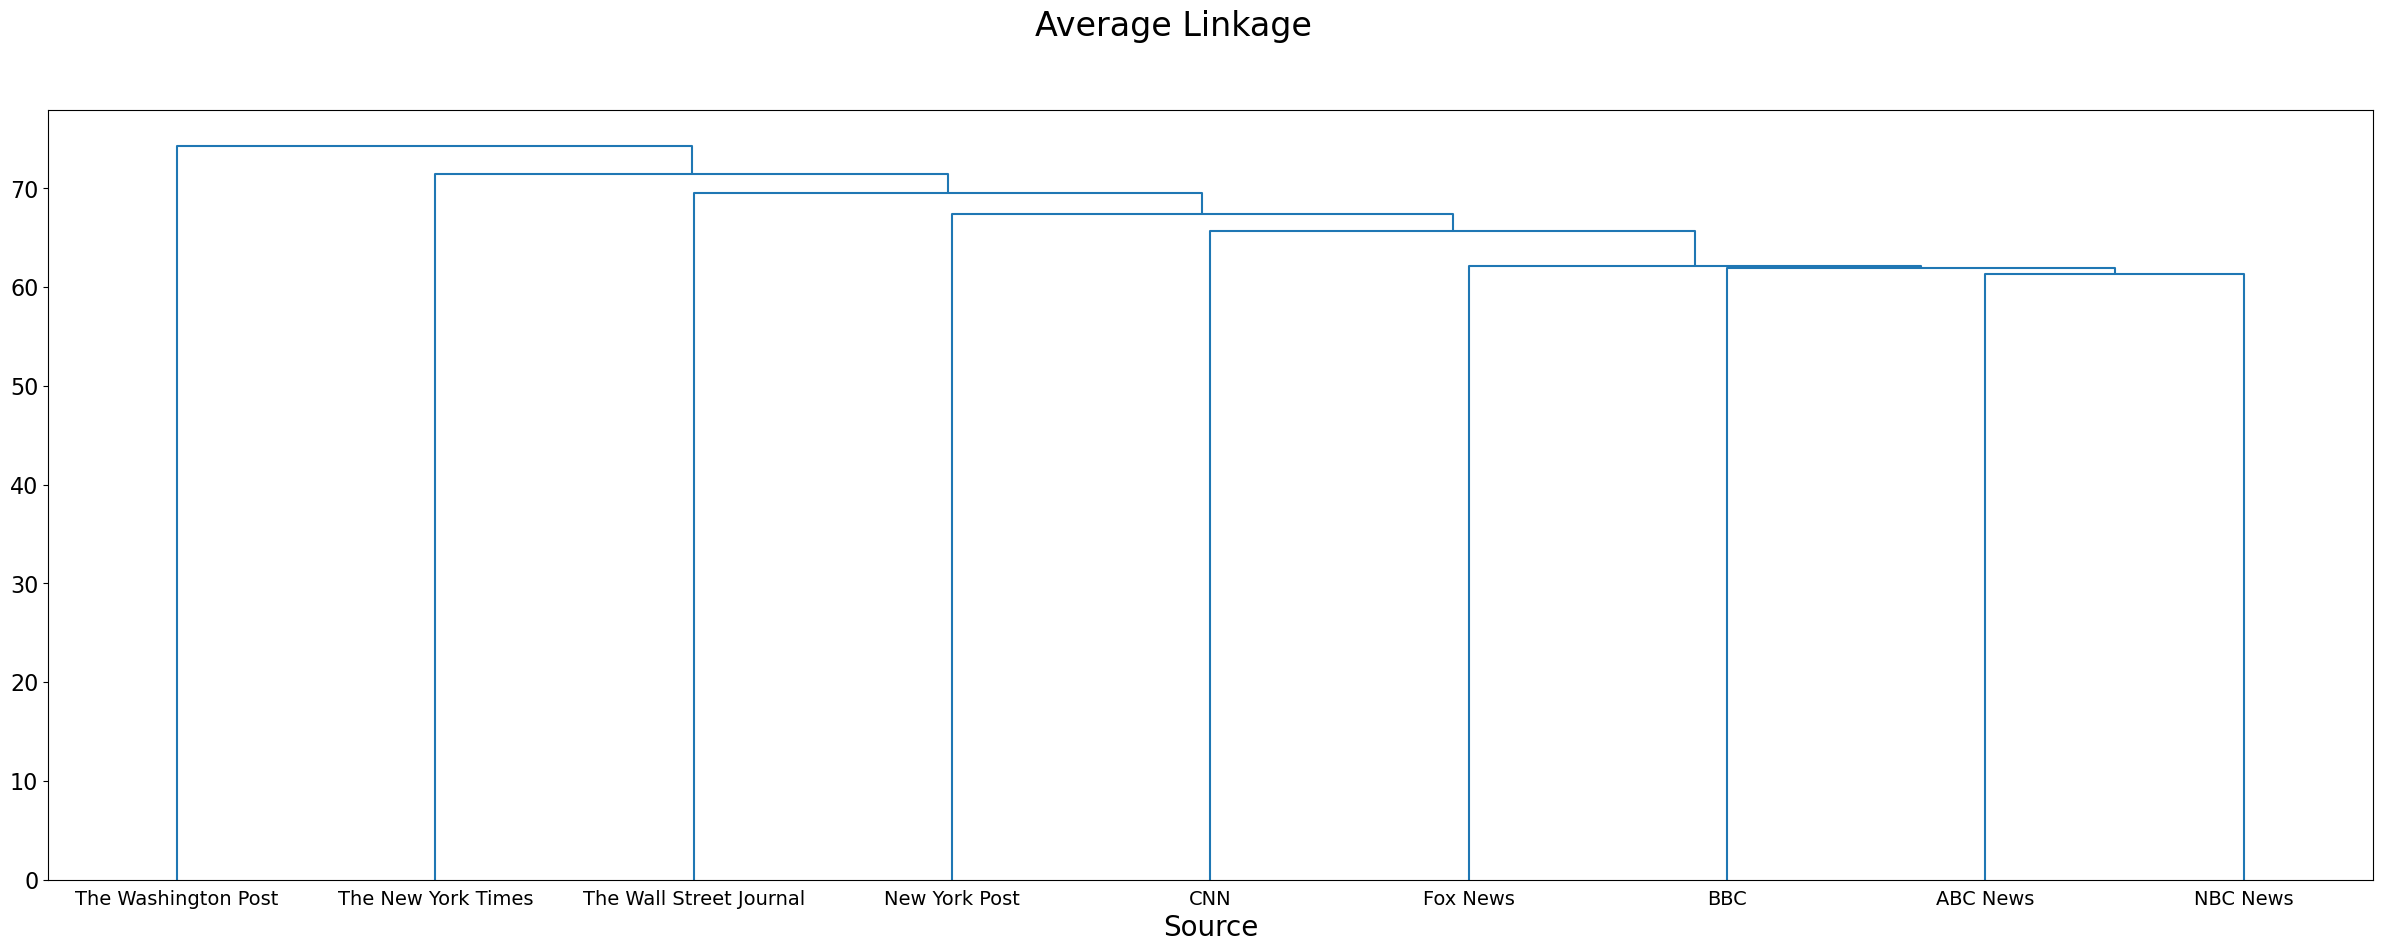

In [16]:
# create dendrogram with average linkage from tf_idf scores df, whose rows each represent one source

from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt

Z = linkage(tfidf_source_df, 'average')
fig = plt.figure(figsize=(30, 10))
fig.suptitle("Average Linkage", fontsize=24)
plt.xlabel('Source', fontsize=20)
plt.yticks(fontsize = 16) 
dn = dendrogram(Z, labels=tfidf_source_df.index)
plt.xticks(fontsize = 14)
plt.show()

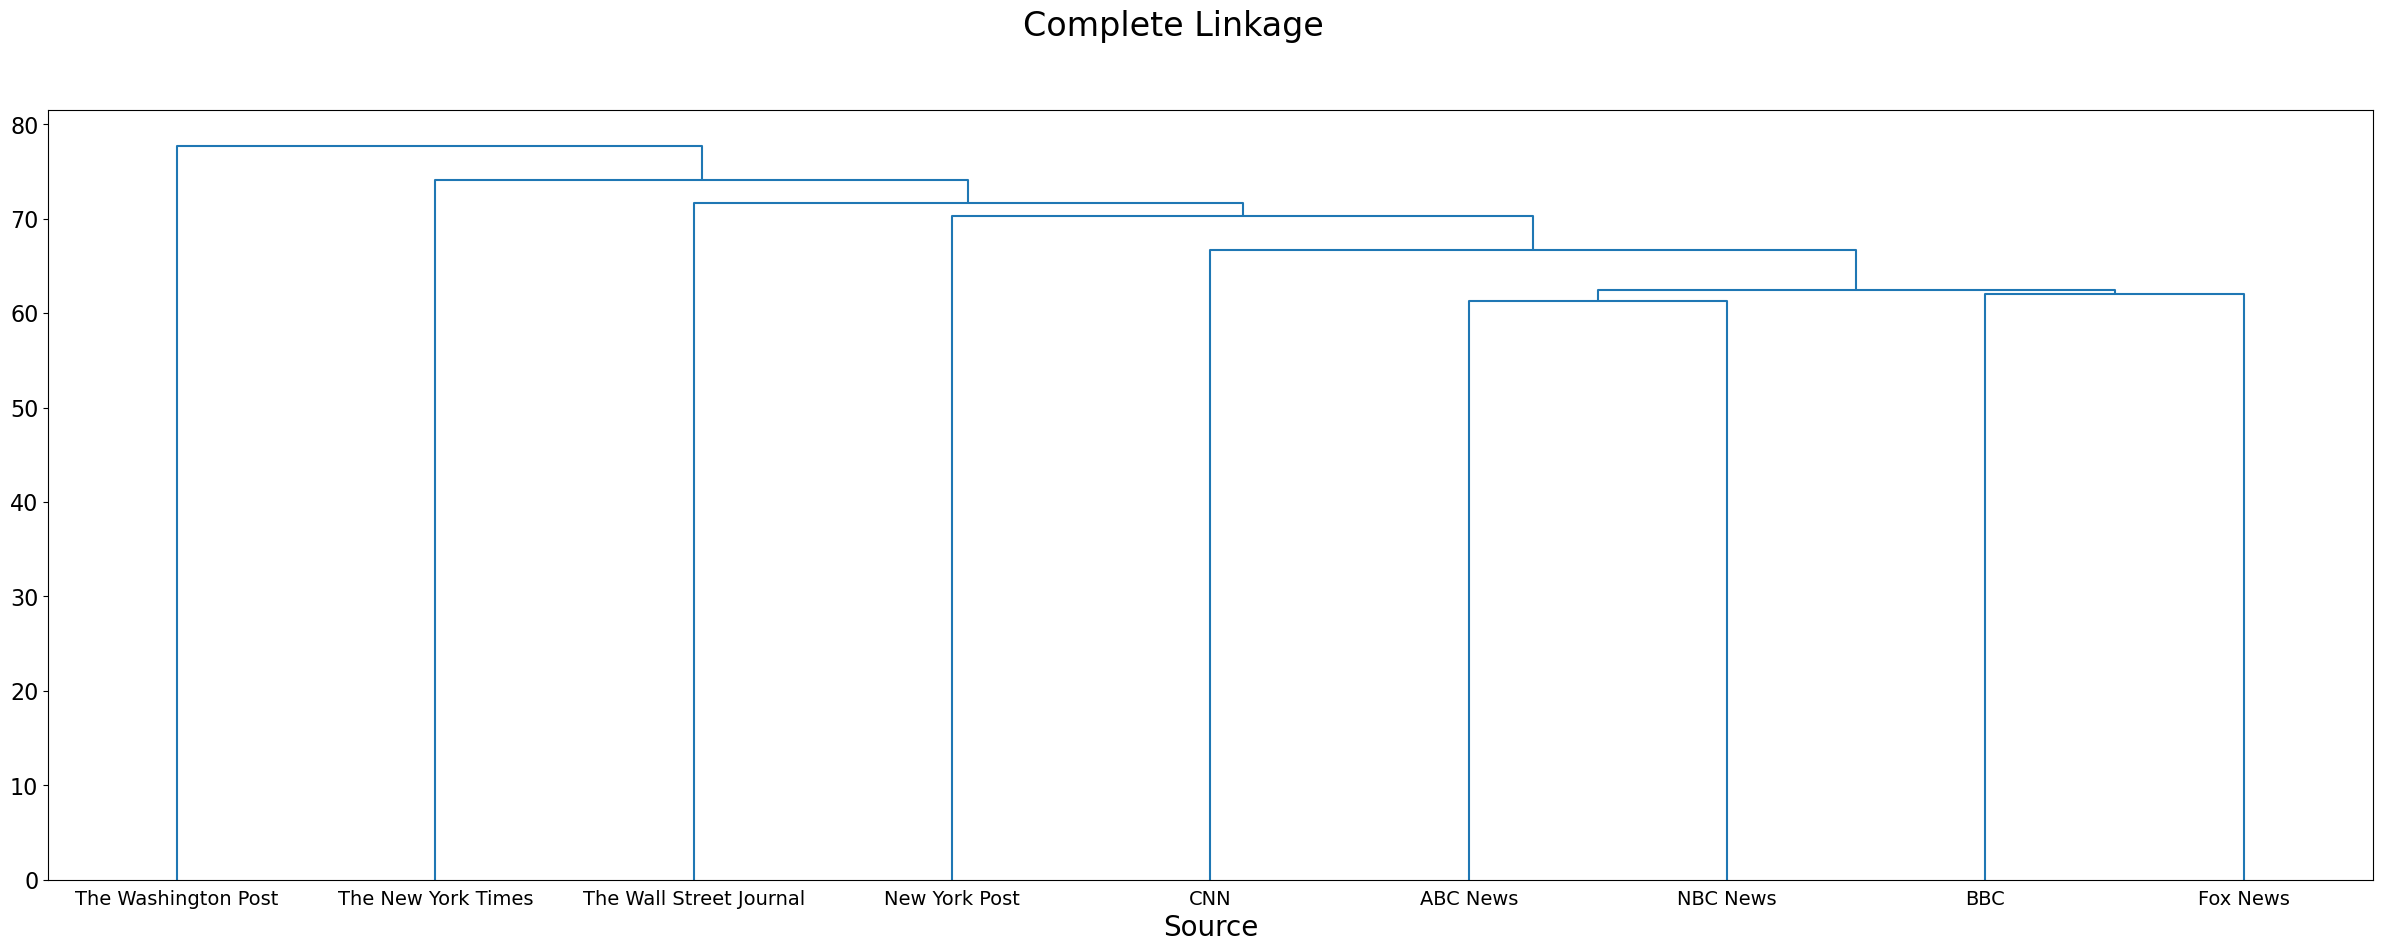

In [17]:
# create dendrogram with complete linkage from tf_idf scores df, whose rows each represent one source

Z = linkage(tfidf_source_df, 'complete')
fig = plt.figure(figsize=(30, 10))
fig.suptitle("Complete Linkage", fontsize=24)
plt.xlabel('Source', fontsize=20)
plt.yticks(fontsize = 16) 
dn = dendrogram(Z, labels=tfidf_source_df.index)
plt.xticks(fontsize = 14)
plt.show()

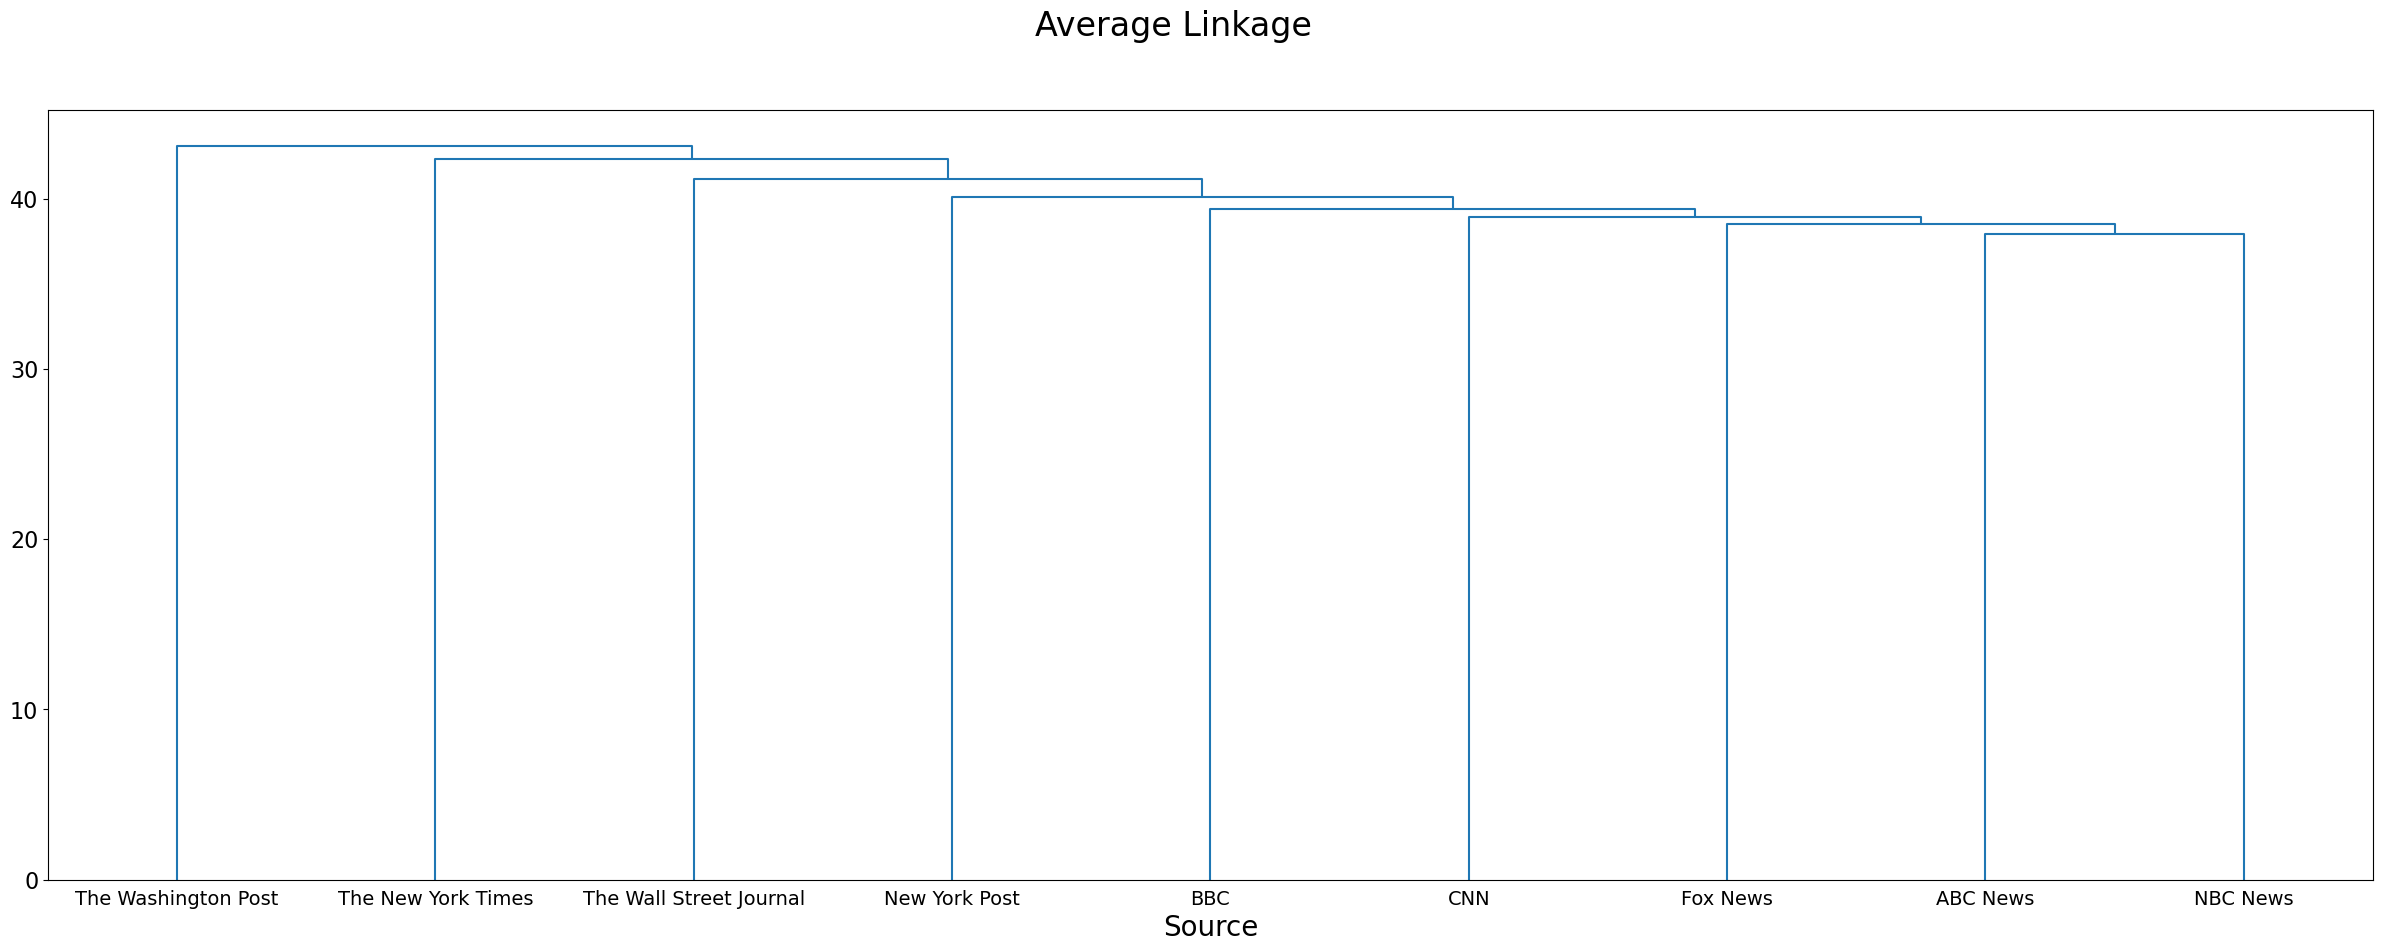

In [18]:
# create dendrogram with average linkage from binary scores df, whose rows each represent one source

Z = linkage(binary_source_df, 'average')
fig = plt.figure(figsize=(30, 10))
fig.suptitle("Average Linkage", fontsize=24)
plt.xlabel('Source', fontsize=20)
plt.yticks(fontsize = 16) 
dn = dendrogram(Z, labels=binary_source_df.index)
plt.xticks(fontsize = 14)
plt.show()

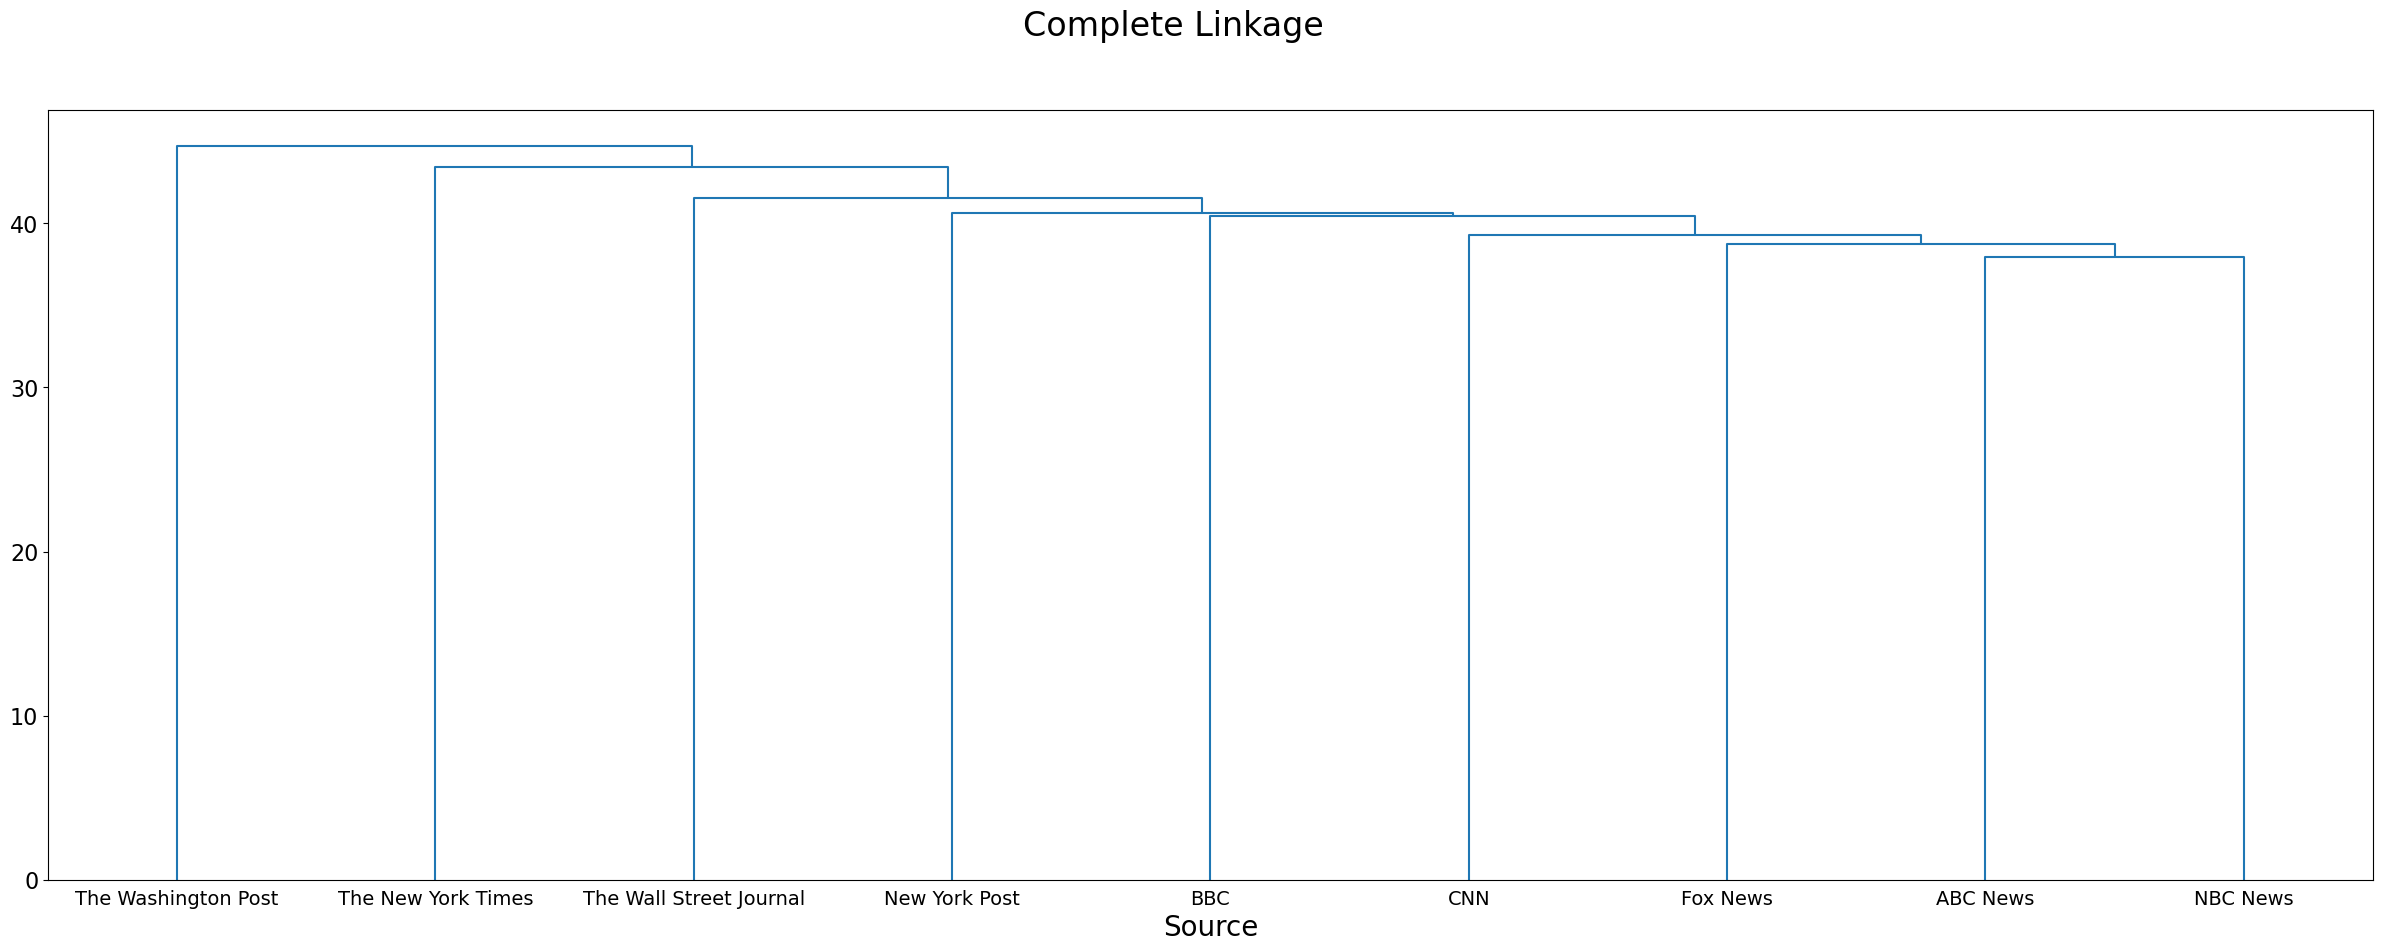

In [19]:
# create dendrogram with complete linkage from binary scores df, whose rows each represent one source

Z = linkage(binary_source_df, 'complete')
fig = plt.figure(figsize=(30, 10))
fig.suptitle("Complete Linkage", fontsize=24)
plt.xlabel('Source', fontsize=20)
plt.yticks(fontsize = 16) 
dn = dendrogram(Z, labels=binary_source_df.index)
plt.xticks(fontsize = 14)
plt.show()

In [20]:
# create dataframes, each containing articles of one topic for dendrograms for each topic

import warnings
warnings.filterwarnings('ignore')

affirm_tfidf_df = tfidf_df[tfidf_df['article_topic'] == "Supreme Court Ruling on Affirmative Action"]
affirm_tfidf_df.set_index('article_source', inplace=True)
affirm_tfidf_df.drop(['article_topic'], axis=1, inplace=True)

balloon_tfidf_df = tfidf_df[tfidf_df['article_topic'] == "Chinese Surveillance Balloon"]
balloon_tfidf_df.set_index('article_source', inplace=True)
balloon_tfidf_df.drop(['article_topic'], axis=1, inplace=True)

biden_tfidf_df = tfidf_df[tfidf_df['article_topic'] == "Biden's Low Approval Rates in Polls"]
biden_tfidf_df.set_index('article_source', inplace=True)
biden_tfidf_df.drop(['article_topic'], axis=1, inplace=True)

hamas_tfidf_df = tfidf_df[tfidf_df['article_topic'] == "The Deadliest Attack by Hamas"]
hamas_tfidf_df.set_index('article_source', inplace=True)
hamas_tfidf_df.drop(['article_topic'], axis=1, inplace=True)

pentagon_tfidf_df = tfidf_df[tfidf_df['article_topic'] == "Pentagon Documents Leak"]
pentagon_tfidf_df.set_index('article_source', inplace=True)
pentagon_tfidf_df.drop(['article_topic'], axis=1, inplace=True)

santos_tfidf_df = tfidf_df[tfidf_df['article_topic'] == "George Santos' Expulsion from Congress"]
santos_tfidf_df.set_index('article_source', inplace=True)
santos_tfidf_df.drop(['article_topic'], axis=1, inplace=True)

tanks_tfidf_df = tfidf_df[tfidf_df['article_topic'] == "U.S. and Germany Send Tanks to Ukraine"]
tanks_tfidf_df.set_index('article_source', inplace=True)
tanks_tfidf_df.drop(['article_topic'], axis=1, inplace=True)

trump_tfidf_df = tfidf_df[tfidf_df['article_topic'] == "Trump's Indictment"]
trump_tfidf_df.set_index('article_source', inplace=True)
trump_tfidf_df.drop(['article_topic'], axis=1, inplace=True)

In [21]:
affirm_tfidf_df.head()

,said,us,trump,biden,offici,mr,israel,presid,tank,hous,...,squelch,market,messr,overlap,vs,convert,marku,schreiber,riski,extort
article_source,,,,,,,,,,,,,,,,,,,,,
ABC News,1.827036,1.839130,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
BBC,2.379087,2.618776,1.326871,0.869038,0.0,2.295628,0.0,2.057431,0.0,0.891998,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CNN,2.641434,2.151624,2.784588,0.000000,0.0,0.000000,0.0,1.334974,0.0,0.891998,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Fox News,1.827036,1.304918,0.000000,0.869038,0.0,0.000000,0.0,0.788457,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
NBC News,2.156116,1.617412,2.246588,2.073780,0.0,0.000000,0.0,1.881491,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


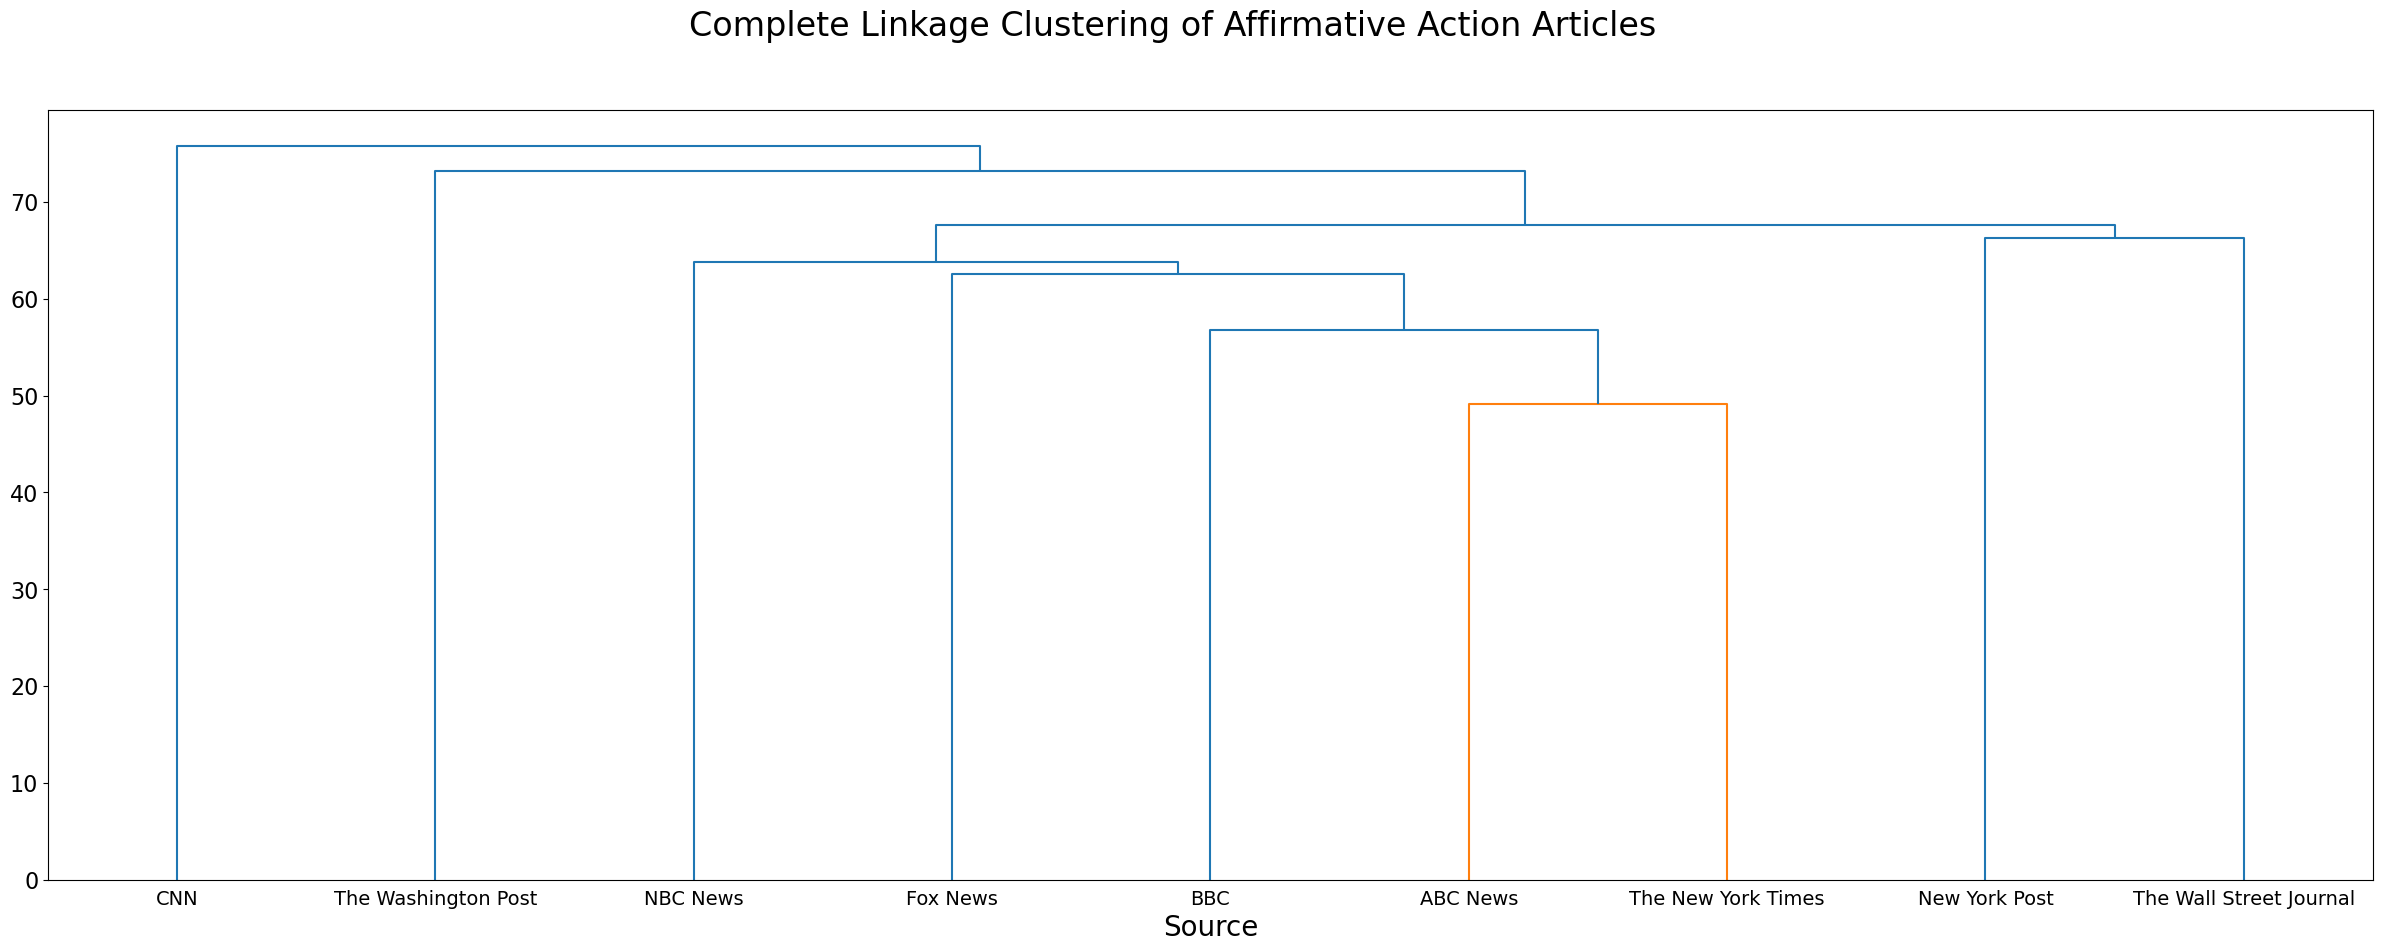

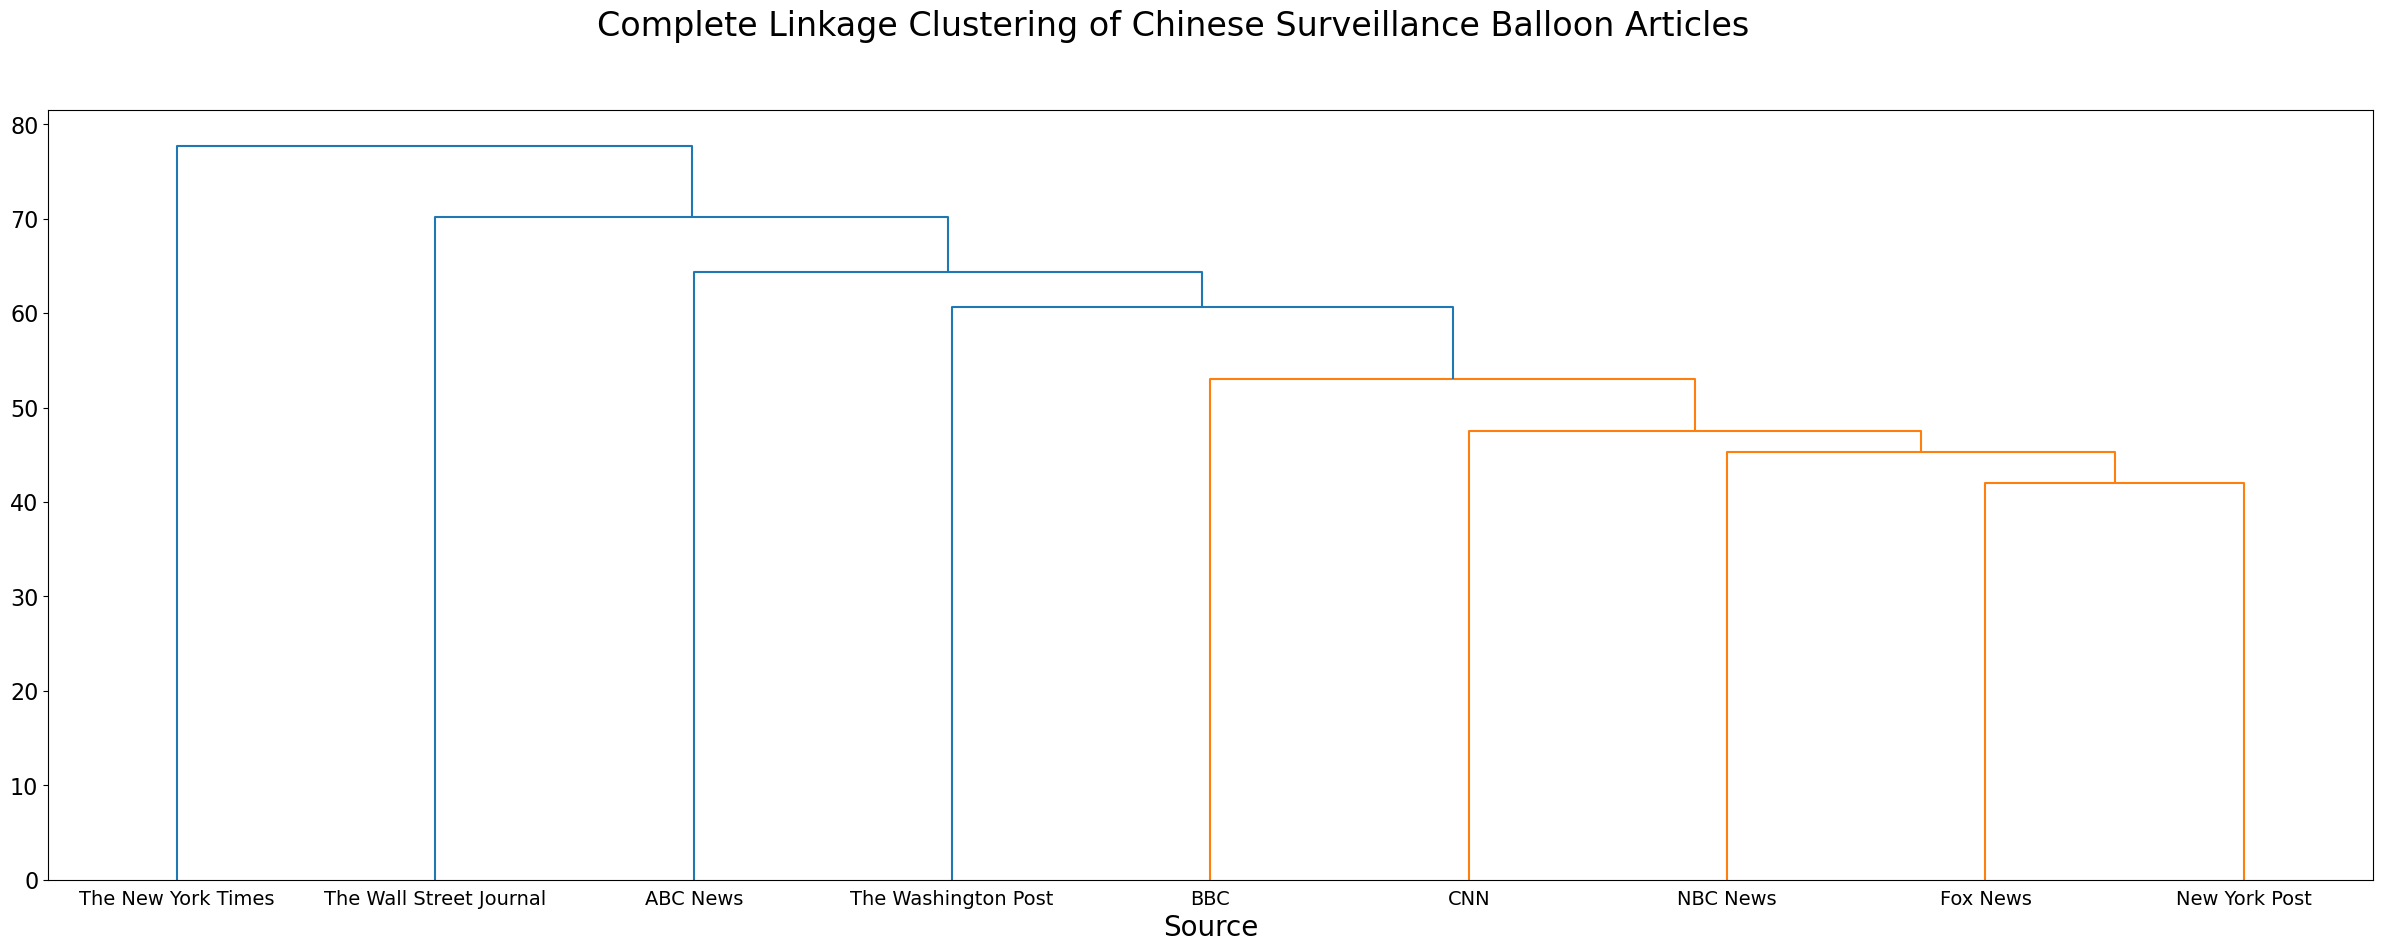

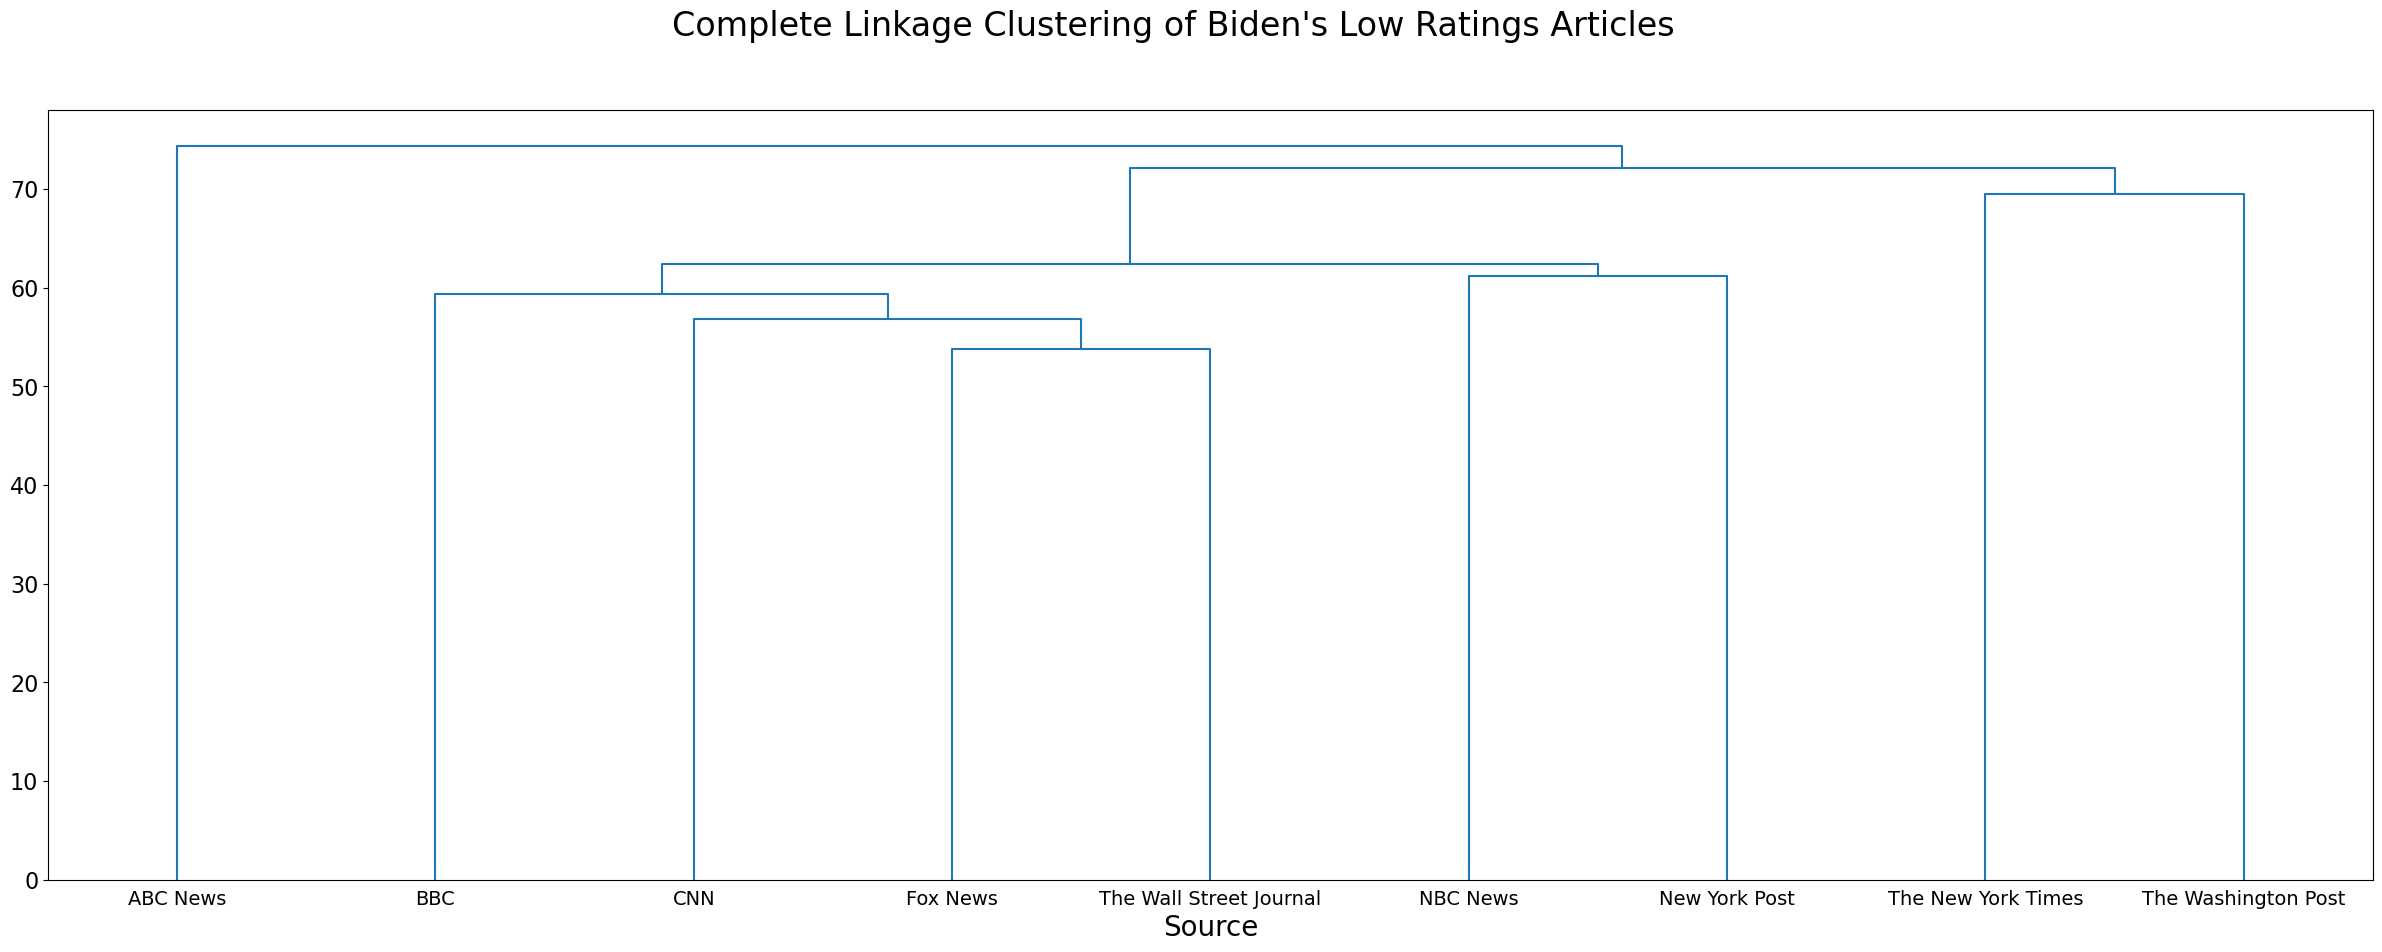

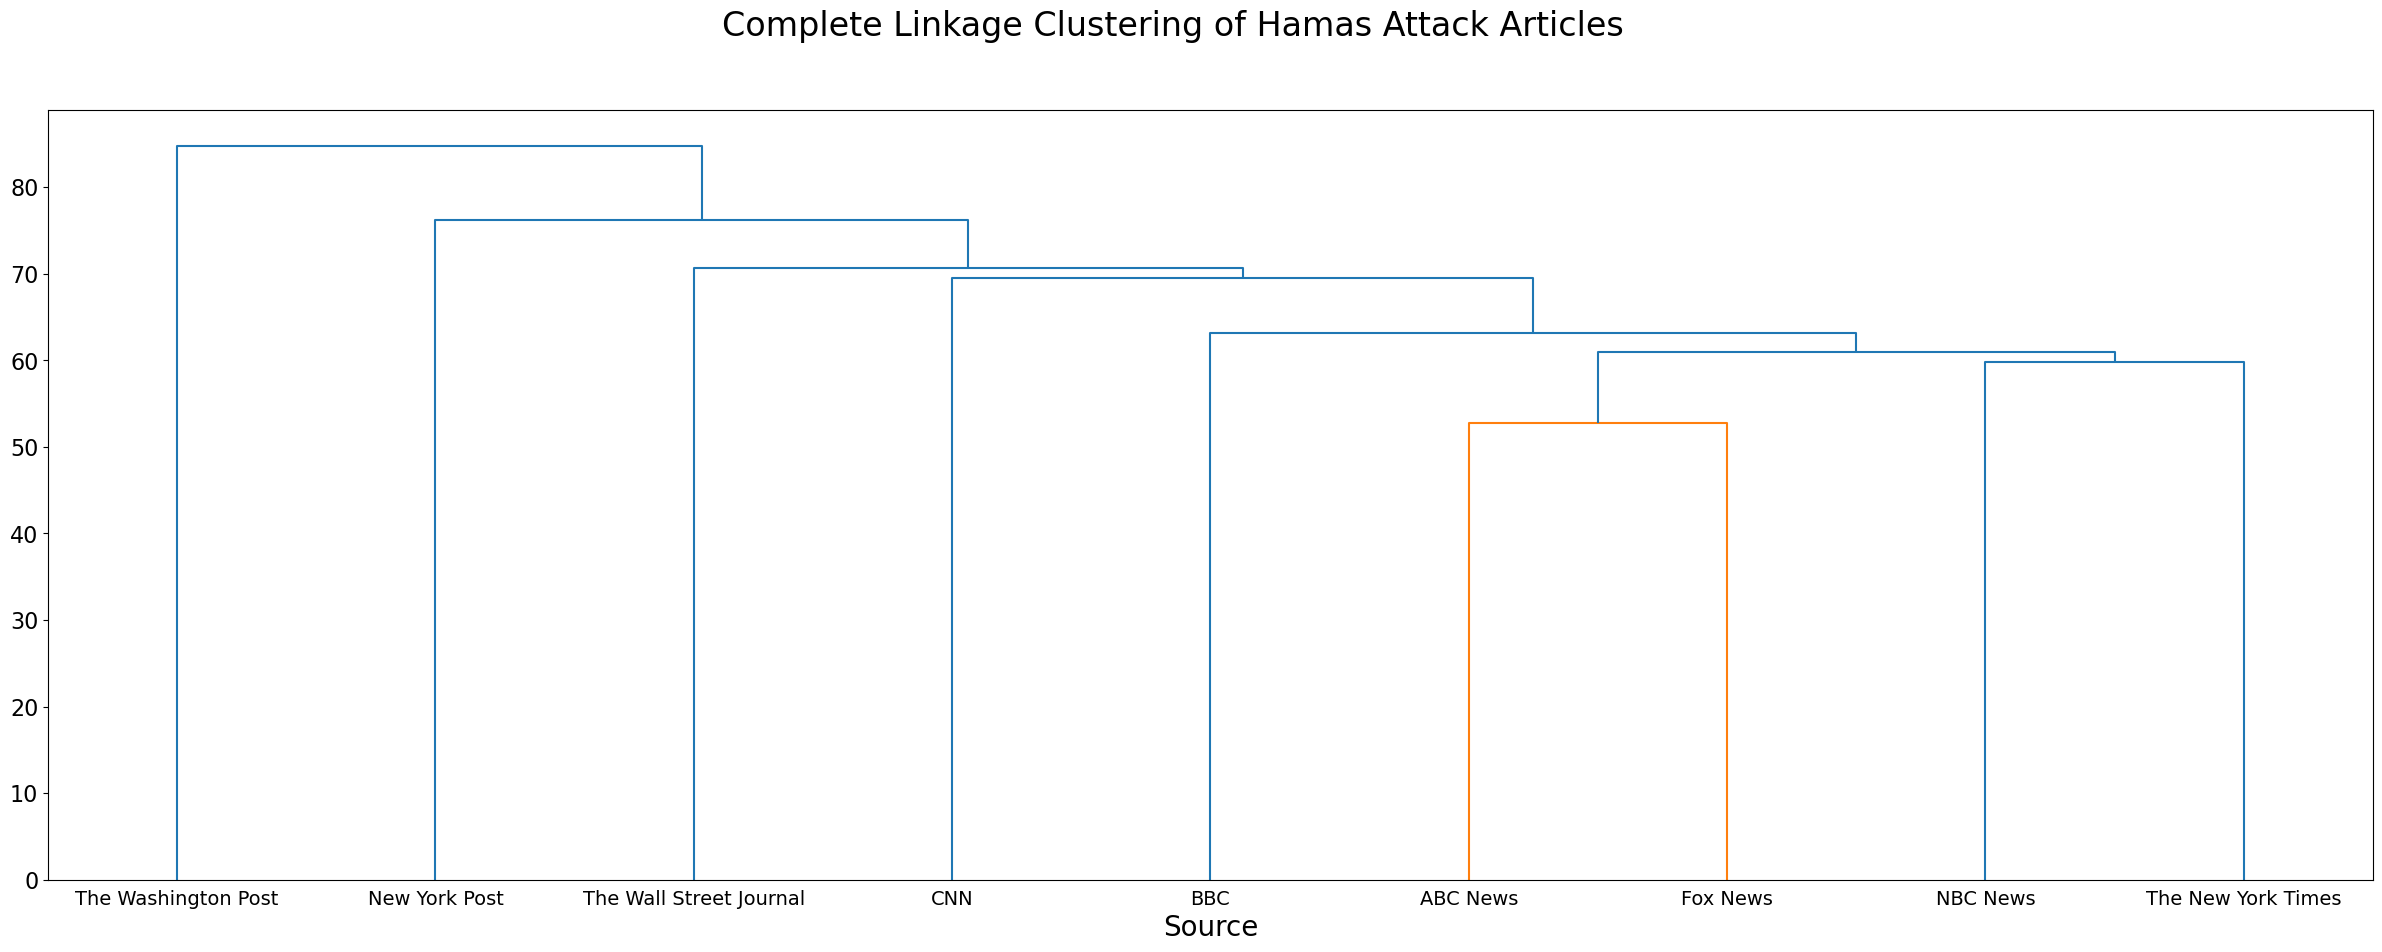

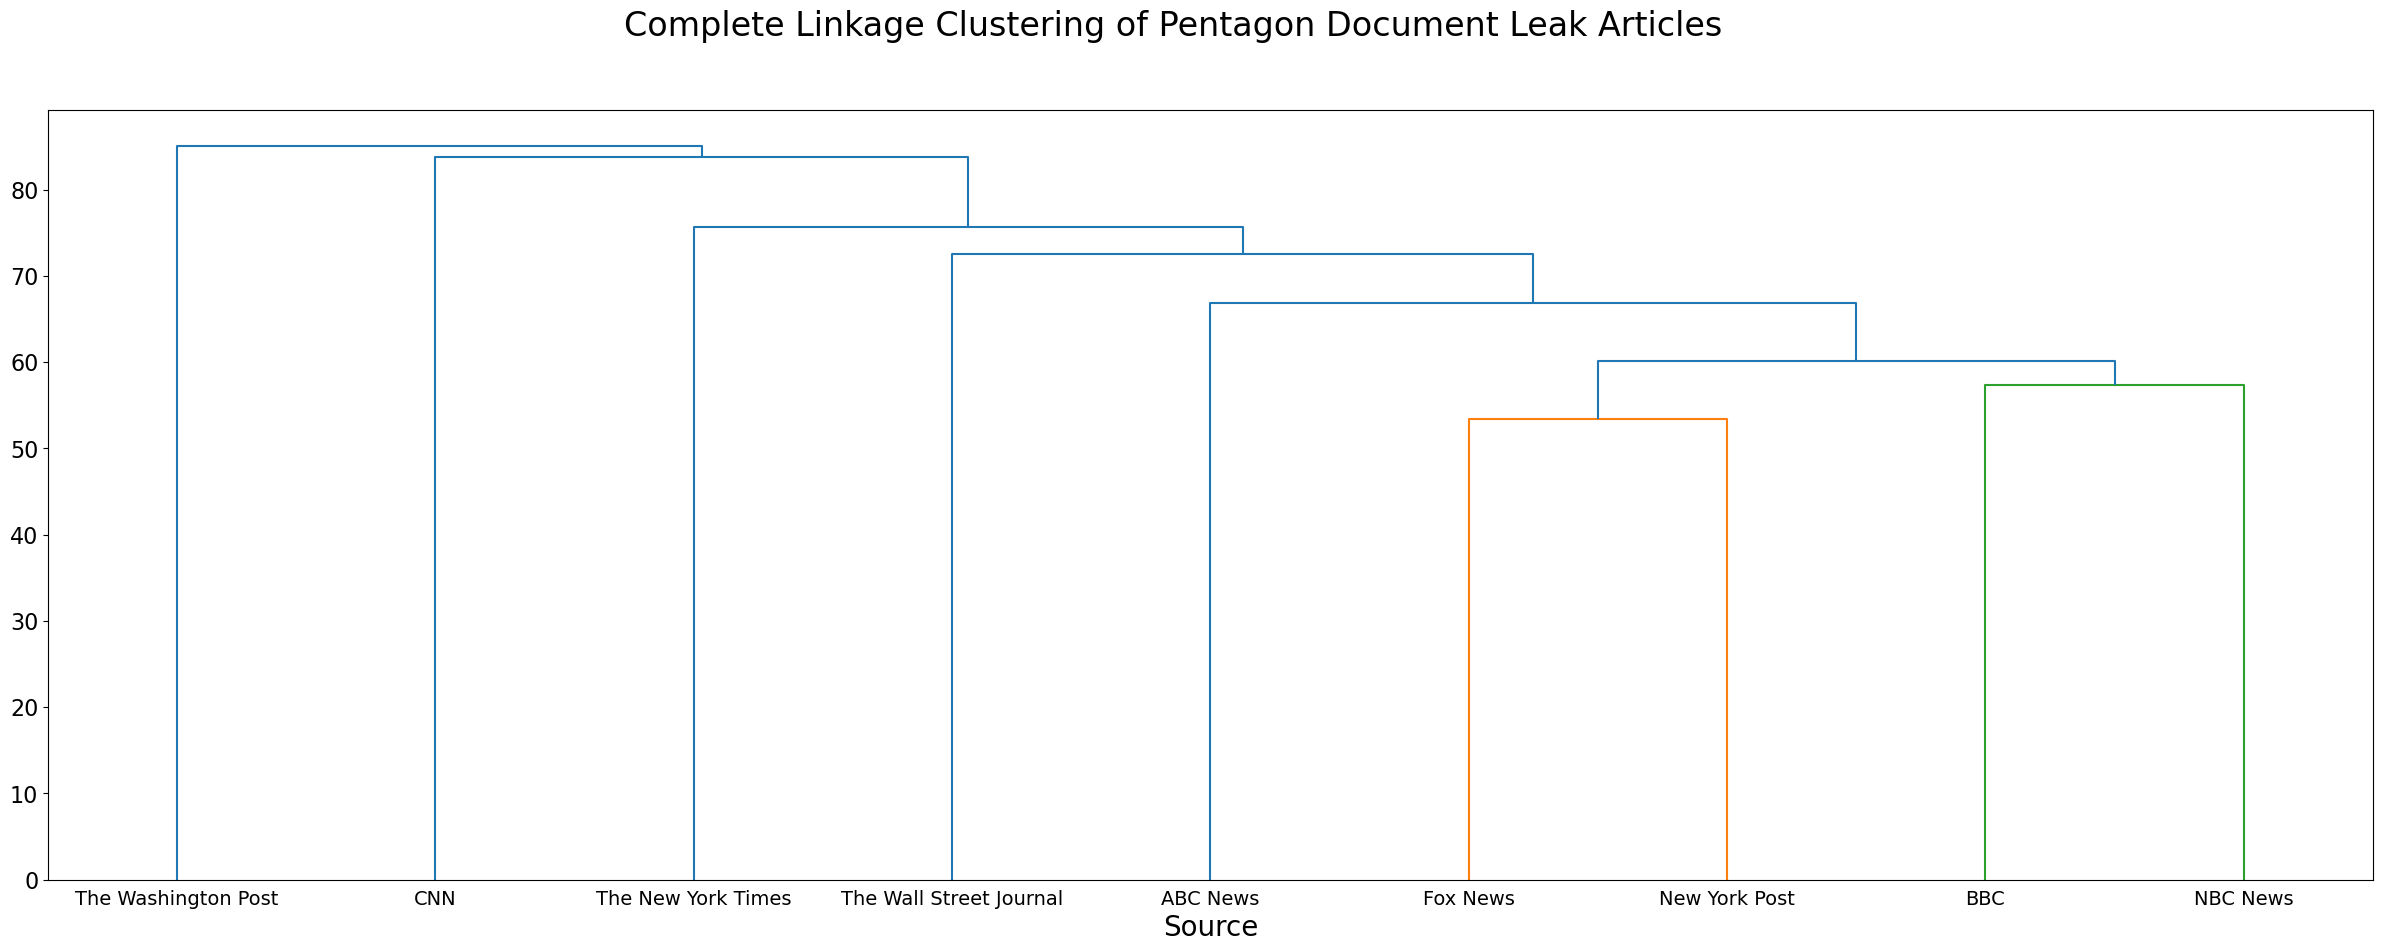

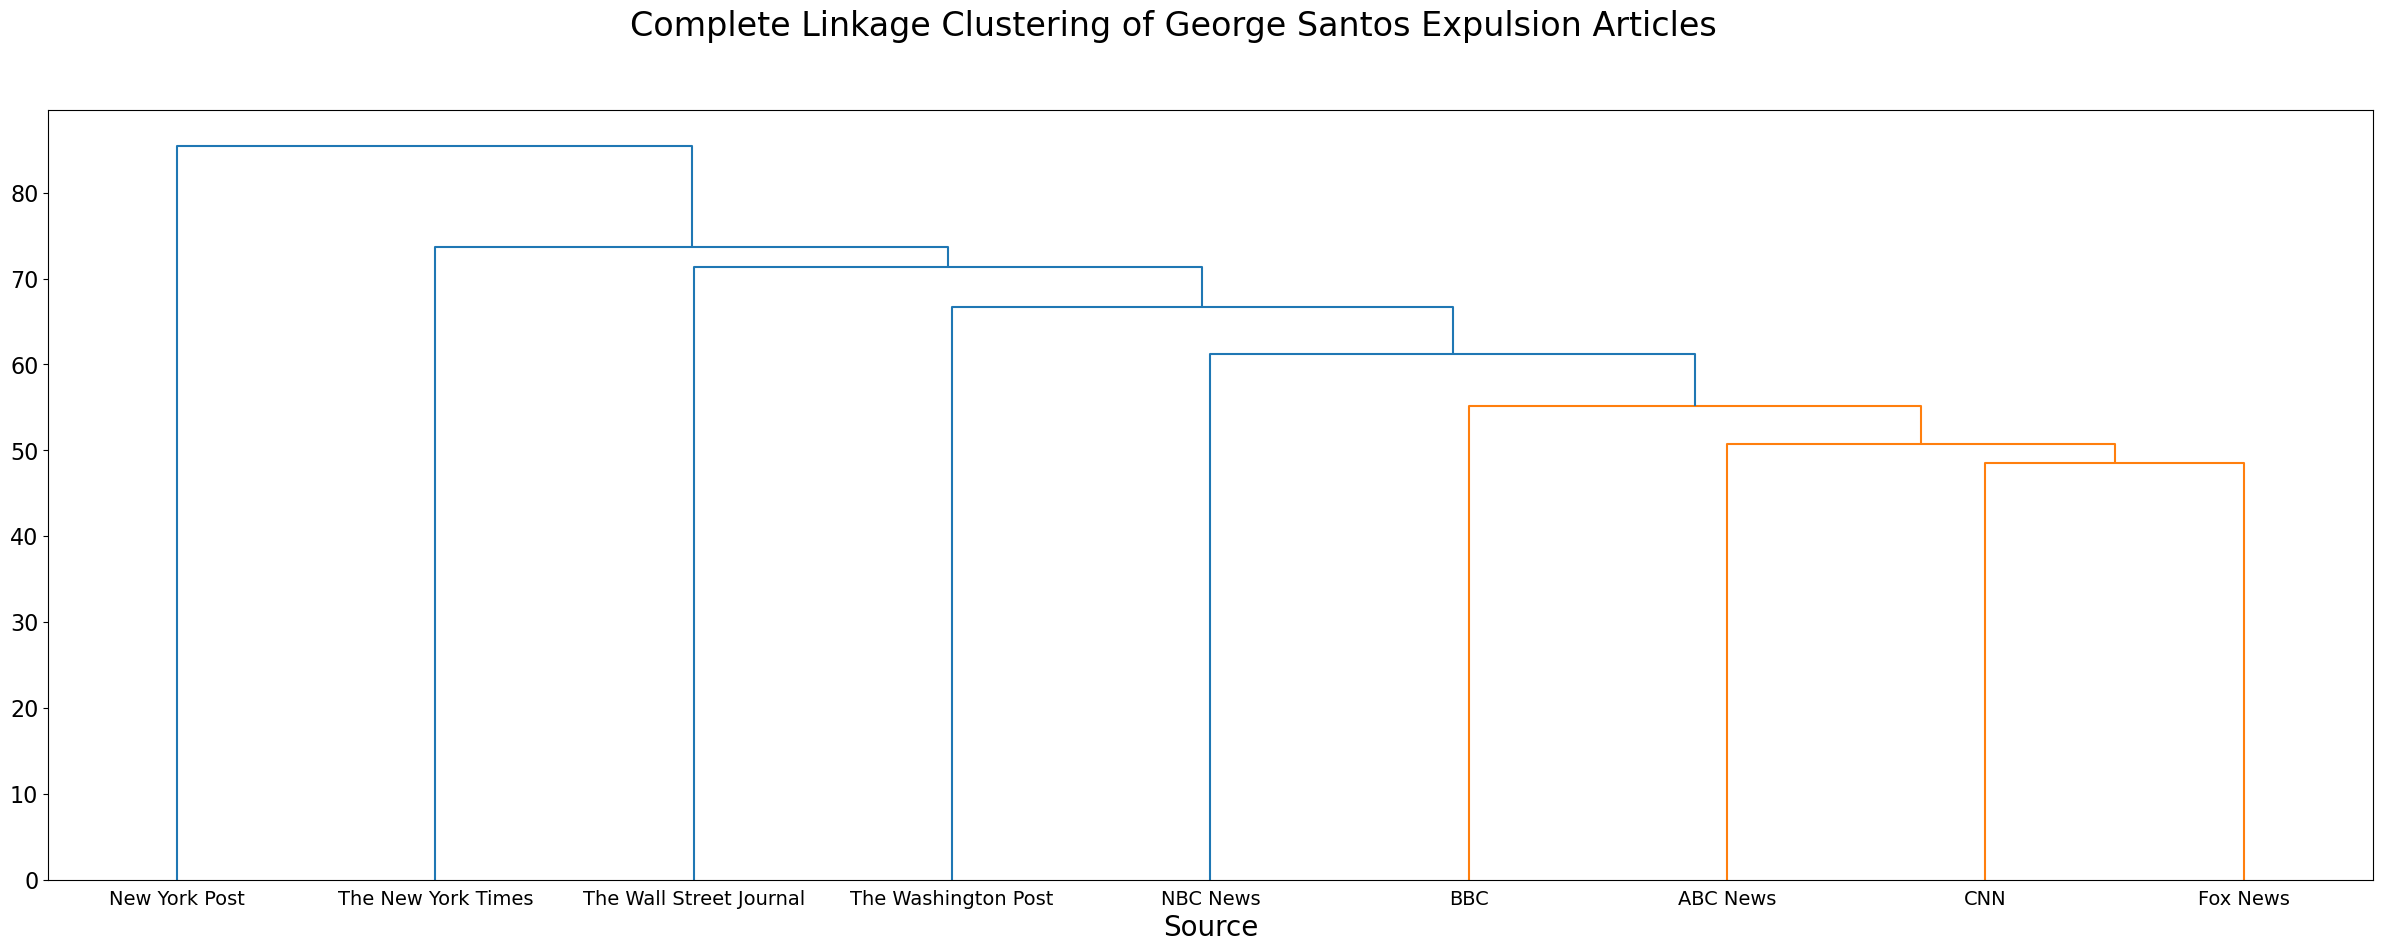

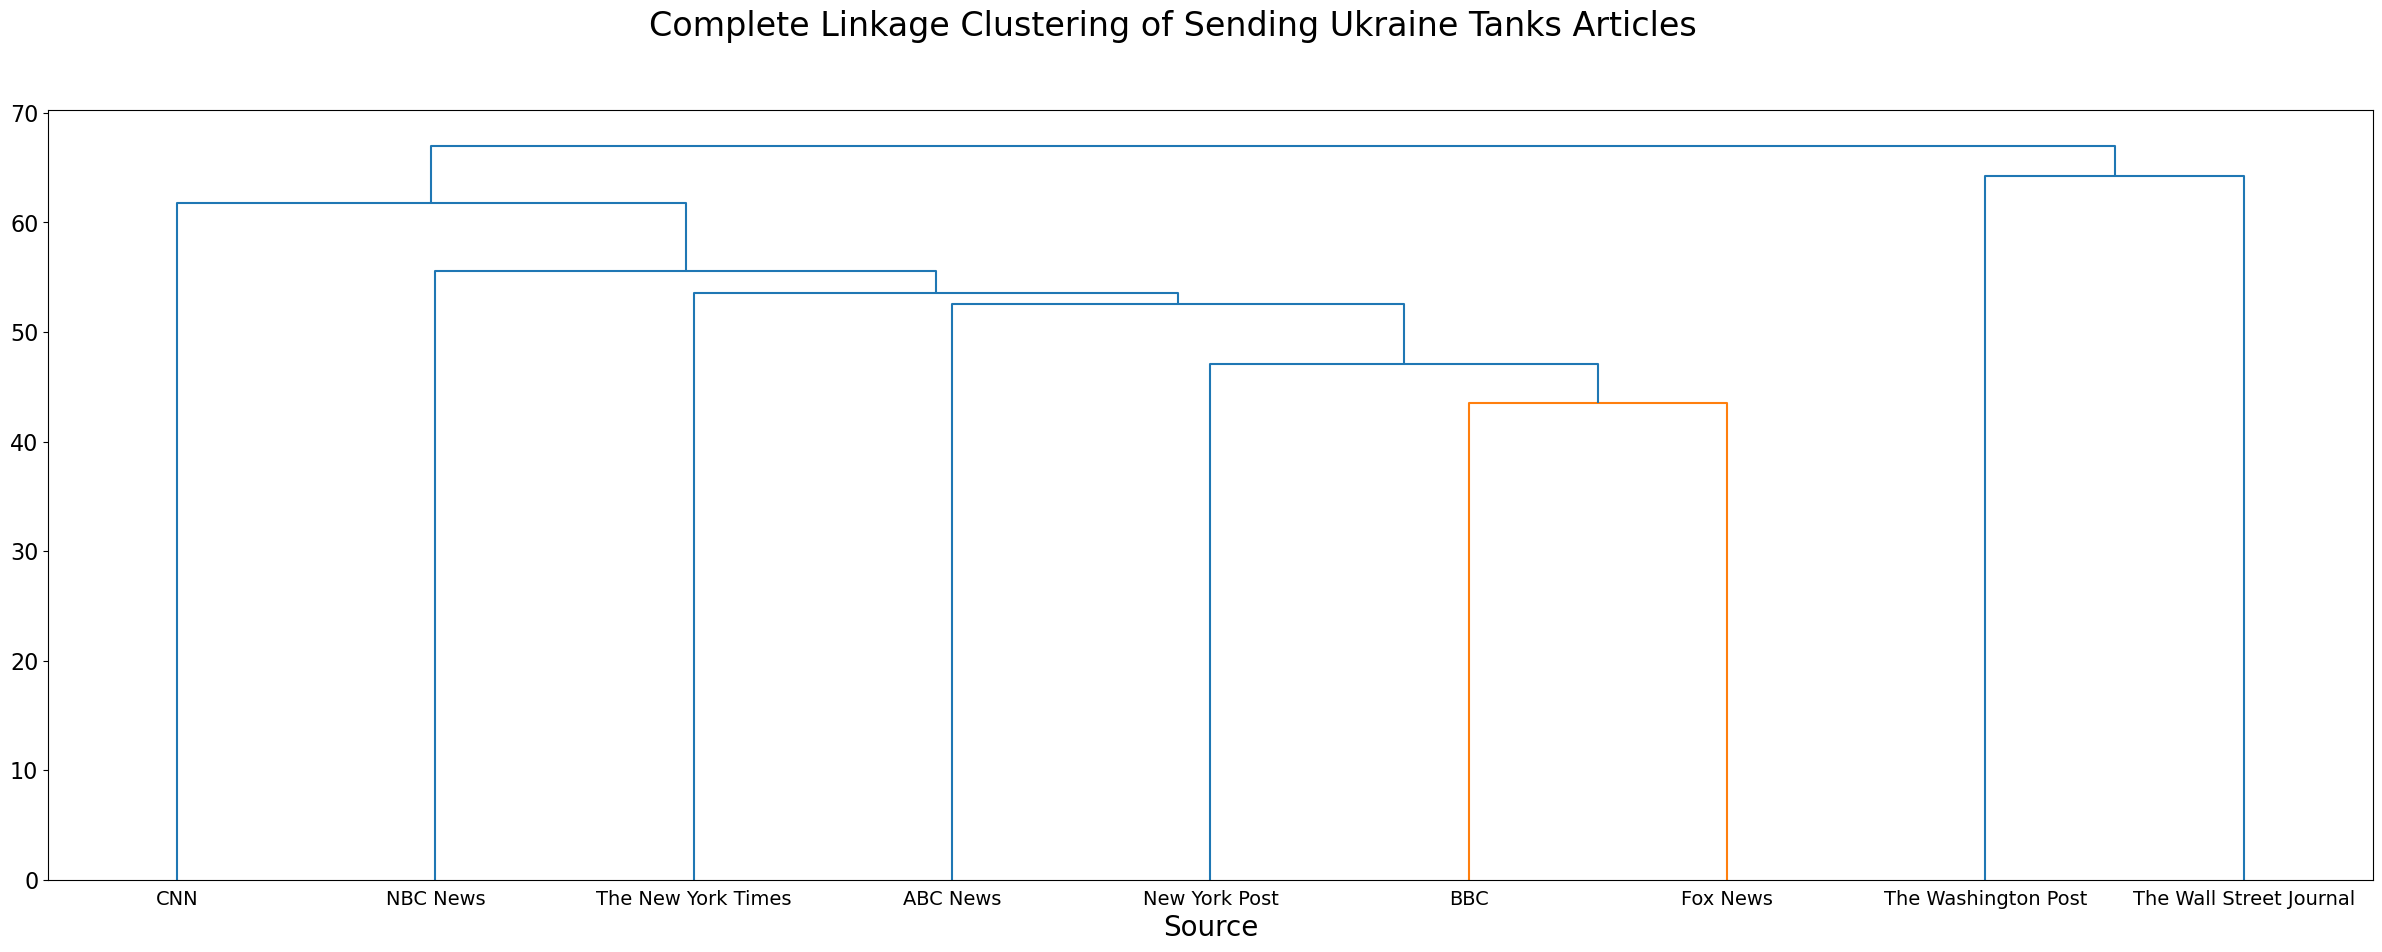

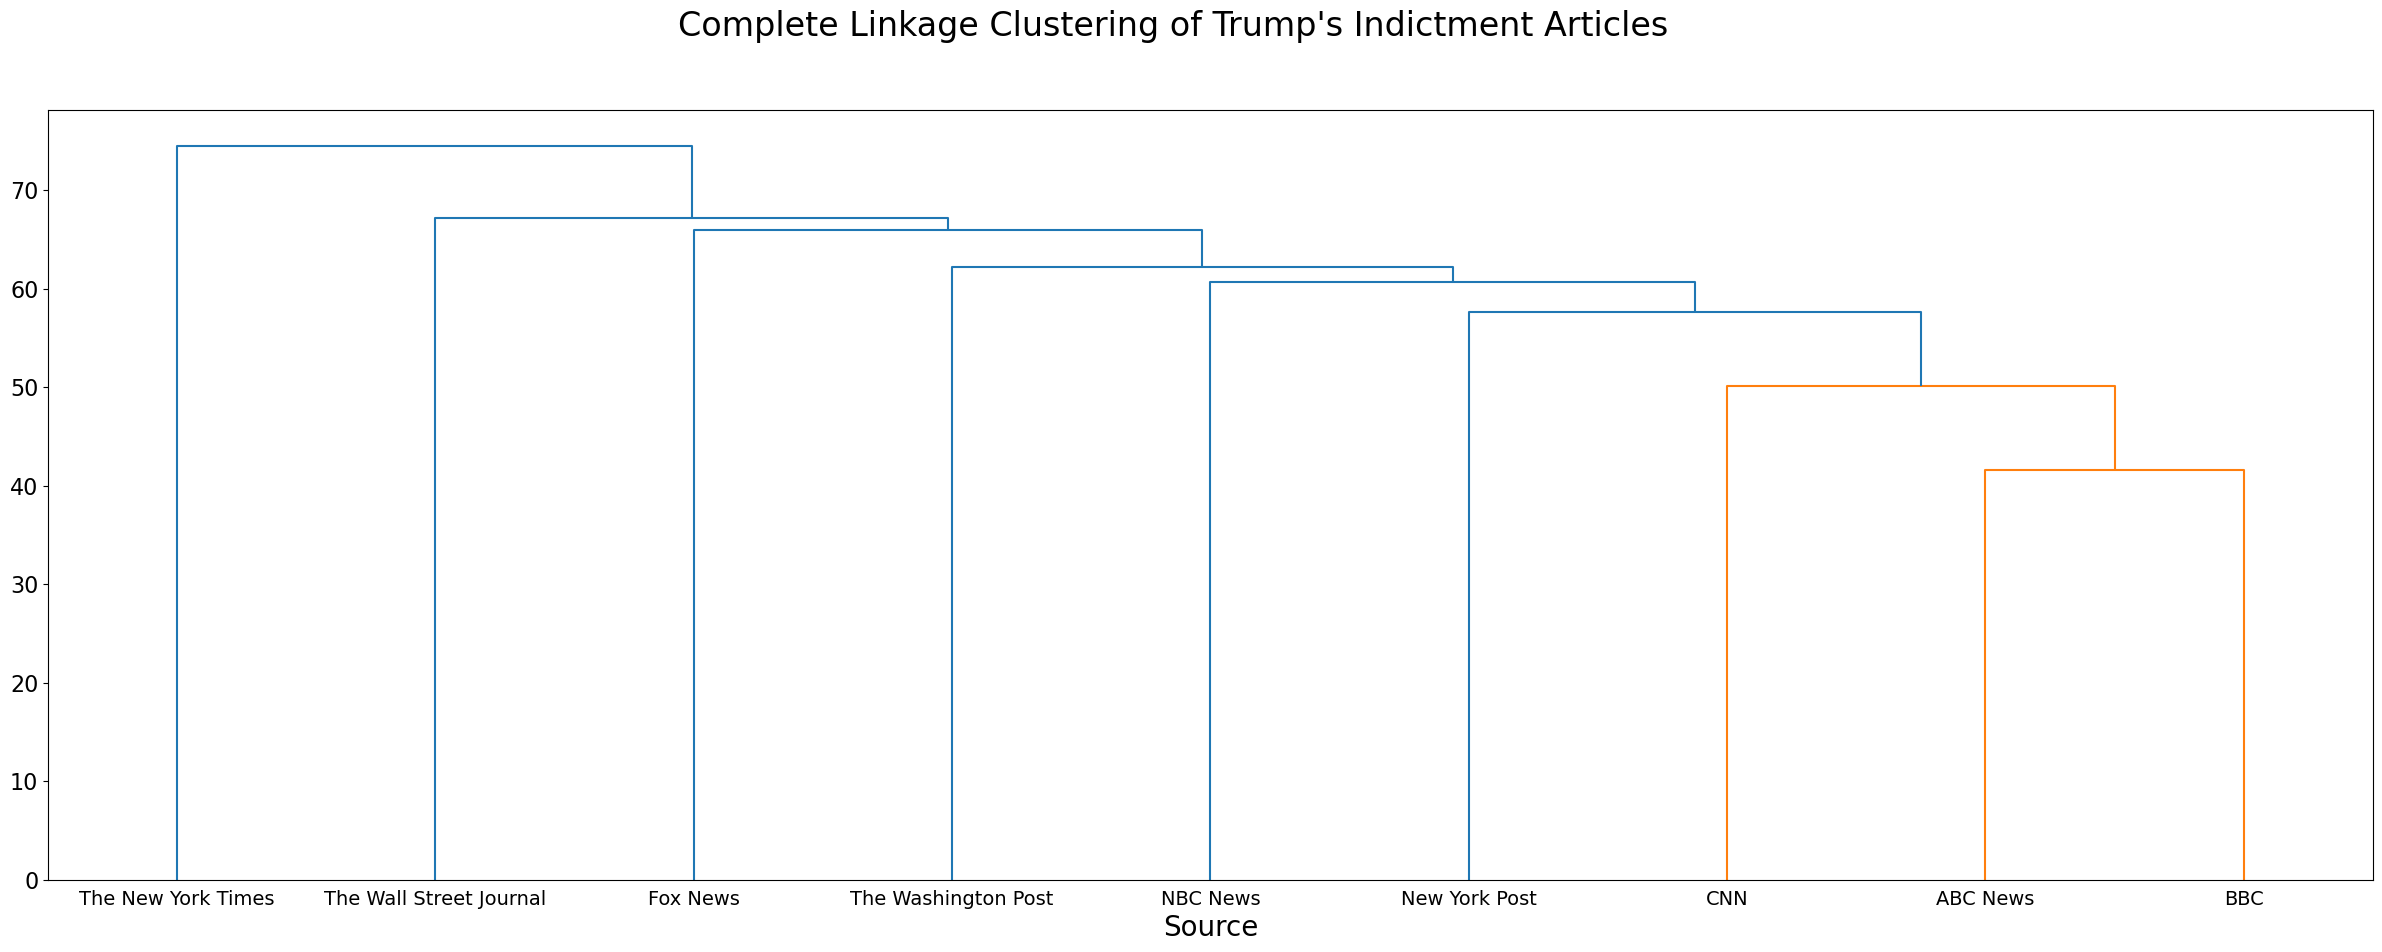

In [22]:
# create dendrograms with complete linkage from tfidf scores df's, each one representing articles about a topic

Z = linkage(affirm_tfidf_df, 'complete')
fig = plt.figure(figsize=(30, 10))
fig.suptitle("Complete Linkage Clustering of Affirmative Action Articles", fontsize=24)
plt.xlabel('Source', fontsize=20)
plt.yticks(fontsize = 16) 
dn = dendrogram(Z, labels=affirm_tfidf_df.index)
plt.xticks(fontsize = 14)
plt.show()

Z = linkage(balloon_tfidf_df, 'complete')
fig = plt.figure(figsize=(30, 10))
fig.suptitle("Complete Linkage Clustering of Chinese Surveillance Balloon Articles", fontsize=24)
plt.xlabel('Source', fontsize=20)
plt.yticks(fontsize = 16) 
dn = dendrogram(Z, labels=balloon_tfidf_df.index)
plt.xticks(fontsize = 14)
plt.show()

Z = linkage(biden_tfidf_df, 'complete')
fig = plt.figure(figsize=(30, 10))
fig.suptitle("Complete Linkage Clustering of Biden's Low Ratings Articles", fontsize=24)
plt.xlabel('Source', fontsize=20)
plt.yticks(fontsize = 16) 
dn = dendrogram(Z, labels=biden_tfidf_df.index)
plt.xticks(fontsize = 14)
plt.show()

Z = linkage(hamas_tfidf_df, 'complete')
fig = plt.figure(figsize=(30, 10))
fig.suptitle("Complete Linkage Clustering of Hamas Attack Articles", fontsize=24)
plt.xlabel('Source', fontsize=20)
plt.yticks(fontsize = 16) 
dn = dendrogram(Z, labels=hamas_tfidf_df.index)
plt.xticks(fontsize = 14)
plt.show()

Z = linkage(pentagon_tfidf_df, 'complete')
fig = plt.figure(figsize=(30, 10))
fig.suptitle("Complete Linkage Clustering of Pentagon Document Leak Articles", fontsize=24)
plt.xlabel('Source', fontsize=20)
plt.yticks(fontsize = 16) 
dn = dendrogram(Z, labels=pentagon_tfidf_df.index)
plt.xticks(fontsize = 14)
plt.show()

Z = linkage(santos_tfidf_df, 'complete')
fig = plt.figure(figsize=(30, 10))
fig.suptitle("Complete Linkage Clustering of George Santos Expulsion Articles", fontsize=24)
plt.xlabel('Source', fontsize=20)
plt.yticks(fontsize = 16) 
dn = dendrogram(Z, labels=santos_tfidf_df.index)
plt.xticks(fontsize = 14)
plt.show()

Z = linkage(tanks_tfidf_df, 'complete')
fig = plt.figure(figsize=(30, 10))
fig.suptitle("Complete Linkage Clustering of Sending Ukraine Tanks Articles", fontsize=24)
plt.xlabel('Source', fontsize=20)
plt.yticks(fontsize = 16) 
dn = dendrogram(Z, labels=tanks_tfidf_df.index)
plt.xticks(fontsize = 14)
plt.show()

Z = linkage(trump_tfidf_df, 'complete')
fig = plt.figure(figsize=(30, 10))
fig.suptitle("Complete Linkage Clustering of Trump's Indictment Articles", fontsize=24)
plt.xlabel('Source', fontsize=20)
plt.yticks(fontsize = 16) 
dn = dendrogram(Z, labels=trump_tfidf_df.index)
plt.xticks(fontsize = 14)
plt.show()

In [23]:
def create_wordcloud(text, title):
    '''Given a string of all text and a string
    for the title, creates a wordcloud.'''
    plt.figure(figsize = (20,10))
    wc = WordCloud(colormap = "YlOrRd", background_color='white', width=1600, height=800, max_font_size = 400).generate(text)
    plt.title(title, fontsize=40)
    plt.axis("off")
    title_snake = title.lower().replace(" ", "_")
    wc.to_file(f'wordcloud_{title_snake}.png')
    #plt.savefig(f'wordcloud_{title_snake}.png', dpi = 1000)
    plt.tight_layout(pad=0)
    plt.imshow(wc)

In [24]:
#for i in range(len(source_docs)):
#    create_wordcloud(source_docs[i], tfidf_source_df.index[i])
    

In [25]:
# create a list of unstemmed article document texts
# looping through all text files to apply preprocessing functions
article_docs_unstemmed = []
dir = os.listdir('data/text/')
dir.sort()
for filename in dir:
    filepath = os.path.join('data/text/', filename)
    if filename.split(".")[-1] == "txt":
        article_string = file_to_string(filepath)
        new_string = clean_text(article_string, 0)
        article_docs_unstemmed.append(new_string)

article_docs_unstemmed

['supreme court thursday set new limits affirmative action programs cases involving whether public private colleges universities continue use race one factor among many student admissions court held opinion conservative majority written chief justice john roberts harvard unc admissions programs violate equal protection clause fourteenth amendment vote unc case harvard case due recusal justice ketanji brown jackson jackson served board overseers harvard earned undergraduate law degrees jackson justice sonia sotomayor justice elena kagan dissented two cases court said blockbuster cases put affirmative action used decades colleges universities address inequality diversify campuses spotlight supreme court repeatedly ruled since schools may consider race applicants pursuing educational benefits diverse student body long one factor among many considered schools use quota system students fair admissions conservative group sued harvard university university north carolina race conscious admiss

In [26]:
# investigating why Fox News has Trump as most frequent word, to see if it's related to length of article 

trump_article_lengths = []
trump_word_counts = []

print("Source", "|", "Trump Article Length", "|", "Trump Word Count")
i = 1
for article in article_docs_unstemmed:
    if i%8 == 0:
        trump_count = 0
        for word in article.split():
            if word == "trump":
                trump_count += 1
        trump_word_counts.append(trump_count)
        article_length = len(article.split())
        trump_article_lengths.append(article_length)
        print(article.split()[-2], "|", article_length, "|", trump_count)
    i += 1

# let's do the same for the word "biden" in the biden articles and see if there are outliers 

biden_article_lengths = []
biden_word_counts = []

print("Source", "|", "Biden Article Length", "|", "Biden Word Count")
i = 1
for article in article_docs_unstemmed:
    if article.split()[-1] == "bidenarticle":
        biden_count = 0
        for word in article.split():
            if word == "biden":
                biden_count += 1
        biden_word_counts.append(biden_count)
        article_length = len(article.split())
        biden_article_lengths.append(article_length)
        print(article.split()[-2], "|", article_length, "|", biden_count)
    i += 1



Source | Trump Article Length | Trump Word Count
abcarticle | 305 | 20
bbcarticle | 504 | 26
cnnarticle | 653 | 24
foxarticle | 1062 | 58
nbcarticle | 959 | 36
nyparticle | 927 | 36
nytarticle | 1142 | 35
wparticle | 902 | 34
wsjarticle | 1094 | 38
Source | Biden Article Length | Biden Word Count
abcarticle | 834 | 27
bbcarticle | 396 | 6
cnnarticle | 521 | 11
foxarticle | 406 | 19
nbcarticle | 565 | 11
nyparticle | 545 | 12
nytarticle | 920 | 30
wparticle | 911 | 32
wsjarticle | 404 | 10


In [27]:
# create a df with sources, their trump article lengths, and the frequency of the word "trump"

trump_words = pd.DataFrame(columns=['source', 'article_length', 'trump_word_count'])
trump_words['source'] = tfidf_source_df.index
trump_words['article_length'] = trump_article_lengths
trump_words['trump_word_count'] = trump_word_counts
trump_words

biden_words = pd.DataFrame(columns=['source', 'article_length', 'biden_word_count'])
biden_words['source'] = tfidf_source_df.index
biden_words['article_length'] = biden_article_lengths
biden_words['biden_word_count'] = biden_word_counts


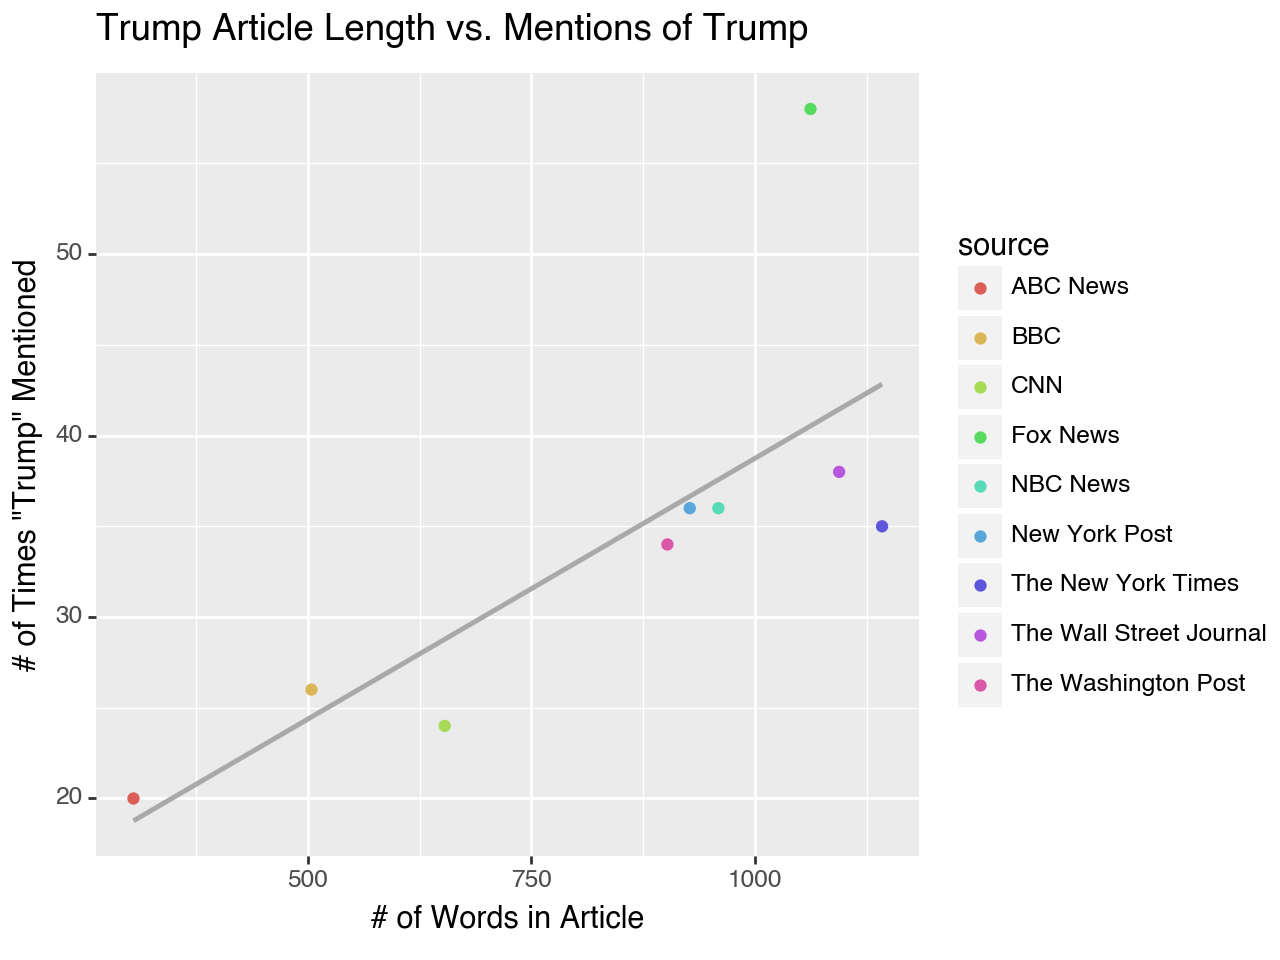

<Figure Size: (640 x 480)>

In [28]:
# create scatterplot of length of trump article vs frequency of the word "Trump"

(
ggplot(data=trump_words,
       mapping=aes(x='article_length', y='trump_word_count', color='source'))
       + geom_point(show_legend=True)
       + geom_smooth(method = "lm", se=False, color="darkgrey")
       + labs(title="Trump Article Length vs. Mentions of Trump",
              x='# of Words in Article',
              y='# of Times "Trump" Mentioned')
)

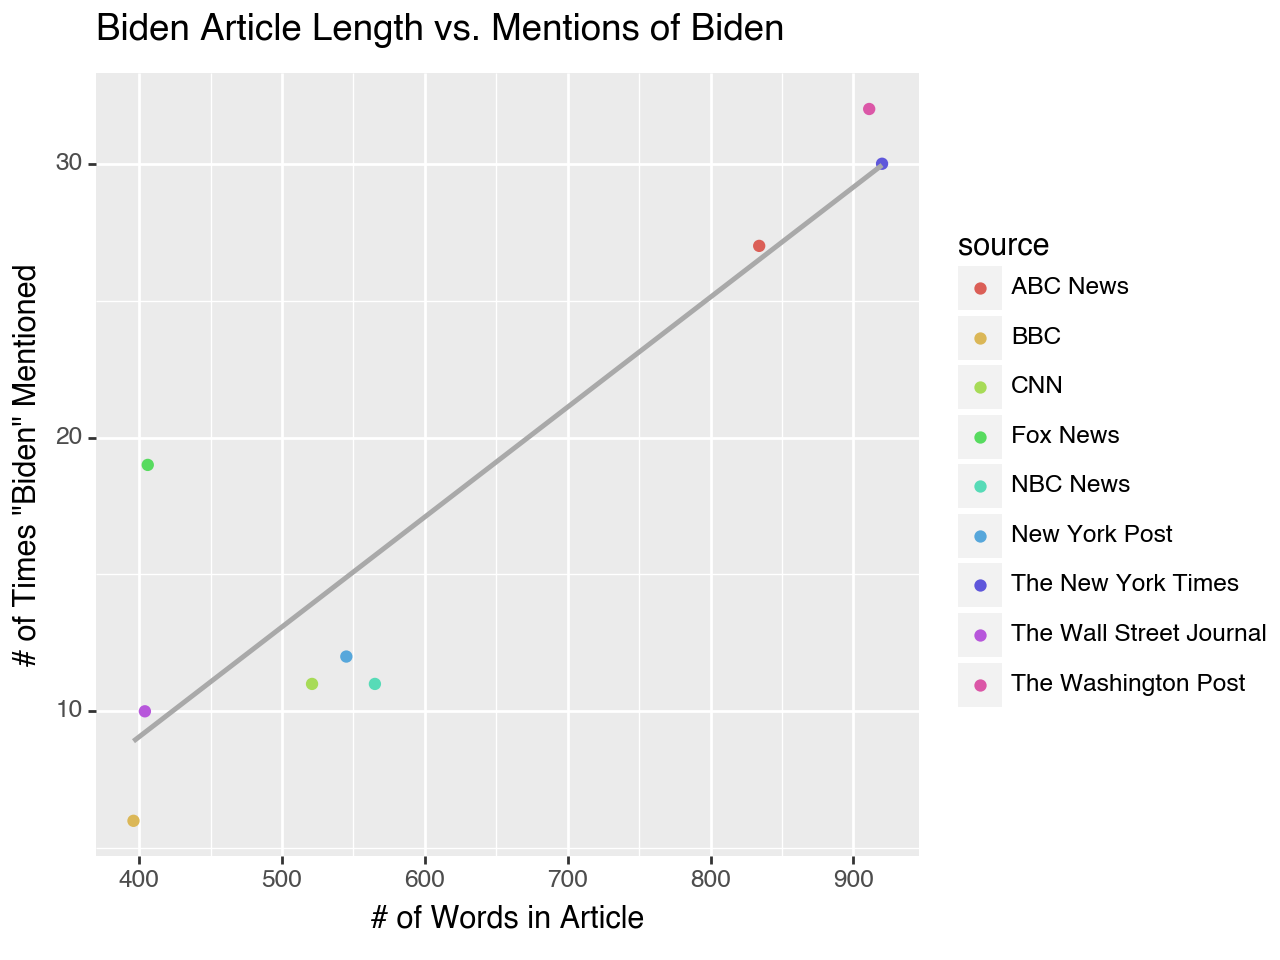

<Figure Size: (640 x 480)>

In [29]:
# create scatterplot of length of biden article vs frequency of the word "Biden"

(
ggplot(data=biden_words,
       mapping=aes(x='article_length', y='biden_word_count', color='source'))
       + geom_point(show_legend=True)
       + geom_smooth(method = "lm", se=False, color="darkgrey")
       + labs(title="Biden Article Length vs. Mentions of Biden",
              x='# of Words in Article',
              y='# of Times "Biden" Mentioned')
)

In [30]:
first = article_docs_unstemmed[0]
" ".join(first.split()[:-2])

'supreme court thursday set new limits affirmative action programs cases involving whether public private colleges universities continue use race one factor among many student admissions court held opinion conservative majority written chief justice john roberts harvard unc admissions programs violate equal protection clause fourteenth amendment vote unc case harvard case due recusal justice ketanji brown jackson jackson served board overseers harvard earned undergraduate law degrees jackson justice sonia sotomayor justice elena kagan dissented two cases court said blockbuster cases put affirmative action used decades colleges universities address inequality diversify campuses spotlight supreme court repeatedly ruled since schools may consider race applicants pursuing educational benefits diverse student body long one factor among many considered schools use quota system students fair admissions conservative group sued harvard university university north carolina race conscious admissi

In [31]:
# calculate polarity and subjectivity scores, create dataframe
from textblob import TextBlob

scores_df = pd.DataFrame({'source':tfidf_df['article_source'], 'topic':tfidf_df['article_topic']})

# shorten some source names to fit on graph later
scores_df['source'] = np.where(scores_df['source'] == "The New York Times", "New York Times", scores_df['source'])
scores_df['source'] = np.where(scores_df['source'] == "The Washington Post", "Washington Post", scores_df['source'])
scores_df['source'] = np.where(scores_df['source'] == "The Wall Street Journal", "Wall Street Journal", scores_df['source'])

# initialize list of polarity and subjectivity scores
polarity_scores = []
subjectivity_scores = []

# calculate the scores for each article and add them to the corresponding list of scores
for article in article_docs_unstemmed:
    polarity_scores.append(round(TextBlob(" "
    .join(article.split()[:-2]))
    .sentiment.polarity, 2))
    
    subjectivity_scores.append(round(TextBlob(" "
    .join(article.split()[:-2]))
    .sentiment.subjectivity, 2))

# add a column in the df for the polarity and subjectivity scores, based on the lists
scores_df['polarity_score'] = polarity_scores
scores_df['subjectivity_score'] = subjectivity_scores

# initialize list of average polarity scores for each topic and source
average_topic_polarity_scores = []
average_source_polarity_scores = []

# calculate the average polarity scores for each topic, add to that list
for topic in scores_df['topic'].value_counts().index:
    mean_score = round(scores_df[scores_df['topic'] == topic]['polarity_score'].mean(), 2)
    average_topic_polarity_scores.append(mean_score)

# calculate the average polarity scores for each source, add to that list
for source in scores_df['source'].value_counts().index:
    mean_score = round(scores_df[scores_df['source'] == source]['polarity_score'].mean(), 2)
    for i in range(8):
        average_source_polarity_scores.append(mean_score)

# add columns for the two lists above, average polarity scores by topic and source
scores_df['average_polarity_for_topic'] = average_topic_polarity_scores * 9
scores_df['average_polarity_for_source'] = average_source_polarity_scores

# initialize lists for average subjectivity scores by topic and source
average_topic_subjectivity_scores = []
average_source_subjectivity_scores = []

# calculate average subjectivity score by topic, add to that list
for topic in scores_df['topic'].value_counts().index:
    mean_score = round(scores_df[scores_df['topic'] == topic]['subjectivity_score'].mean(), 2)
    average_topic_subjectivity_scores.append(mean_score)

# calculate average subjectivity score by source, add to that list
for source in scores_df['source'].value_counts().index:
    mean_score = round(scores_df[scores_df['source'] == source]['subjectivity_score'].mean(), 2)
    for i in range(8):
        average_source_subjectivity_scores.append(mean_score)

# create columns for the two lists above, average subjectivity scores by topic and source
scores_df['average_subjectivity_for_topic'] = average_topic_subjectivity_scores * 9
scores_df['average_subjectivity_for_source'] = average_source_subjectivity_scores

# create various new columns, for each score type's difference from the mean
# for that topic or source
scores_df['polarity_diff_from_topic_mean'] = scores_df['polarity_score'] - scores_df['average_polarity_for_topic']
scores_df['subjectivity_diff_from_topic_mean'] = scores_df['subjectivity_score'] - scores_df['average_subjectivity_for_topic']
scores_df['polarity_diff_from_source_mean'] = scores_df['polarity_score'] - scores_df['average_polarity_for_source']
scores_df['subjectivity_diff_from_source_mean'] = scores_df['subjectivity_score'] - scores_df['average_subjectivity_for_source']

# calculate how much on average each source deviates from the average polarity
# or subjectivity score for that topic, create columns for those calculations
sources_polarity_dev = []

for source in scores_df['source'].value_counts().index:
    total_dev = scores_df[scores_df['source'] == source]['polarity_diff_from_topic_mean'].sum()
    for i in range(8):
        sources_polarity_dev.append(total_dev/8)

sources_subjectivity_dev = []

for source in scores_df['source'].value_counts().index:
    total_dev = scores_df[scores_df['source'] == source]['subjectivity_diff_from_topic_mean'].sum()
    for i in range(8):
        sources_subjectivity_dev.append(total_dev/8)

scores_df['average_source_polarity_deviation_from_topic_mean'] = sources_polarity_dev
scores_df['average_source_subjectivity_deviation_from_topic_mean'] = sources_subjectivity_dev

# create column to indicate whether the polarity score is positive or negative,
# to color graphs by later
scores_df['polarity_sign'] = np.where(scores_df['polarity_score'] > 0, 'pos', 'neg')
# create column for absolute value of the polarity score
scores_df['polarity_magnitude'] = abs(scores_df['polarity_score'])

scores_df.head(5)

,source,topic,polarity_score,subjectivity_score,average_polarity_for_topic,average_polarity_for_source,average_subjectivity_for_topic,average_subjectivity_for_source,polarity_diff_from_topic_mean,subjectivity_diff_from_topic_mean,polarity_diff_from_source_mean,subjectivity_diff_from_source_mean,average_source_polarity_deviation_from_topic_mean,average_source_subjectivity_deviation_from_topic_mean,polarity_sign,polarity_magnitude
62,Washington Post,U.S. and Germany Send Tanks to Ukraine,0.04,0.38,0.07,0.05,0.38,0.38,-0.03,0.00,-0.01,0.00,-0.00375,-0.00625,pos,0.04
63,Washington Post,Trump's Indictment,0.02,0.44,0.04,0.05,0.41,0.38,-0.02,0.03,-0.03,0.06,-0.00375,-0.00625,pos,0.02
64,Wall Street Journal,Supreme Court Ruling on Affirmative Action,0.07,0.39,0.11,0.04,0.40,0.36,-0.04,-0.01,0.03,0.03,-0.01000,-0.02625,pos,0.07
65,Wall Street Journal,Chinese Surveillance Balloon,0.02,0.28,0.04,0.04,0.37,0.36,-0.02,-0.09,-0.02,-0.08,-0.01000,-0.02625,pos,0.02
66,Wall Street Journal,Biden's Low Approval Rates in Polls,0.07,0.42,0.08,0.04,0.39,0.36,-0.01,0.03,0.03,0.06,-0.01000,-0.02625,pos,0.07
67,Wall Street Journal,The Deadliest Attack by Hamas,0.04,0.32,0.02,0.04,0.36,0.36,0.02,-0.04,0.00,-0.04,-0.01000,-0.02625,pos,0.04
68,Wall Street Journal,Pentagon Documents Leak,0.05,0.39,0.05,0.04,0.40,0.36,0.00,-0.01,0.01,0.03,-0.01000,-0.02625,pos,0.05
69,Wall Street Journal,George Santos' Expulsion from Congress,-0.04,0.35,0.02,0.04,0.39,0.36,-0.06,-0.04,-0.08,-0.01,-0.01000,-0.02625,neg,0.04
70,Wall Street Journal,U.S. and Germany Send Tanks to Ukraine,0.11,0.32,0.07,0.04,0.38,0.36,0.04,-0.06,0.07,-0.04,-0.01000,-0.02625,pos,0.11
71,Wall Street Journal,Trump's Indictment,0.03,0.42,0.04,0.04,0.41,0.36,-0.01,0.01,-0.01,0.06,-0.01000,-0.02625,pos,0.03


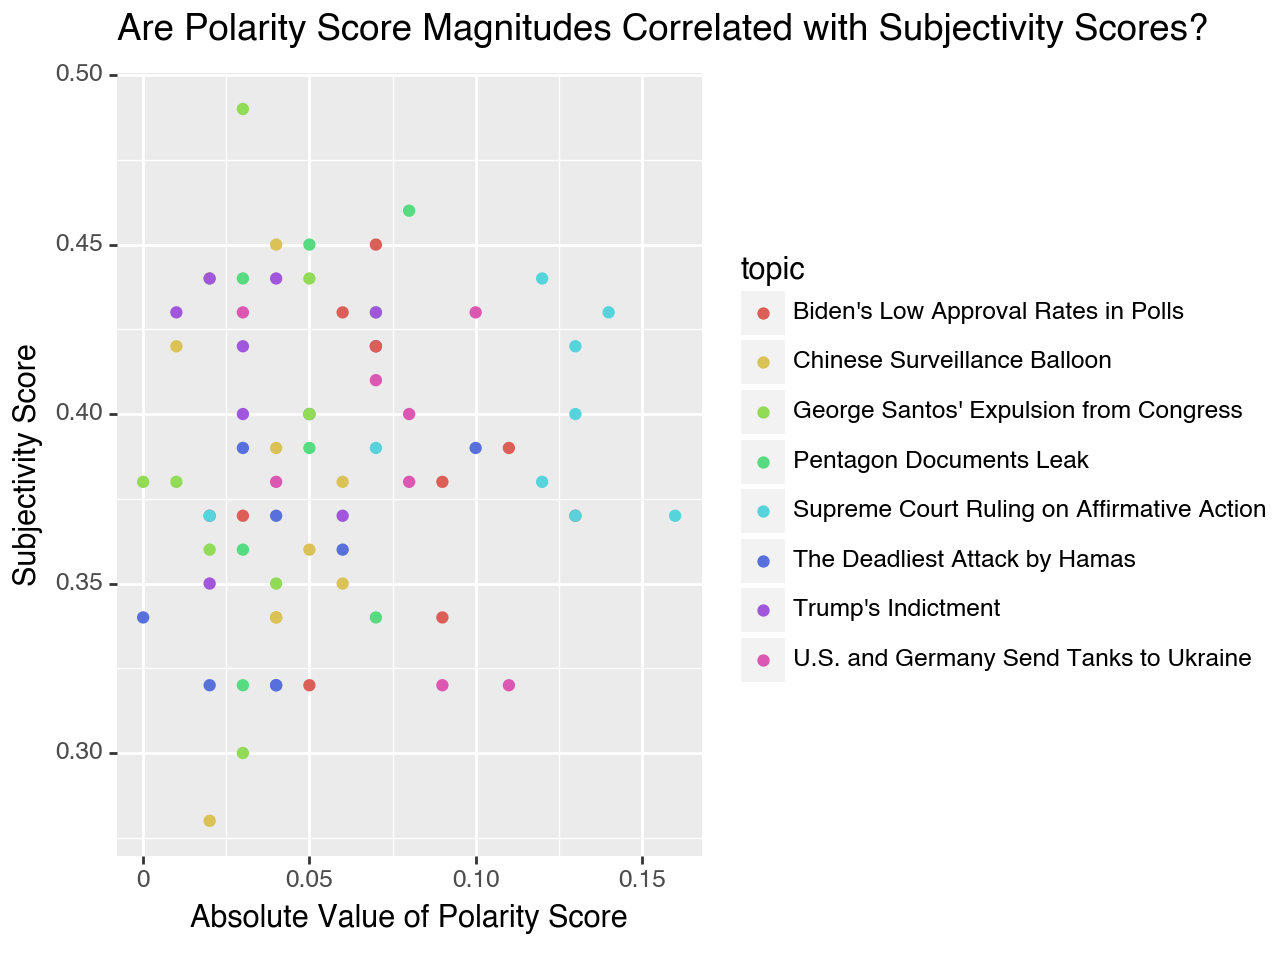

<Figure Size: (640 x 480)>

In [32]:
# to better understand subjectivity scores: are polarity scores and subjectivity scores correlated?
# this may suggest that polarity score is used in the calculation of a subjectivity score

(
ggplot(scores_df, aes(x="polarity_magnitude", y="subjectivity_score", color='topic'))
+ geom_point()
+ labs(x="Absolute Value of Polarity Score",
       y='Subjectivity Score',
       title='Are Polarity Score Magnitudes Correlated with Subjectivity Scores?')
)

Nope.

In [ ]:
# scatterplot to see if polarity magnitudes and subjectivity scores are
# correlated, colored by source
(
ggplot(scores_df, aes(x="polarity_magnitude", y="subjectivity_score", color='source'))
+ geom_point()
+ labs(x="Absolute Value of Polarity Score",
       y='Subjectivity Score',
       title='Are Polarity Score Magnitudes Correlated with Subjectivity Scores?')
)

In [33]:
# create a df for each source and its polarity score total deviations from the topic means

polarity_devs = pd.DataFrame({'source':scores_df['source'].value_counts().index, 
                              'polarity_dev':scores_df[scores_df['topic'] == 'Chinese Surveillance Balloon']\
                                ['average_source_polarity_deviation_from_topic_mean']})
# create a column denoting if deviation is above or below mean to color graph by later
polarity_devs['sign'] = np.where(polarity_devs['polarity_dev'] > 0, 'pos', 'neg')

polarity_devs = polarity_devs.reindex(polarity_devs['polarity_dev'].abs().sort_values(ascending=False).index)
polarity_devs.reset_index(drop=True, inplace=True)

source_order = CategoricalDtype(
    ["New York Times", "Wall Street Journal", "ABC News", "NBC News", 
     "CNN", "New York Post", "Washington Post", "Fox News", "BBC"], 
    ordered=False
)
polarity_devs['source'] = polarity_devs['source'].astype(source_order)

polarity_devs

,source,polarity_dev,sign
0,New York Times,-0.01625,neg
1,ABC News,0.01000,pos
2,Wall Street Journal,-0.01000,neg
3,NBC News,0.00750,pos
4,CNN,0.00750,pos
5,New York Post,-0.00375,neg
6,Washington Post,-0.00375,neg
7,Fox News,0.00375,pos
8,BBC,0.00125,pos


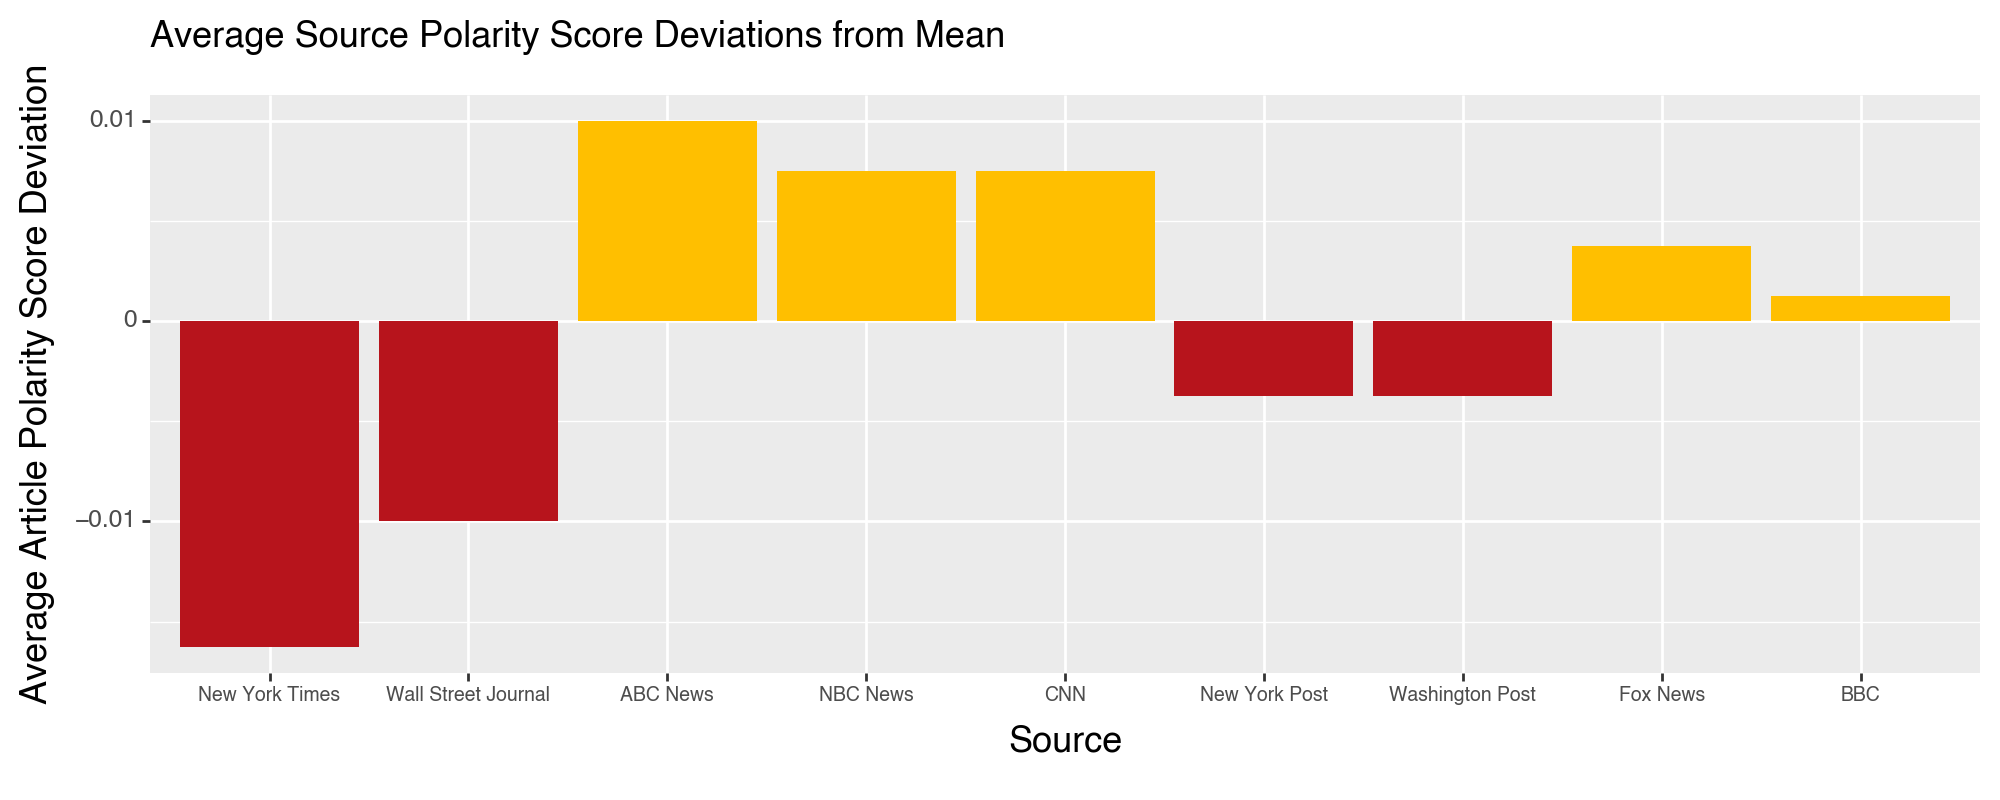

<Figure Size: (1000 x 400)>

In [34]:
# create bar chart representing how much, on average, a source's article
# deviates away from that topic's mean polarity score
# intended to show if a source tends to be more negative/positive than average, 
# even accounting for the nature of the topic

colors = {"pos":'#ffbf00', "neg":'#b7141c'}  

(
ggplot(polarity_devs, aes(x="source", y="polarity_dev", fill="sign"))
+ geom_col(stat="identity")
+ labs(x="Source", y='Average Article Polarity Score Deviation',
       title='Average Source Polarity Score Deviations from Mean')
+ theme(figure_size = (10, 4), axis_text_x=element_text(size=7, face='bold'), 
        title = element_text(size=13),legend_position = "none")
+ scale_fill_manual(values = colors)
)

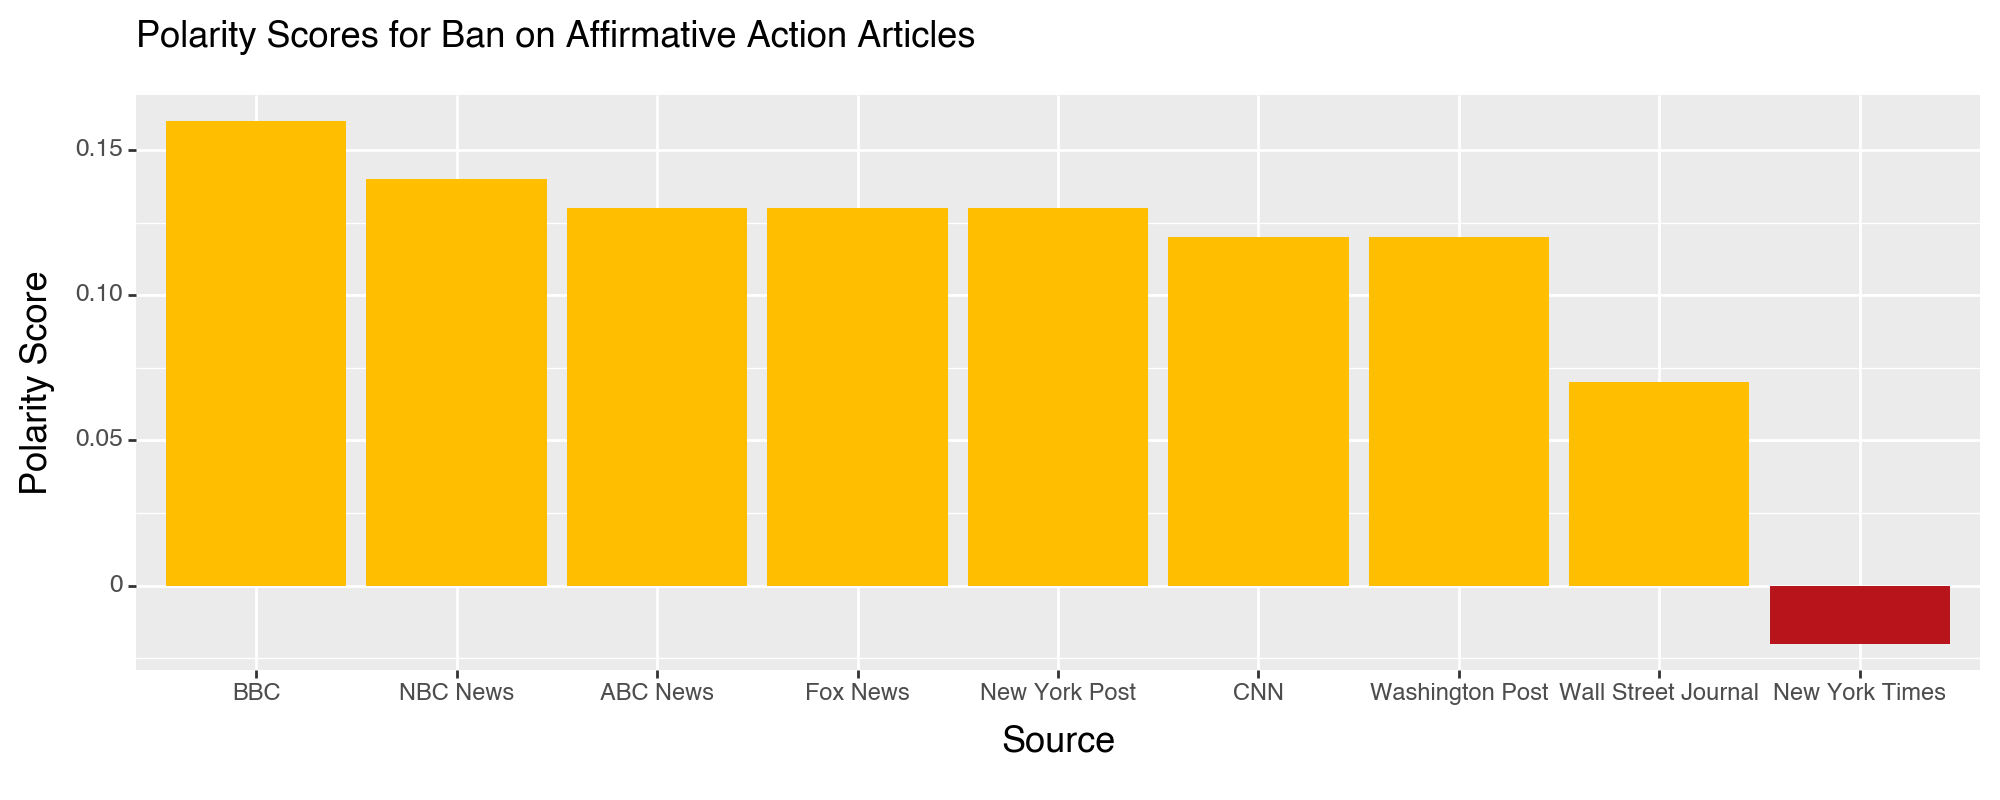

<Figure Size: (1000 x 400)>

In [35]:
(
ggplot(scores_df[scores_df['topic']=="Supreme Court Ruling on Affirmative Action"],
       aes(x="reorder(source, -polarity_score)", y="polarity_score", fill="polarity_sign"))
+ geom_col(stat="identity")
+ labs(x='Source', y='Polarity Score', title='Polarity Scores for Ban on Affirmative Action Articles')
+ theme(figure_size = (10, 4), axis_text_x=element_text(size=8.5, face='bold'), 
        title = element_text(size=13), legend_position = "none")
+ scale_fill_manual(values = colors)
)


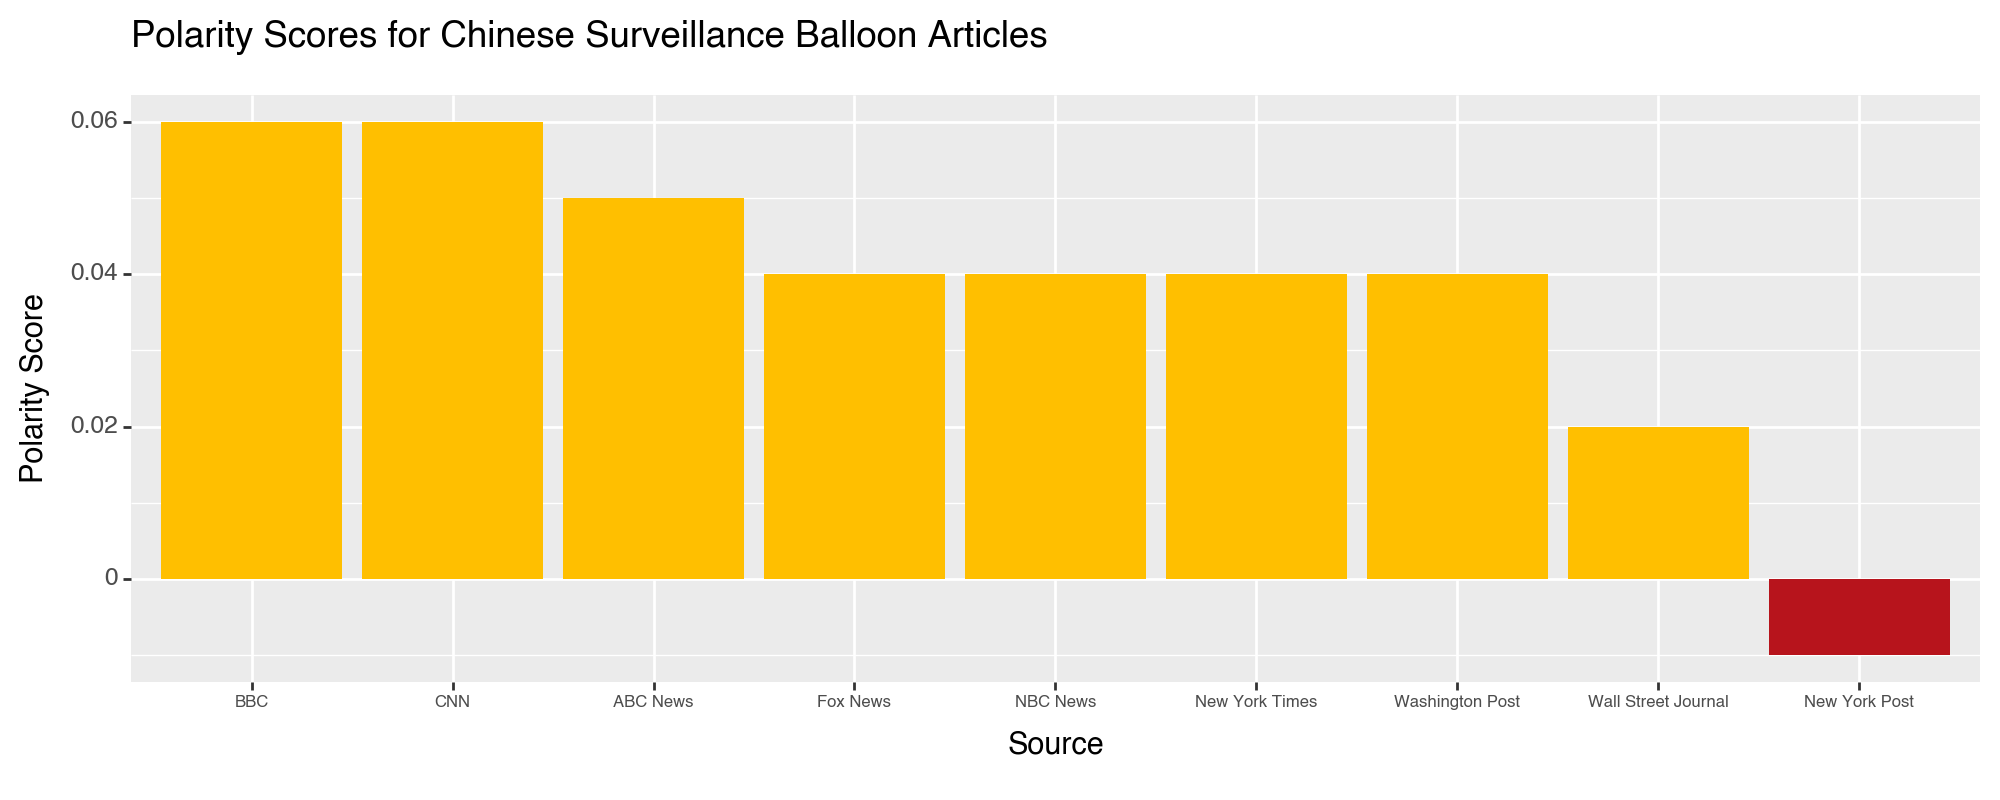

<Figure Size: (1000 x 400)>

In [36]:
(
ggplot(scores_df[scores_df['topic']=="Chinese Surveillance Balloon"],
       aes(x="reorder(source, -polarity_score)", y="polarity_score", fill="polarity_sign"))
+ geom_col(stat="identity")
+ labs(x='Source', y='Polarity Score', title='Polarity Scores for Chinese Surveillance Balloon Articles')
+ theme(figure_size = (10, 4), axis_text_x=element_text(size=6, face='bold'), legend_position = "none")
+ scale_fill_manual(values = colors)
)

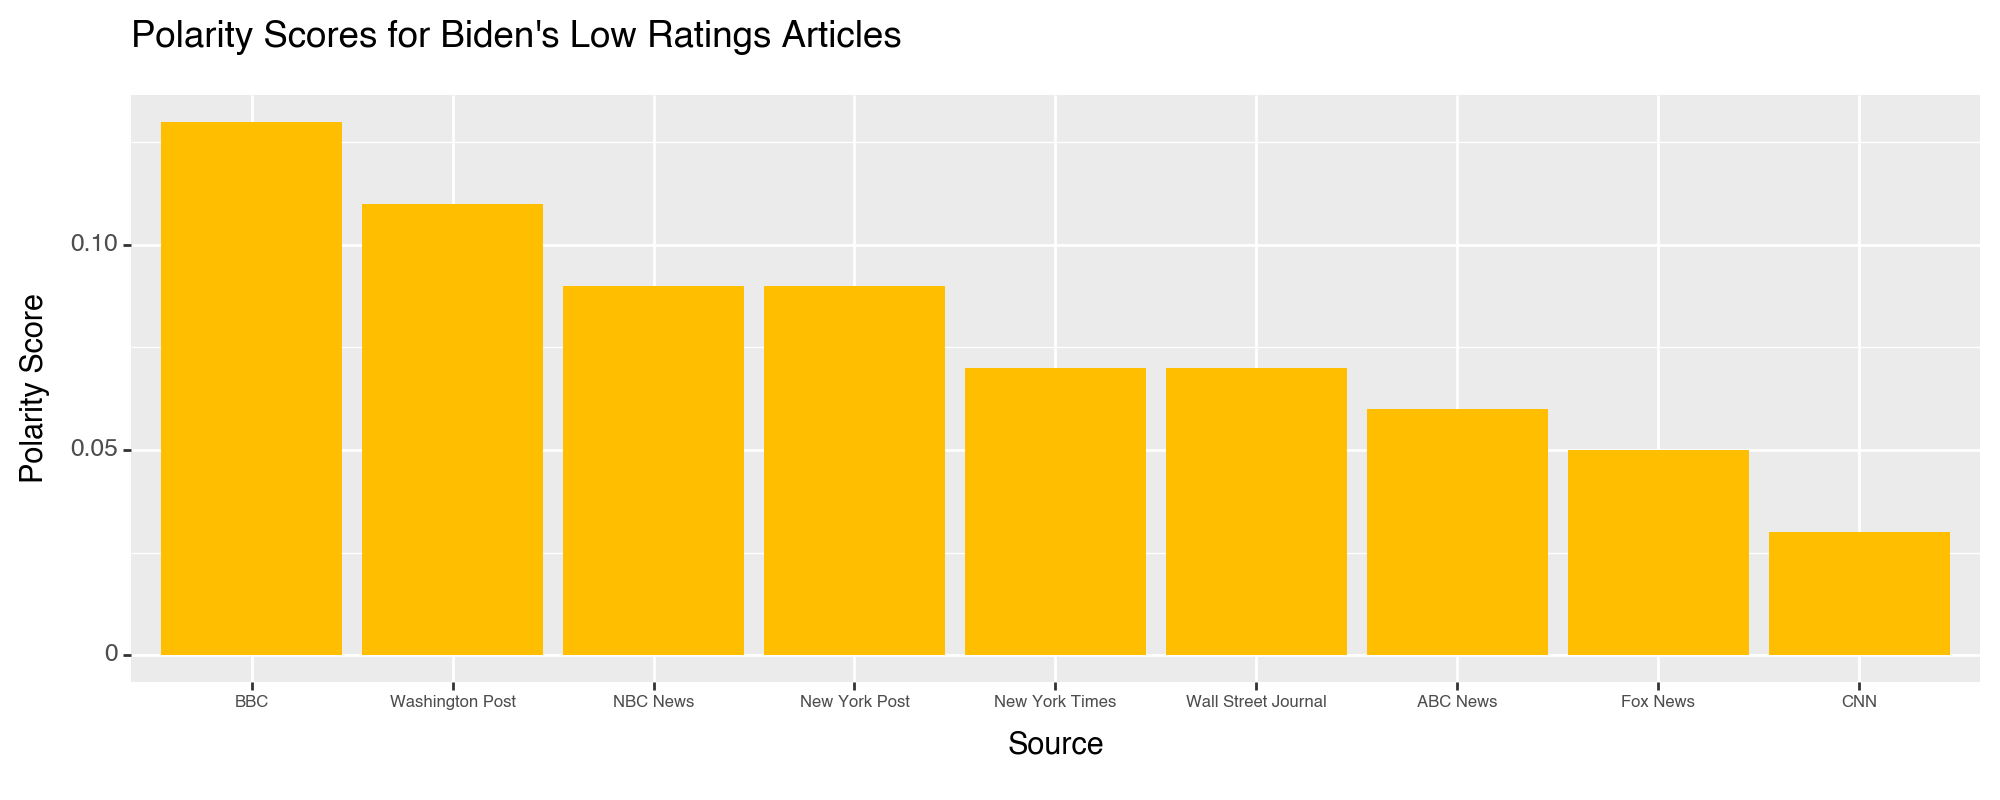

<Figure Size: (1000 x 400)>

In [37]:
(
ggplot(scores_df[scores_df['topic']=="Biden's Low Approval Rates in Polls"],
       aes(x="reorder(source, -polarity_score)", y="polarity_score", fill="polarity_sign"))
+ geom_col(stat="identity")
+ labs(x='Source', y='Polarity Score', title="Polarity Scores for Biden's Low Ratings Articles")
+ theme(figure_size = (10, 4), axis_text_x=element_text(size=6, face='bold'), legend_position = "none")
+ scale_fill_manual(values = colors)
)

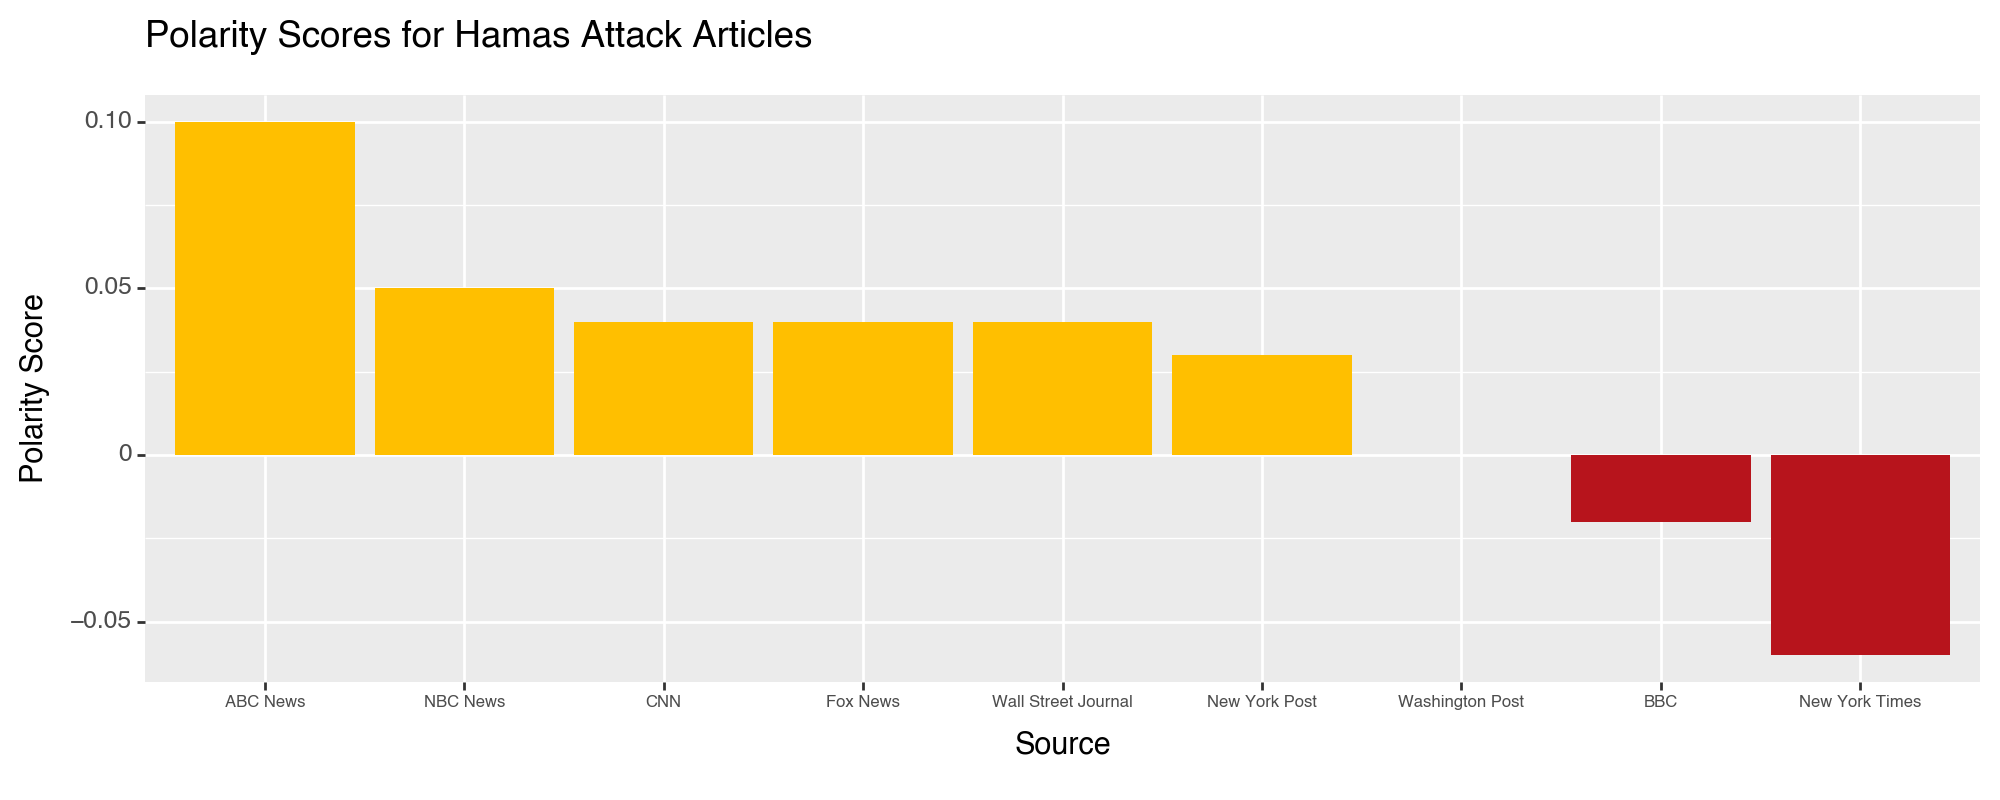

<Figure Size: (1000 x 400)>

In [38]:
(
ggplot(scores_df[scores_df['topic']=="The Deadliest Attack by Hamas"],
       aes(x="reorder(source, -polarity_score)", y="polarity_score", fill="polarity_sign"))
+ geom_col(stat="identity")
+ labs(x='Source', y='Polarity Score', title="Polarity Scores for Hamas Attack Articles")
+ theme(figure_size = (10, 4), axis_text_x=element_text(size=6, face='bold'), legend_position = "none")
+ scale_fill_manual(values = colors)
)

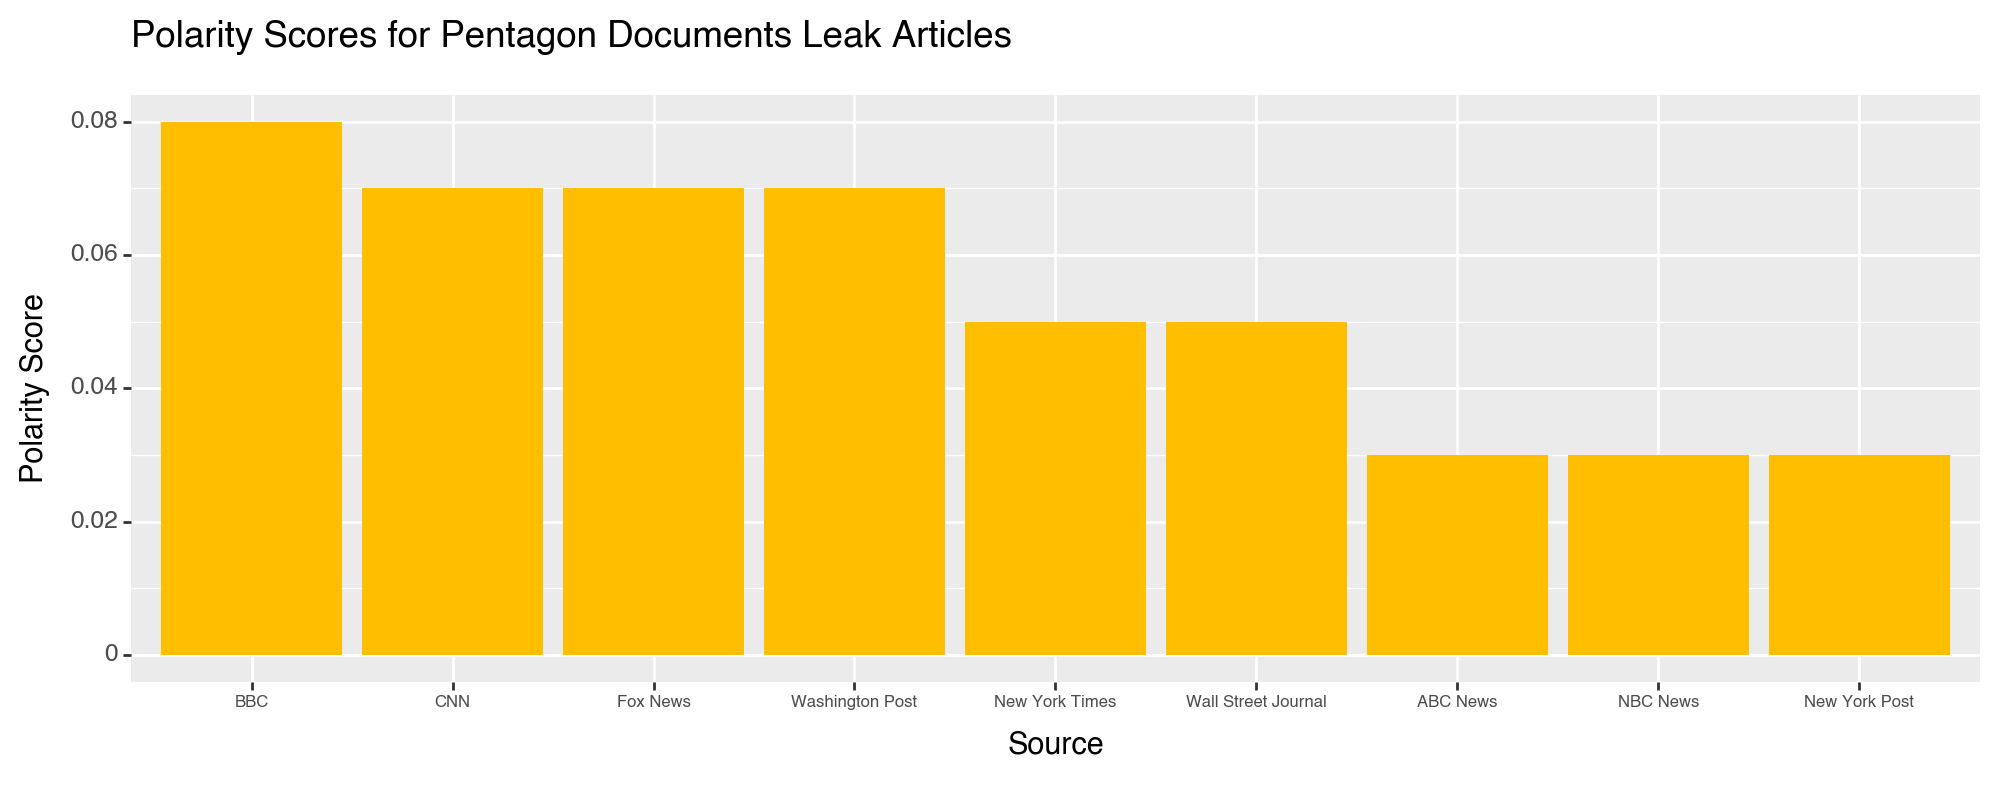

<Figure Size: (1000 x 400)>

In [39]:
(
ggplot(scores_df[scores_df['topic']=="Pentagon Documents Leak"],
       aes(x="reorder(source, -polarity_score)", y="polarity_score", fill="polarity_sign"))
+ geom_col(stat="identity")
+ labs(x='Source', y='Polarity Score', title="Polarity Scores for Pentagon Documents Leak Articles")
+ theme(figure_size = (10, 4), axis_text_x=element_text(size=6, face='bold'), legend_position = "none")
+ scale_fill_manual(values = colors)
)

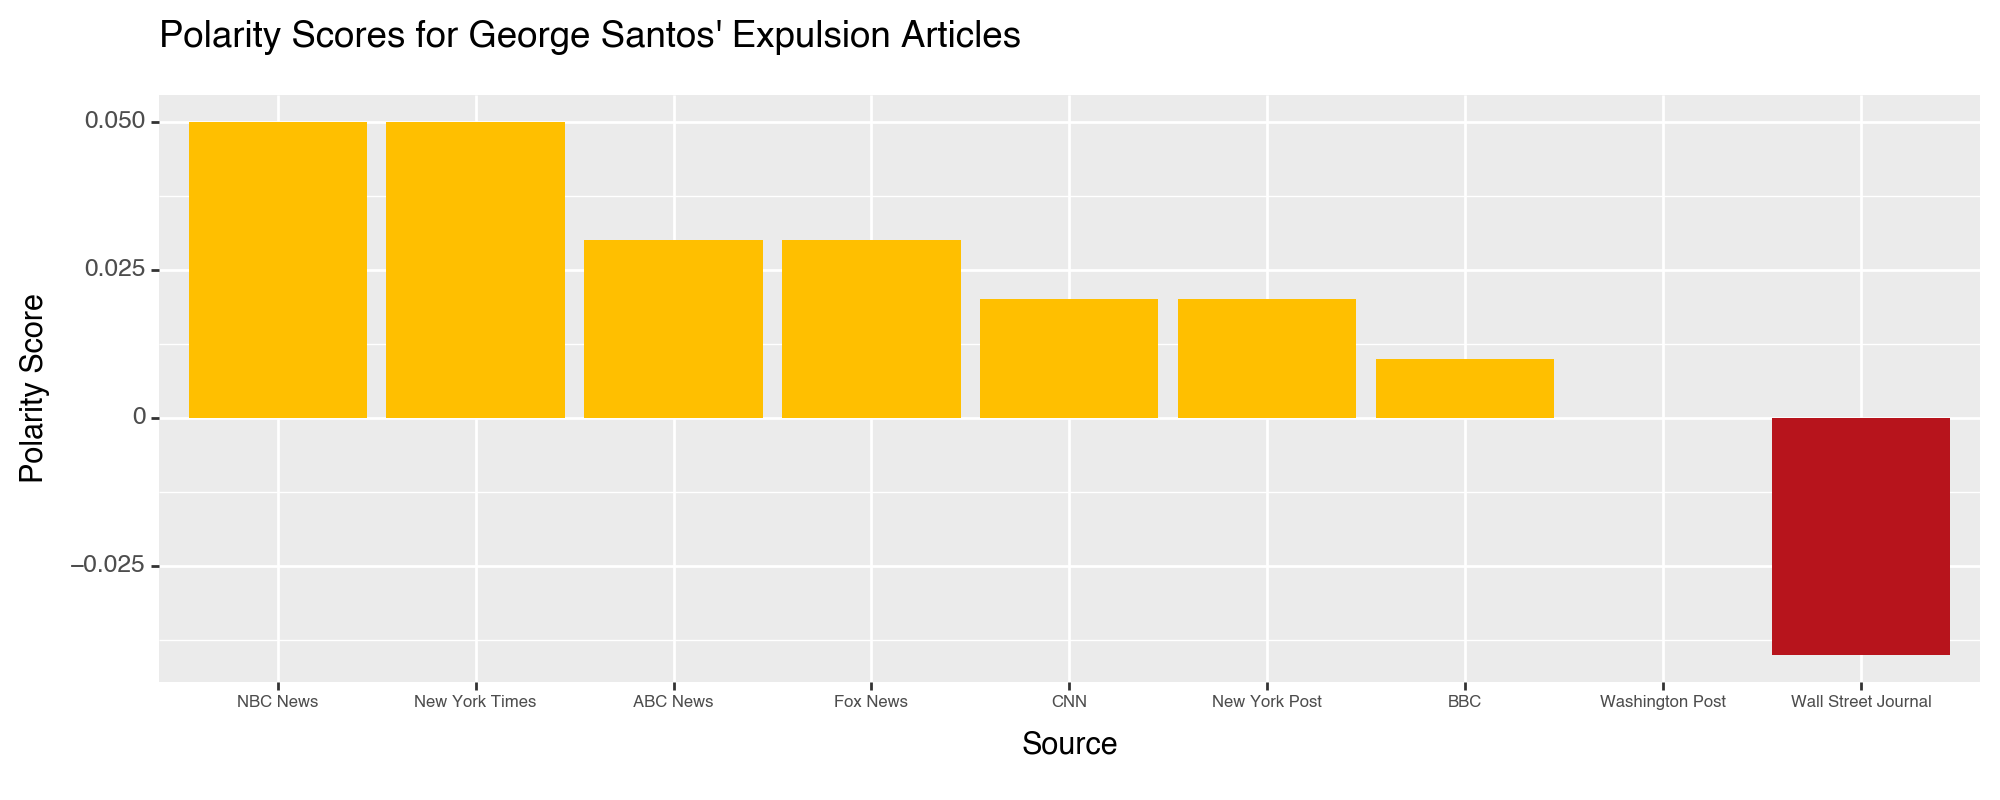

<Figure Size: (1000 x 400)>

In [40]:
(
ggplot(scores_df[scores_df['topic']=="George Santos' Expulsion from Congress"],
       aes(x="reorder(source, -polarity_score)", y="polarity_score", fill="polarity_sign"))
+ geom_col(stat="identity")
+ labs(x='Source', y='Polarity Score', title="Polarity Scores for George Santos' Expulsion Articles")
+ theme(figure_size = (10, 4), axis_text_x=element_text(size=6, face='bold'), legend_position = "none")
+ scale_fill_manual(values = colors)
)

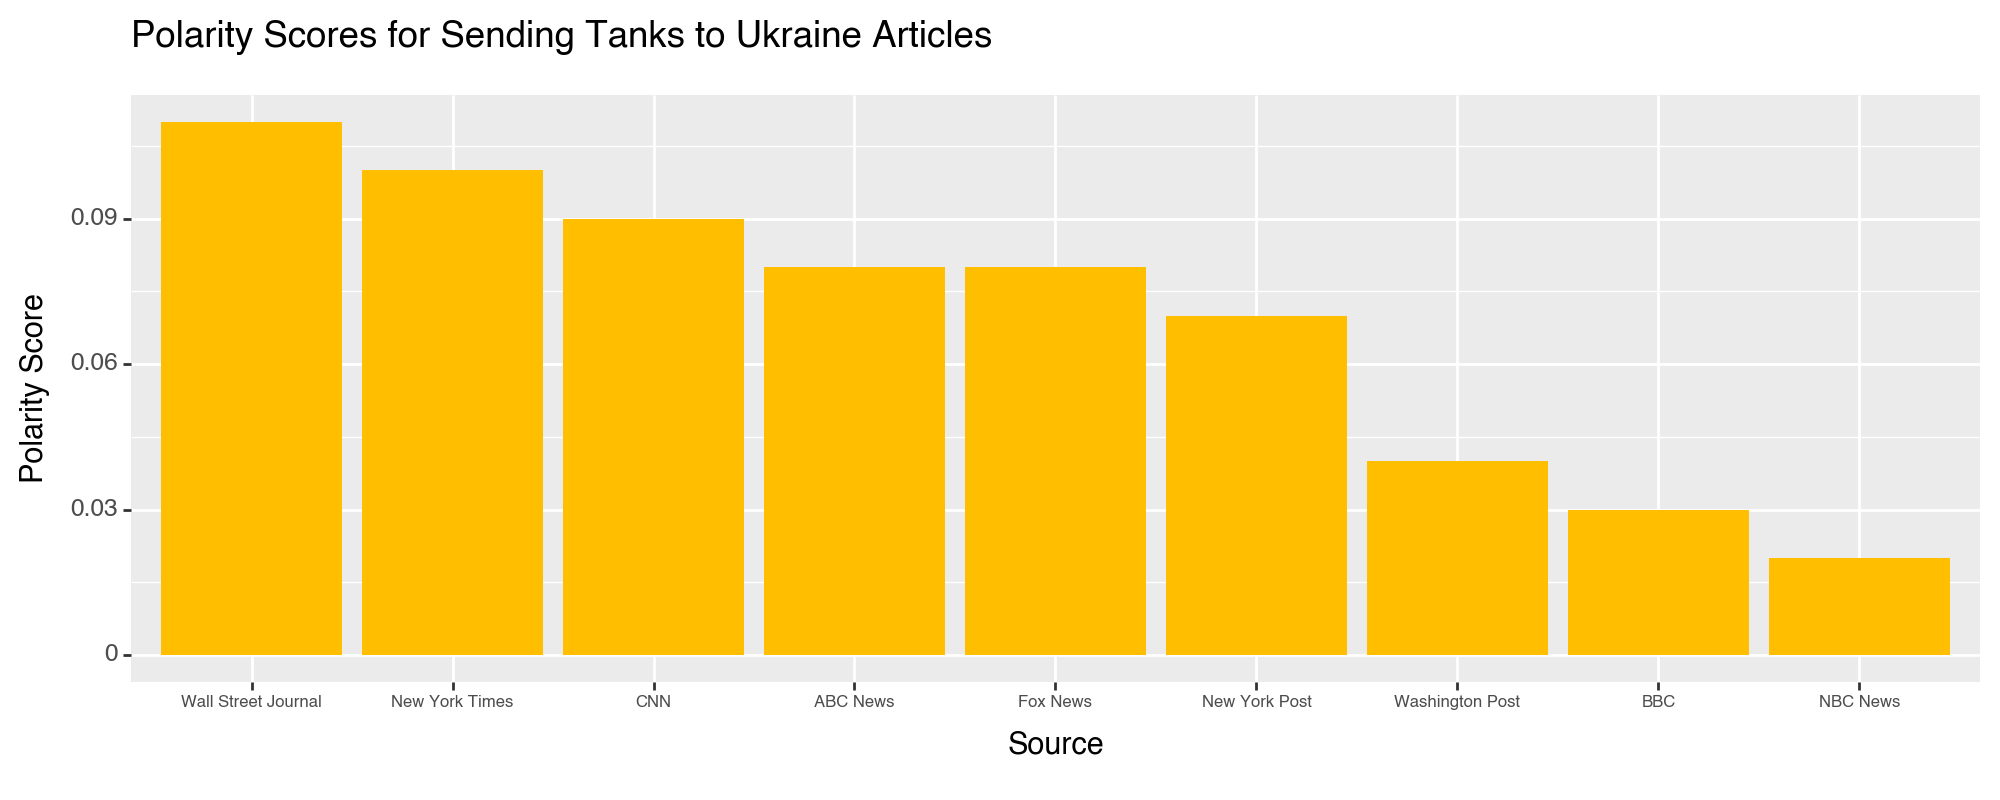

<Figure Size: (1000 x 400)>

In [41]:
(
ggplot(scores_df[scores_df['topic']=="U.S. and Germany Send Tanks to Ukraine"],
       aes(x="reorder(source, -polarity_score)", y="polarity_score", fill="polarity_sign"))
+ geom_col(stat="identity")
+ labs(x='Source', y='Polarity Score', title="Polarity Scores for Sending Tanks to Ukraine Articles")
+ theme(figure_size = (10, 4), axis_text_x=element_text(size=6, face='bold'), legend_position = "none")
+ scale_fill_manual(values = colors)
)

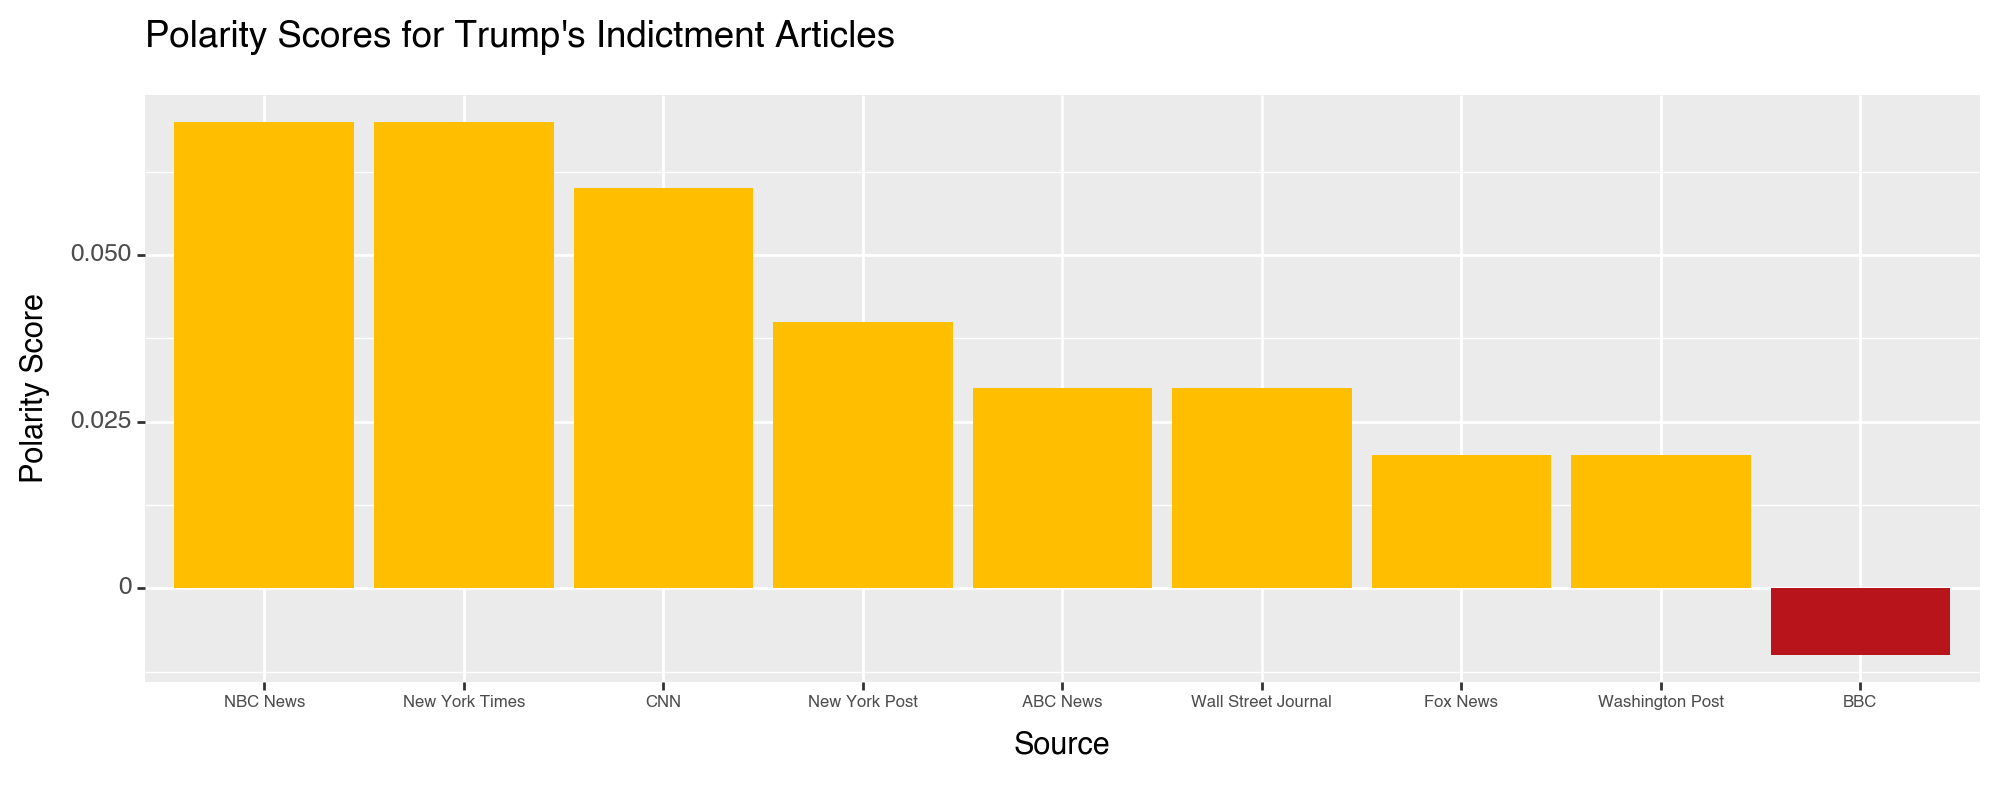

<Figure Size: (1000 x 400)>

In [42]:
(
ggplot(scores_df[scores_df['topic']=="Trump's Indictment"],
       aes(x="reorder(source, -polarity_score)", y="polarity_score", fill="polarity_sign"))
+ geom_col(stat="identity")
+ labs(x='Source', y='Polarity Score', title="Polarity Scores for Trump's Indictment Articles")
+ theme(figure_size = (10, 4), axis_text_x=element_text(size=6, face='bold'), legend_position = "none")
+ scale_fill_manual(values = colors)
)


Do the bar charts above mean for example that ABC News was portraying the attack by hamas in a positive light? no, this is just supposed to give insight into the source's word choices.

In [44]:
# create a df with average subjectivity scores per source

source_avg_subj = pd.DataFrame({'source':scores_df['source'].value_counts().index, 
                              'avg_subj':scores_df[scores_df['topic'] == 'Chinese Surveillance Balloon']\
                                ['average_subjectivity_for_source']})
source_avg_subj.sort_values(by='avg_subj', ascending=True, inplace=True)
source_avg_subj.reset_index(drop=True, inplace=True)

# order in ascending order of subjectivity
source_order = CategoricalDtype(
    ["Fox News", "Wall Street Journal", "CNN", 
     "Washington Post", "BBC", "New York Post", "ABC News", "NBC News", "New York Times"], 
    ordered=False
)
source_avg_subj['source'] = source_avg_subj['source'].astype(source_order)

source_avg_subj


,source,avg_subj
0,Fox News,0.36
1,Wall Street Journal,0.36
2,CNN,0.37
3,Washington Post,0.38
4,BBC,0.39
5,New York Post,0.39
6,ABC News,0.40
7,NBC News,0.41
8,New York Times,0.42


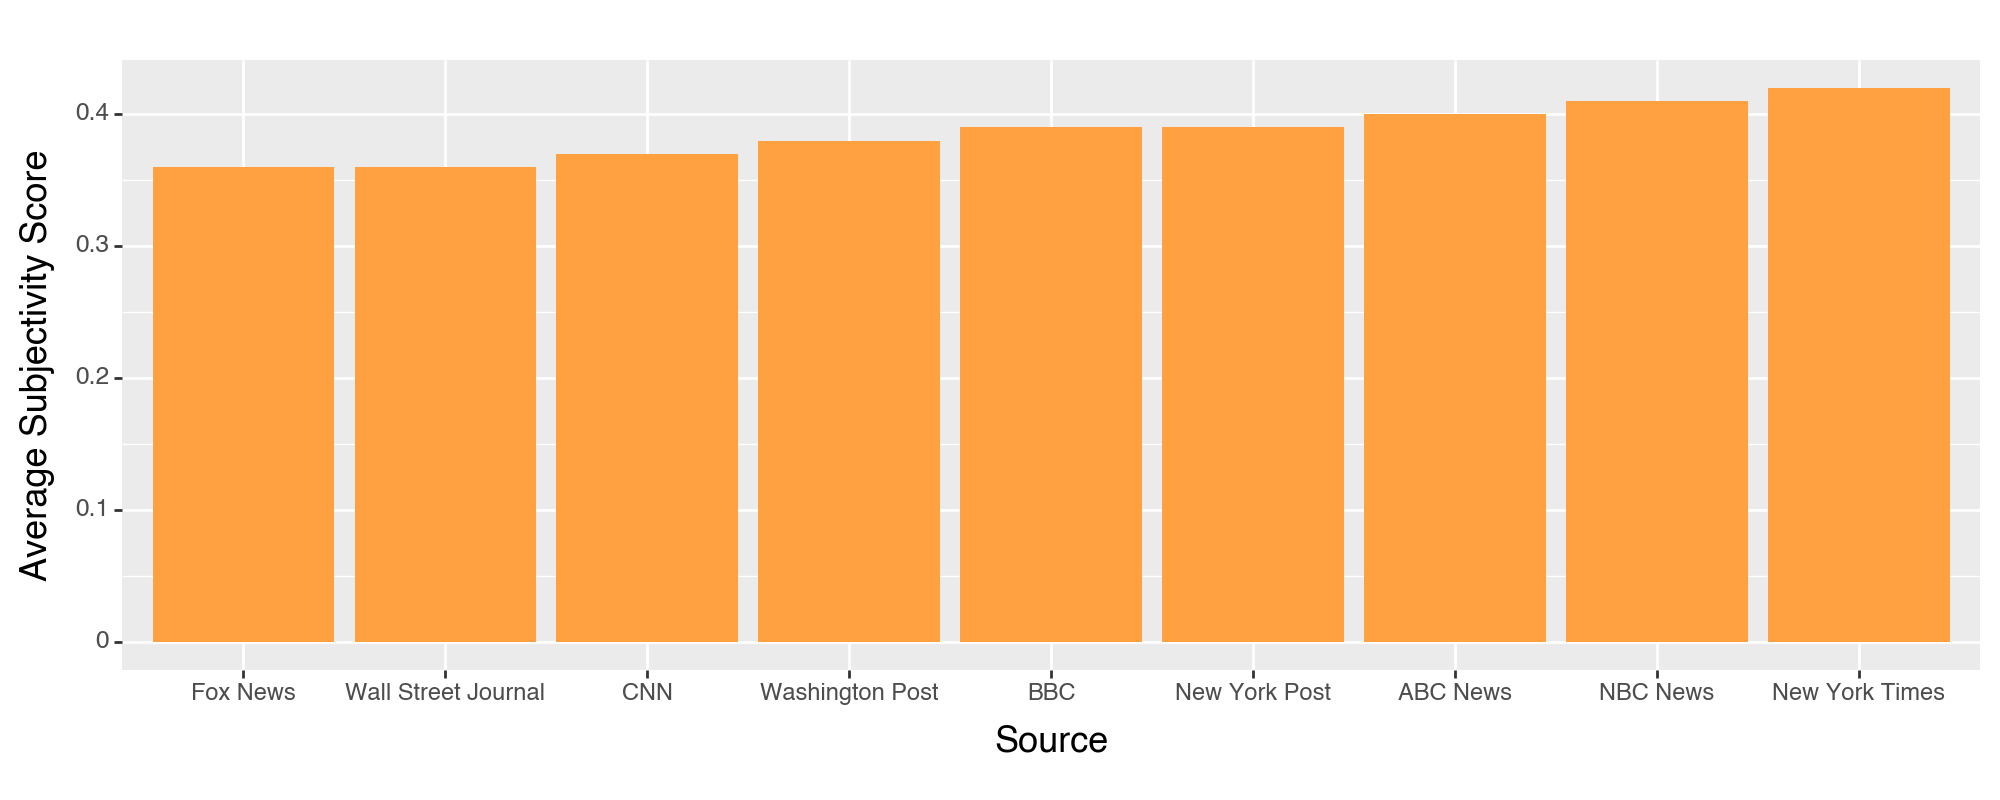

<Figure Size: (1000 x 400)>

In [45]:
# bar chart showing avg subjectivity per source

(
ggplot(source_avg_subj, aes(x="source", y="avg_subj"))
+ geom_col(stat="identity", fill="#ffa140")
+ labs(x='Source', y='Average Subjectivity Score', title='')
+ theme(figure_size = (10, 4), axis_text_x=element_text(size=8.5, face='bold'), 
        title = element_text(size=13), legend_position = "none")
)

In [46]:
# create a list of tuples that contain articles that have an outlier polarity score,
# compared to other articles about the same topic

articles =[]

# check for outliers topic by topic
for topic in scores_df['topic'].value_counts().index:
    topic_df = scores_df[scores_df['topic'] == topic]
    average_polarity = topic_df['average_polarity_for_topic'].iloc[0]
    # use IQR formula to detect outliers
    Q1 = topic_df['polarity_score'].describe()[4]
    Q3 = topic_df['polarity_score'].describe()[6]
    IQR = Q3-Q1
    lower = Q1-(1.5*IQR)
    upper = Q3+(1.5*IQR)
    # the line below would print the lower and upper bounds for non-outliers
    #   for each topic
    #print(topic, "lower bound:", round(lower, 2), "upper bound:", round(upper,2))
    # check if an article has an outlier polarity score (beyond lower/upper limits)
    for row in topic_df.itertuples():
        if row.polarity_score < lower or row.polarity_score > upper:
            articles.append((row.source, row.topic, row.polarity_score, average_polarity))

# create lists about outlier article information to create dataframe for them
outlier_source_list = []
outlier_topic_list = []
outlier_polarity_list = []
average_polarity_list = []

for article in articles:
  outlier_source_list.append(article[0])
  outlier_topic_list.append(article[1])
  outlier_polarity_list.append(article[2])
  average_polarity_list.append(article[3])

# display in dataframe the articles with an outlier polarity score
outlier_df = pd.DataFrame({'Source':outlier_source_list,
                           'Topic':outlier_topic_list,
                           'Polarity Score':outlier_polarity_list,
                           'Average Polarity for Topic':average_polarity_list})
display(outlier_df)

[('BBC', 'Supreme Court Ruling on Affirmative Action', 0.16), ('New York Times', 'Supreme Court Ruling on Affirmative Action', -0.02), ('Wall Street Journal', 'Supreme Court Ruling on Affirmative Action', 0.07), ('New York Post', 'Chinese Surveillance Balloon', -0.01), ('Wall Street Journal', 'Chinese Surveillance Balloon', 0.02), ('Wall Street Journal', "George Santos' Expulsion from Congress", -0.04)]
6


By the outlier detection above, there are 6 articles that are considered to have an outlier polarity score for their topic. Three of those are articles from the Wall Street Journal. Also, three of the outlier articles are about the Supreme Court Ruling on Affirmative Action. 

In [48]:
# initialize a dictionary that will show the best accuracy for each kind of classifier used
best_accuracies_by_cf = {}

# define list of topics to later choose training/testing sets with
topic_list = topic_choices  = [
      "Supreme Court Ruling on Affirmative Action"
    , "Chinese Surveillance Balloon"
    , "Biden's Low Approval Rates in Polls"
    , "The Deadliest Attack by Hamas"
    , "Pentagon Documents Leak"
    , "George Santos' Expulsion from Congress"
    , "U.S. and Germany Send Tanks to Ukraine"
    , "Trump's Indictment"
]

# initialize lists that will later be used to create a df showing the
# average model accuracy for each type of value the models were trained on
average_accuracies = []
value_types = []

# function to apply Naive Bayes model using different holdout article topics each time

def naive_bayes_cf(df, value_type):
    '''Takes in a dataframe of tokens and the desired values 
    to train the model on (i.e. tfidf scores, frequencies)
    and a string representing what the values are.
    Trains, tests, and outputs performance metrics of a series
    of Multinomial Naive Bayes classifiers, one for each
    possible holdout set of two article topics.'''

    # initialize lists where each model's accuracy/f1 score will be appended
    # to later be able to determine the min/max of each
    accuracy_list = []
    f1_score_list = []

    # loops to create a model with each combination of a testing set
    # consisting of two topics
    for i in range(len(topic_list)):
        for j in range(i+1, len(topic_list)):
            # uncomment lines below to print the holdout topics for the model
            #print("Holdout article topics: ")
            #print(topic_list[i])
            #print(topic_list[j])

            # split into training/testing df's for predictor and target variables
            X_train_df = df[(df['article_topic'] != topic_list[i]) & 
                    (df['article_topic'] != topic_list[j])].iloc[:, :-2]
            X_test_df = df[(df['article_topic'] == topic_list[i]) | 
                    (df['article_topic'] == topic_list[j])].iloc[:, :-2]
            y_train_df = df[(df['article_topic'] != topic_list[i]) & 
                    (df['article_topic'] != topic_list[j])]['article_source']
            y_test_df = df[(df['article_topic'] == topic_list[i]) | 
                    (df['article_topic'] == topic_list[j])]['article_source']
            
            # transform the training/testing df's to arrays
            X_train = X_train_df.to_numpy()
            X_test = X_test_df.to_numpy()
            y_train = y_train_df.to_numpy()
            y_test = y_test_df.to_numpy()

            # create classifier object and train it on our training data
            nb_model = MultinomialNB()
            nb_model.fit(X_train, y_train)

            # make predictions on our testing set, output as an array
            predictions_array = nb_model.predict(X_test)

            # turn the array with predicted sources into a list
            prediction_list = []

            for pred in predictions_array:
                prediction_list.append(pred)

            # create a list of the true sources
            actuals_list = []

            for source in y_test:
                actuals_list.append(source)

            # create a dataframe from the two lists created above to show the actual vs predicted sources
            preds_actuals_df = pd.DataFrame({'Actual':actuals_list, 'Predicted':prediction_list})

            # uncomment line below if want to see the dataframe of actual vs predicted sources for each model
            # display(preds_actuals_df)

            # calculate performance metrics
            accuracy = round(accuracy_score(predictions_array, y_test), 2)
            f1 = round(f1_score(predictions_array, y_test, average="weighted"), 2)

            # add the model's accuracy/f1 score to the list of accuracies/f1 scores
            accuracy_list.append(accuracy)
            f1_score_list.append(f1)

            # check if this model's accuracy is better than the current best accuracy
            # for Naive Bayes, and if it is, then set its accuracy to be the
            # value for Naive Bayes in the dictionary initialized earlier
            try:
                if accuracy > best_accuracies_by_cf['Naive Bayes']:
                    best_accuracies_by_cf['Naive Bayes'] = accuracy
            except:
                best_accuracies_by_cf['Naive Bayes'] = accuracy

            # uncomment lines below to display results of every model
            #print("Accuracy of Multinomial Naive Bayes Model:", accuracy)
            #print("F1 score of Multinomial Naive Bayes Model:", f1)
            #print("\n\n")

    # initialize a cumulative sum of accuracies for models trained
    # on the dataframe/value types defined in the function
    cum_acc = 0

    # add each model's accuracy to the cumulative sum
    for acc in accuracy_list:
        cum_acc += acc

    # calculate the average accuracy for a model trained on this
    # dataframe/value type and add it to the list of average accuracies
    average_accuracies.append(round(cum_acc/len(accuracy_list), 2))

    # add the value type used to train these models to the list of value
    # types, which will be used to create a df of average accuracies by value type
    value_types.append(value_type)

    # uncomment lines below if interested in displaying min/max
    #   accuracy scores for the models trained within the function
    #print(f"Minimum Accuracy Score of any Multinomial Naive Bayes Model using {value_type}:",
    #    min(accuracy_list))
    #print(f"Maximum Accuracy Score of any Multinomial Naive Bayes Model using {value_type}:",
    #    max(accuracy_list))
    #print(f"Maximum F1 Score of any Multinomial Naive Bayes Model using {value_type}:",
    #    max(f1_score_list))

In [49]:
# create a list of all the dataframes/value types we want to train our classifiers on
dfs = [(tfidf_df, "TFIDF Score"), (binary_df, "Binary Values"), (freq_df, "Frequencies")]

# loop through the list above to create many models
for df in dfs:
    naive_bayes_cf(df[0], df[1])

# create a dataframe showing each value type Naive Bayes models were trained on and the average accuracies for each
nb_results_df = pd.DataFrame({'Values Trained On':value_types, 'Average Accuracy':average_accuracies})

display(nb_results_df)

Holdout article topics: 
Supreme Court Ruling on Affirmative Action
Chinese Surveillance Balloon
Holdout article topics: 
Supreme Court Ruling on Affirmative Action
Biden's Low Approval Rates in Polls
Holdout article topics: 
Supreme Court Ruling on Affirmative Action
The Deadliest Attack by Hamas
Holdout article topics: 
Supreme Court Ruling on Affirmative Action
Pentagon Documents Leak
Holdout article topics: 
Supreme Court Ruling on Affirmative Action
George Santos' Expulsion from Congress
Holdout article topics: 
Supreme Court Ruling on Affirmative Action
U.S. and Germany Send Tanks to Ukraine
Holdout article topics: 
Supreme Court Ruling on Affirmative Action
Trump's Indictment
Holdout article topics: 
Chinese Surveillance Balloon
Biden's Low Approval Rates in Polls
Holdout article topics: 
Chinese Surveillance Balloon
The Deadliest Attack by Hamas
Holdout article topics: 
Chinese Surveillance Balloon
Pentagon Documents Leak
Holdout article topics: 
Chinese Surveillance Balloon
Ge

In [50]:
best_accuracies_by_cf['Naive Bayes']

0.4444444444444444

In [52]:
# initialize a dictionary that will hold the parameters that lead to best
# accuracies of a Random Forest Model
best_rf_params = {}

# initialize lists that will be used to create a dataframe showing the
# average accuracies of Random Forest models trained on a particular
# dataframe and with a particular set of parameters
average_accuracies = []
value_types = []
n_estimators = []
criterions = []

best_accuracies_by_cf['Random Forest'] = 0

# create a function to apply a Random Forest model using different
# holdout sets and given parameters and value types to train on
def random_forest_cf(df, value_type, n, crit):
    '''Takes in a dataframe of tokens and the desired values 
    to train the model on (i.e. tfidf scores, frequencies)
    and a string representing what the values are. 
    Also takes in specifications for n_estimators and criterion
    parameters of the Random Forest classifier. Trains, tests,
    and outputs performance metrics of a series of RF classifiers, 
    one for each possible holdout set of two article topics.'''

    # initalize lists for accuracy/f1 scores to later be able to determine the min/max of each 
    accuracy_list = []
    f1_score_list = []

    # loops to create a model with each combination of a testing set
    # consisting of two topics 
    for i in range(len(topic_list)):
        for j in range(i+1, len(topic_list)):
            # uncomment lines below to print the holdout topics
            #   and parameters used for the model
            # print("Holdout article topics: ")
            # print(topic_list[i])
            # print(topic_list[j])
            # print("n_estimators and criterion:")
            # print(n, crit)

            # split into training/testing df's for predictor and target variables
            X_train_df = df[(df['article_topic'] != topic_list[i]) & 
                    (df['article_topic'] != topic_list[j])].iloc[:, :-2]
            X_test_df = df[(df['article_topic'] == topic_list[i]) | 
                    (df['article_topic'] == topic_list[j])].iloc[:, :-2]
            y_train_df = df[(df['article_topic'] != topic_list[i]) & 
                    (df['article_topic'] != topic_list[j])]['article_source']
            y_test_df = df[(df['article_topic'] == topic_list[i]) | 
                    (df['article_topic'] == topic_list[j])]['article_source']

            # transform the training/testing df's to arrays
            X_train = X_train_df.to_numpy()
            X_test = X_test_df.to_numpy()
            y_train = y_train_df.to_numpy()
            y_test = y_test_df.to_numpy()

            # create a classifier object and train it on the training data
            rf_model = RandomForestClassifier(n_estimators = n, criterion=crit, random_state=42)
            rf_model.fit(X_train, y_train)
            
            # make predictions on our testing set, output as an array
            predictions_array = rf_model.predict(X_test)

            # turn the array with predicted sources into a list
            prediction_list = []

            for pred in predictions_array:
                prediction_list.append(pred)

            # create a list of the true sources
            actuals_list = []

            for source in y_test:
                actuals_list.append(source)

            # create a dataframe from the two lists above to show the actual
            # vs predicted sources for this model
            preds_actuals_df = pd.DataFrame({'Actual':actuals_list, 'Predicted':prediction_list})

            # uncomment line below if want to see the dataframe of actual
            #   vs predicted sources for each model
            # display(preds_actuals_df)

            # calculate performance metrics
            accuracy = round(accuracy_score(predictions_array, y_test), 2)
            f1 = round(f1_score(predictions_array, y_test, average="weighted"), 2)

            # add the accuracy/f1 scores for this model to the lists of accuracy/f1 scores 
            accuracy_list.append(accuracy)
            f1_score_list.append(f1)

            # check if this model's accuracy is better than the current best 
            # accuracy for any Random Forest model, and if it is, then set its 
            # accuracy to be the value for Random Forest in the dictionary we 
            # initialized earlier and update the best parameters dictionary
            try:
                if accuracy > best_accuracies_by_cf['Random Forest']:
                    best_accuracies_by_cf['Random Forest'] = accuracy
                    best_rf_params['n_estimators'] = n
                    best_rf_params['criterion'] = crit 
                    best_rf_params['value'] = value_type
                    best_rf_params['holdout_topics'] = (topic_list[i], topic_list[j])
                    best_model_pred_vs_actuals = preds_actuals_df.copy()
            except:
                best_accuracies_by_cf['Random Forest'] = accuracy
                best_rf_params['n_estimators'] = n
                best_rf_params['criterion'] = crit 

            # uncomment lines below if want to see the performance metrics
            #   for the model
            # print("Accuracy of Random Forest Model:", accuracy)
            # print("F1 score of Random Forest Model:", f1)
            # print("\n\n")

    # initialize a cumulative sum of accuracies for models trained on the
    # dataframe/value types defined in the function
    cum_acc = 0

    # add each model's accuracy to the cumulative sum
    for acc in accuracy_list:
        cum_acc += acc

    # calculate the average accuracy of a model trained on this dataframe/value
    # type and with these parameters and add it to the list of average accuracies
    average_accuracies.append(round(cum_acc/len(accuracy_list), 2))

    # add the value type used for training this model and its parameters to
    # their lists, which will be used to create a dataframe of average
    # accuracies for each of these options
    value_types.append(value_type)
    n_estimators.append(n)
    criterions.append(crit)

    # uncomment lines below if interested in displaying min/max accuracies of
    #   models trained within this function.
    # print(f"Minimum Accuracy Score of any Random Forest Model with {n} n_estimators, {crit} criterion, using {value_type}:",
    #      min(accuracy_list))
    # print(f"Maximum Accuracy Score of any Random Forest Model with {n} n_estimators, {crit} criterion, using {value_type}:", max(accuracy_list))
    # print(f"Maximum F1 Score of any Random Forest Model with {n} n_estimators, {crit} criterion, using {value_type}:",
    #       max(f1_score_list))
    # print("\n")

In [53]:

# specify all parameters that we want to test models using
crits = ['gini', 'entropy']
n_ests = [10, 100, 200]

# loop through the desired dataframes and parameters to create models with and
# create multiple models with various holdout sets using the function defined above
for df in dfs:
    for crit in crits:
        for n in n_ests:
            random_forest_cf(df[0], df[1], n, crit)

# create a dataframe showing each value type that Random Forest models were trained on,
# each parameter used, and the average accuracies for each of these combinations
rf_results_df = pd.DataFrame({'Values Trained On':value_types, 'n_estimators':n_estimators, 'criterion':criterions, 'Average Accuracy': average_accuracies}).sort_values('Average Accuracy', ascending=False)

rf_results_df = rf_results_df.reset_index(drop=True)

display(rf_results_df)

In [54]:
best_rf_params

{'n_estimators': 200,
 'criterion': 'entropy',
 'value': 'Frequencies',
 'holdout_topics': ('The Deadliest Attack by Hamas',
  "George Santos' Expulsion from Congress")}

What I infer from the output above: Using the TF-IDF scores and frequencies lead to similar accuracies of the Random Forest Model. Using binary values to train and test the models results in lower accuracy scores. Using 200 n estimators always seems to lead to the highest accuracy, but only marginally higher compared to using 100 n estimators. 

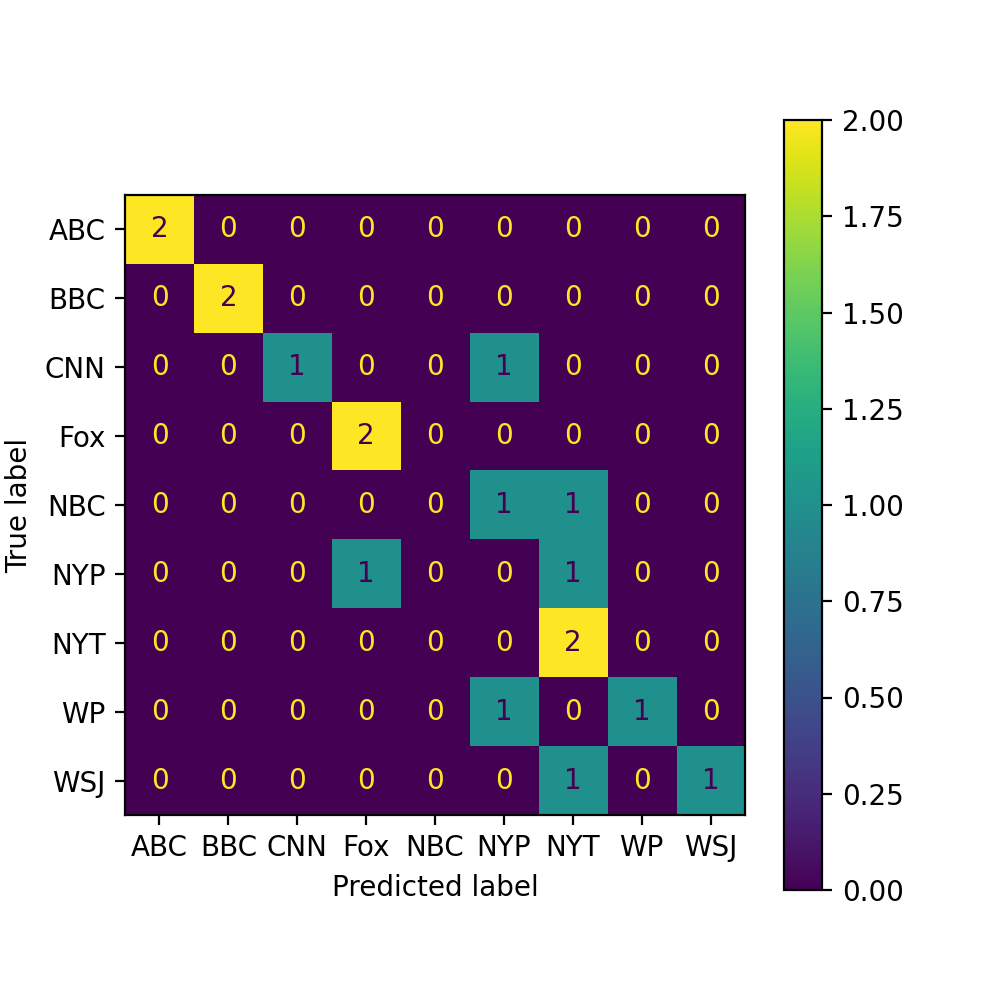

In [56]:
# create confusion matrix of model with best parameters

# set the training/testing datasets
X_train_df = tfidf_df[(tfidf_df['article_topic'] != 'U.S. and Germany Send Tanks to Ukraine') & 
        (tfidf_df['article_topic'] != 'Pentagon Documents Leak')].iloc[:, :-2]
X_test_df = tfidf_df[(tfidf_df['article_topic'] == 'U.S. and Germany Send Tanks to Ukraine') | 
        (tfidf_df['article_topic'] == 'Pentagon Documents Leak')].iloc[:, :-2]
y_train_df = tfidf_df[(tfidf_df['article_topic'] != 'U.S. and Germany Send Tanks to Ukraine') & 
        (tfidf_df['article_topic'] != 'Pentagon Documents Leak')]['article_source']
y_test_df = tfidf_df[(tfidf_df['article_topic'] == 'U.S. and Germany Send Tanks to Ukraine') | 
        (tfidf_df['article_topic'] == 'Pentagon Documents Leak')]['article_source']

# convert training/testing datasets to arrays 
X_train = X_train_df.to_numpy()
X_test = X_test_df.to_numpy()
y_train = y_train_df.to_numpy()
y_test = y_test_df.to_numpy()

# train the Random Forest model with the best parameters
rf_model = RandomForestClassifier(n_estimators = 200, criterion="gini", random_state=42)
rf_model.fit(X_train, y_train)

# make source predictions
predictions_array = rf_model.predict(X_test)

# specify the labels to make the confusion matrix
labels = ["ABC News", "BBC", "CNN", "Fox News", "NBC News", "New York Post",
          "The New York Times", "The Washington Post", "The Wall Street Journal"]

# shorten the labels so that the source names can easily fit on the confusion matrix
labels_short = ["ABC", "BBC", "CNN", "Fox", "NBC", "NYP",
          "NYT", "WP", "WSJ"]

# create the plot of the confusion matrix 
cm = confusion_matrix(y_test, predictions_array, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels_short)
disp.plot()
fig = disp.ax_.get_figure() 
fig.set_figwidth(5)
fig.set_figheight(5)